In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
from scipy.linalg import sqrtm 
import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.multivariate_normal import CensoredMultivariateNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, cov
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

TABLE_NAME = 'logs'

In [2]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/multi_censor_',
    'exp': 'multi_censor_fixed', 
    'trials': 20,
    'var': 10,
    'd': 2,
    'iter_': 2,
    'table_name': 'logs',
})

Synthetic Data Experiment for 2 Dimensional Censored Gaussian Distributions 

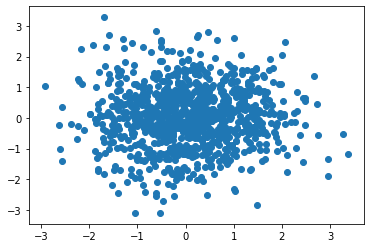

In [3]:
M = MultivariateNormal(ch.zeros(2), ch.eye(2))
samples = M.sample([args.samples])

plt.scatter(samples[:,0], samples[:,1])
plt.show()

Truncate the Dataset

alpha: 0.442


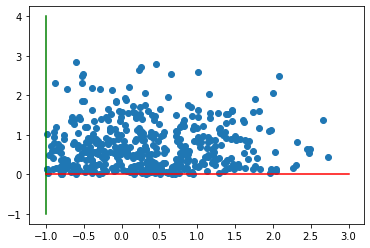

In [4]:
# phi = oracle.Left(Tensor([-float('inf'), 0]))
phi = oracle.Left(Tensor([-1, 0]))

indices = phi(samples).nonzero(as_tuple=False).flatten()
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))
plt.plot(phi.left[0].repeat(100, 1), ch.linspace(-1, 4, 100), color='green')
plt.plot(ch.linspace(-1, 3, 100), phi.left[1].repeat(100, 1), color='red')

plt.scatter(S[:,0], S[:,1])
plt.show()

In [5]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_cov = cov(S)
print("empirical covariance: ", emp_cov)
emp_scale = Tensor(sqrtm(emp_cov.numpy()))

S_norm = (S - emp_loc)@(emp_scale.inverse())
phi_norm = oracle.Left((phi.left - emp_loc)@(emp_scale.inverse()))

empirical mean:  tensor([0.3541, 0.7411])
empirical covariance:  tensor([[0.6390, 0.0093],
        [0.0093, 0.3564]])


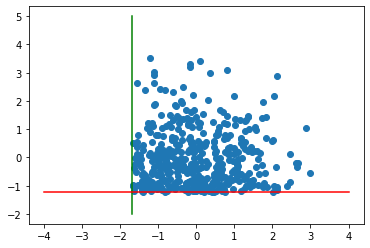

In [6]:
plt.scatter(S_norm[:,0], S_norm[:,1])
plt.plot(phi_norm.left[0].repeat(100, 1), ch.linspace(-2, 5, 100), color='green')
plt.plot(ch.linspace(-4, 4, 100), phi_norm.left[1].repeat(100, 1), color='red')

Run algorithm to Remove Bias from the Dataset

In [7]:
censored_multi = CensoredMultivariateNormal(phi=phi_norm, 
                                            alpha=alpha,
                                            bs=10,
                                            num_samples=1000,
                                            iter_=10, 
                                            step_lr=500, 
                                            step_lr_gamma=.95)
censored_multi.fit(S_norm)

mu: tensor([-0.0038, -0.0216])
cov: tensor([[ 1.0407, -0.0175],
        [-0.0175,  1.0229]])
num samples:  tensor(818)
cov grad: tensor([[ 0.2317, -0.1091],
        [-0.1091,  0.1569]])
loc grad: tensor([-0.6931, -0.0297])
cov matrix before projection: tensor([[0.9380, 0.0273],
        [0.0273, 0.9622]], requires_grad=True)
cov eigenvalues: tensor([0.9202+0.j, 0.9800+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9622, -0.0273],
        [-0.0273,  0.9380]], requires_grad=True)
mu: tensor([ 0.0673, -0.0175])
cov: tensor([[1.0401, 0.0303],
        [0.0303, 1.0670]])
num samples:  tensor(828)
cov grad: tensor([[ 0.0399,  0.1153],
        [ 0.1153, -0.3676]])
loc grad: tensor([0.5785, 0.8923])
cov matrix before projection: tensor([[ 0.9583, -0.0389],
        [-0.0389,  0.9747]], requires_grad=True)
cov eigenvalues: tensor([0.9268+0.j, 1.0062+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9747, 0.0389],
        [0.0389, 0.9583]], re

/Users/patroklos/Desktop/delphi_/delphi/distributions/multivariate_normal.py:104: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  eigvals = ch.linalg.eigvals(self.model.covariance_matrix).float()
/opt/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2, 2], strides() = [1, 2]
param.sizes() = [2, 2], strides() = [2, 1] (Triggered internally at  ../torch/csrc/autograd/functions/accumulate_grad.h:185.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


mu: tensor([-0.1825, -0.7438])
cov: tensor([[ 1.0729, -0.0285],
        [-0.0285,  1.9716]])
num samples:  tensor(602)
cov grad: tensor([[-0.0400, -0.0788],
        [-0.0788,  0.0218]])
loc grad: tensor([-0.5427, -0.0338])
cov matrix before projection: tensor([[0.9364, 0.0214],
        [0.0214, 0.5052]], requires_grad=True)
cov eigenvalues: tensor([0.9375+0.j, 0.5042+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9364, 0.0214],
        [0.0214, 0.5052]], requires_grad=True)
mu: tensor([-0.1176, -0.7402])
cov: tensor([[ 1.0689, -0.0452],
        [-0.0452,  1.9812]])
num samples:  tensor(593)
cov grad: tensor([[ 0.2821, -0.0457],
        [-0.0457,  0.2291]])
loc grad: tensor([-0.7978,  0.3724])
cov matrix before projection: tensor([[0.9082, 0.0259],
        [0.0259, 0.4823]], requires_grad=True)
cov eigenvalues: tensor([0.9098+0.j, 0.4807+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9082, 0.0259],
        [0.0259, 0.4823]], requ

cov: tensor([[ 1.6136, -0.1382],
        [-0.1382,  3.6006]])
num samples:  tensor(321)
cov grad: tensor([[-0.0440, -0.1318],
        [-0.1318, -0.3804]])
loc grad: tensor([-0.0617,  1.1268])
cov matrix before projection: tensor([[0.6262, 0.0370],
        [0.0370, 0.3167]], requires_grad=True)
cov eigenvalues: tensor([0.6305+0.j, 0.3123+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6262, 0.0370],
        [0.0370, 0.3167]], requires_grad=True)
mu: tensor([-0.4068, -1.9328])
cov: tensor([[ 1.6081, -0.1881],
        [-0.1881,  3.1797]])
num samples:  tensor(307)
cov grad: tensor([[-0.2586,  0.0744],
        [ 0.0744,  0.2633]])
loc grad: tensor([0.1776, 0.0229])
cov matrix before projection: tensor([[0.6520, 0.0296],
        [0.0296, 0.2904]], requires_grad=True)
cov eigenvalues: tensor([0.6544+0.j, 0.2879+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6520, 0.0296],
        [0.0296, 0.2904]], requires_grad=True)
mu: tensor([-0.43

cov matrix before projection: tensor([[0.5280, 0.0151],
        [0.0151, 0.2420]], requires_grad=True)
cov eigenvalues: tensor([0.5288+0.j, 0.2412+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5280, 0.0151],
        [0.0151, 0.2420]], requires_grad=True)
mu: tensor([-0.5420, -2.8512])
cov: tensor([[ 1.8974, -0.1185],
        [-0.1185,  4.1391]])
num samples:  tensor(161)
cov grad: tensor([[ 0.1953, -0.2030],
        [-0.2030, -0.0830]])
loc grad: tensor([-0.1398,  0.0761])
cov matrix before projection: tensor([[0.5084, 0.0354],
        [0.0354, 0.2503]], requires_grad=True)
cov eigenvalues: tensor([0.5132+0.j, 0.2456+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5084, 0.0354],
        [0.0354, 0.2503]], requires_grad=True)
mu: tensor([-0.4279, -2.7593])
cov: tensor([[ 1.9864, -0.2810],
        [-0.2810,  4.0345]])
num samples:  tensor(174)
cov grad: tensor([[0.1639, 0.0599],
        [0.0599, 0.2867]])
loc grad: tensor([-0.0582

num samples:  tensor(58)
cov grad: tensor([[ 0.1417,  0.1349],
        [ 0.1349, -0.3849]])
loc grad: tensor([-0.1541,  0.9186])
cov matrix before projection: tensor([[ 0.6034, -0.0617],
        [-0.0617,  0.1383]], requires_grad=True)
cov eigenvalues: tensor([0.6114+0.j, 0.1303+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6034, -0.0617],
        [-0.0617,  0.1383]], requires_grad=True)
mu: tensor([-0.8693, -5.2924])
cov: tensor([[1.7367, 0.7752],
        [0.7752, 7.5762]])
num samples:  tensor(48)
cov grad: tensor([[-0.1262, -0.4086],
        [-0.4086, -0.3389]])
loc grad: tensor([0.1748, 0.3918])
cov matrix before projection: tensor([[ 0.6160, -0.0209],
        [-0.0209,  0.1722]], requires_grad=True)
cov eigenvalues: tensor([0.6170+0.j, 0.1712+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6160, -0.0209],
        [-0.0209,  0.1722]], requires_grad=True)
mu: tensor([-0.4927, -4.2265])
cov: tensor([[1.6301, 0.1976],
       

cov grad: tensor([[-0.1239,  0.3521],
        [ 0.3521, -0.1260]])
loc grad: tensor([-0.2281,  0.4770])
cov matrix before projection: tensor([[0.9116, 0.0336],
        [0.0336, 0.2974]], requires_grad=True)
cov eigenvalues: tensor([0.9135+0.j, 0.2956+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9116, 0.0336],
        [0.0336, 0.2974]], requires_grad=True)
mu: tensor([-0.0977, -2.1697])
cov: tensor([[ 1.1015, -0.1245],
        [-0.1245,  3.3763]])
num samples:  tensor(268)
cov grad: tensor([[-0.2356, -0.1665],
        [-0.1665, -0.3259]])
loc grad: tensor([0.6752, 0.6491])
cov matrix before projection: tensor([[0.9352, 0.0503],
        [0.0503, 0.3300]], requires_grad=True)
cov eigenvalues: tensor([0.9393+0.j, 0.3259+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9352, 0.0503],
        [0.0503, 0.3300]], requires_grad=True)
mu: tensor([-0.1303, -2.1422])
cov: tensor([[ 1.0781, -0.1642],
        [-0.1642,  3.0552]])
num samples:

(Pdb) 
(Pdb) exit


BdbQuit: 

In [8]:
censored_multi.covariance_matrix @ emp_cov

tensor([[0.3969, 0.0227],
        [0.0304, 0.0013]], grad_fn=<MmBackward0>)

In [9]:
censored_multi.loc @ emp_scale + emp_loc

tensor([0.0269, 0.3301], grad_fn=<AddBackward0>)

# Multivariate Normal Performance Experiment


In [10]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'var': int,
    'alpha': float,
}

store.add_table(args.table_name, schema)


for i in range(args.trials): 
    for var in range(1, args.var + 1): 
        # create new dataset
        gt_loc, gt_scale = ch.zeros(args.d), var * ch.eye(args.d)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # right truncate at 0
        phi = oracle.Left(Tensor([-1, 0]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)
        
        emp_loc = S.mean(0)
        emp_cov = cov(S)
        emp_scale = Tensor(sqrtm(emp_cov.numpy()))

        S_norm = (S - emp_loc) @ emp_scale.inverse()
        phi_norm = oracle.Left((phi.left - emp_loc) @ emp_scale.inverse())

        emp_dist = MultivariateNormal(emp_loc, emp_cov)

        censored_multi = CensoredMultivariateNormal(phi=phi_norm, 
                              alpha=alpha, 
                              iter_=args.iter_, 
                              bs=10, 
                              num_samples=100,
                              lr=1e-1)
        censored_multi.fit(S_norm)

        loc_ = censored_multi.loc @ emp_scale + emp_loc
        cov_ = censored_multi.covariance_matrix @ emp_cov

        censor_dist = MultivariateNormal(loc_, cov_)


        kl_censor = float(kl_divergence(gt_dist, censor_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored': kl_censor,
            'var': var,
            'alpha': alpha
        })
        store[args.table_name].flush_row()
        
store.close()

Logging in: /Users/patroklos/Desktop/exp/multi_censor_/multi_censor_fixed/bedd2af9-eb2e-427e-a99f-9e31927b0928
mu: tensor([-0.0050,  0.0096])
cov: tensor([[0.9793, 0.0077],
        [0.0077, 1.0800]])
num samples:  tensor(89)
cov grad: tensor([[-0.0359,  0.0523],
        [ 0.0523,  0.1340]])
loc grad: tensor([0.4123, 0.6594])
cov matrix before projection: tensor([[ 1.0248, -0.0125],
        [-0.0125,  0.9126]], requires_grad=True)
cov eigenvalues: tensor([1.0262+0.j, 0.9112+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0248, -0.0125],
        [-0.0125,  0.9126]], requires_grad=True)
mu: tensor([-0.0461, -0.0631])
cov: tensor([[0.9760, 0.0133],
        [0.0133, 1.0960]])
num samples:  tensor(83)
cov grad: tensor([[0.0117, 0.2621],
        [0.2621, 0.0082]])
loc grad: tensor([0.4059, 0.3038])
cov matrix before projection: tensor([[ 1.0236, -0.0387],
        [-0.0387,  0.9118]], requires_grad=True)
cov eigenvalues: tensor([1.0357+0.j, 0.8997+0.j], grad_fn=<Li

cov: tensor([[1.3779, 0.0450],
        [0.0450, 2.6071]])
num samples:  tensor(45)
cov grad: tensor([[ 0.5216, -0.0961],
        [-0.0961, -1.4516]])
loc grad: tensor([-0.7567,  0.4969])
cov matrix before projection: tensor([[ 0.6740, -0.0029],
        [-0.0029,  0.5289]], requires_grad=True)
cov eigenvalues: tensor([0.6741+0.j, 0.5289+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6740, -0.0029],
        [-0.0029,  0.5289]], requires_grad=True)
mu: tensor([-0.3415, -0.6376])
cov: tensor([[1.4837, 0.0082],
        [0.0082, 1.8906]])
num samples:  tensor(66)
cov grad: tensor([[ 0.2231,  0.2803],
        [ 0.2803, -0.0745]])
loc grad: tensor([-0.3537,  0.2657])
cov matrix before projection: tensor([[ 0.6517, -0.0310],
        [-0.0310,  0.5364]], requires_grad=True)
cov eigenvalues: tensor([0.6595+0.j, 0.5286+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6517, -0.0310],
        [-0.0310,  0.5364]], requires_grad=True)
mu: tenso

cov matrix after projection: tensor([[ 0.6625, -0.0281],
        [-0.0281,  0.2135]], requires_grad=True)
mu: tensor([-0.4472, -2.1294])
cov: tensor([[1.5178, 0.1997],
        [0.1997, 4.7112]])
num samples:  tensor(29)
cov grad: tensor([[ 0.1339, -0.0856],
        [-0.0856, -0.2062]])
loc grad: tensor([-0.4483,  0.5090])
cov matrix before projection: tensor([[ 0.6492, -0.0195],
        [-0.0195,  0.2341]], requires_grad=True)
cov eigenvalues: tensor([0.6501+0.j, 0.2332+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6492, -0.0195],
        [-0.0195,  0.2341]], requires_grad=True)
mu: tensor([-0.3595, -2.1356])
cov: tensor([[1.5443, 0.1288],
        [0.1288, 4.2829]])
num samples:  tensor(30)
cov grad: tensor([[ 0.0311,  0.0967],
        [ 0.0967, -0.0350]])
loc grad: tensor([-0.2313,  0.0470])
cov matrix before projection: tensor([[ 0.6460, -0.0292],
        [-0.0292,  0.2376]], requires_grad=True)
cov eigenvalues: tensor([0.6481+0.j, 0.2355+0.j], grad_fn=

cov matrix before projection: tensor([[0.7498, 0.0143],
        [0.0143, 0.6145]], requires_grad=True)
cov eigenvalues: tensor([0.7513+0.j, 0.6130+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7498, 0.0143],
        [0.0143, 0.6145]], requires_grad=True)
mu: tensor([-0.1450, -0.3032])
cov: tensor([[ 1.3343, -0.0311],
        [-0.0311,  1.6281]])
num samples:  tensor(66)
cov grad: tensor([[ 0.1831, -0.0995],
        [-0.0995,  0.1212]])
loc grad: tensor([-0.1512, -0.3353])
cov matrix before projection: tensor([[0.7315, 0.0243],
        [0.0243, 0.6024]], requires_grad=True)
cov eigenvalues: tensor([0.7359+0.j, 0.5980+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7315, 0.0243],
        [0.0243, 0.6024]], requires_grad=True)
mu: tensor([-0.1255, -0.2520])
cov: tensor([[ 1.3689, -0.0551],
        [-0.0551,  1.6623]])
num samples:  tensor(74)
cov grad: tensor([[ 0.2285,  0.2735],
        [ 0.2735, -0.2740]])
loc grad: tensor([ 0.57

cov: tensor([[ 1.0526, -0.0290],
        [-0.0290,  1.1419]])
num samples:  tensor(80)
cov grad: tensor([[ 0.2820, -0.2972],
        [-0.2972, -0.4100]])
loc grad: tensor([0.2798, 0.4180])
cov matrix before projection: tensor([[0.9225, 0.0538],
        [0.0538, 0.9174]], requires_grad=True)
cov eigenvalues: tensor([0.9738+0.j, 0.8660+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9225, 0.0538],
        [0.0538, 0.9174]], requires_grad=True)
mu: tensor([-0.2469, -0.0622])
cov: tensor([[ 1.0878, -0.0638],
        [-0.0638,  1.0938]])
num samples:  tensor(73)
cov grad: tensor([[0.1504, 0.0283],
        [0.0283, 0.7385]])
loc grad: tensor([-0.7855,  0.2139])
cov matrix before projection: tensor([[0.9074, 0.0510],
        [0.0510, 0.8435]], requires_grad=True)
cov eigenvalues: tensor([0.9357+0.j, 0.8153+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9074, 0.0510],
        [0.0510, 0.8435]], requires_grad=True)
mu: tensor([-0.1626, -0

cov grad: tensor([[ 0.1219,  0.1136],
        [ 0.1136, -0.3008]])
loc grad: tensor([-0.1096,  0.3664])
cov matrix before projection: tensor([[0.4933, 0.0052],
        [0.0052, 0.4636]], requires_grad=True)
cov eigenvalues: tensor([0.4942+0.j, 0.4627+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.4933, 0.0052],
        [0.0052, 0.4636]], requires_grad=True)
mu: tensor([-0.5727, -1.0275])
cov: tensor([[ 2.0272, -0.0226],
        [-0.0226,  2.1573]])
num samples:  tensor(44)
cov grad: tensor([[-0.0377, -0.1358],
        [-0.1358,  0.0506]])
loc grad: tensor([-0.1160, -0.2567])
cov matrix before projection: tensor([[0.4971, 0.0188],
        [0.0188, 0.4585]], requires_grad=True)
cov eigenvalues: tensor([0.5047+0.j, 0.4509+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.4971, 0.0188],
        [0.0188, 0.4585]], requires_grad=True)
mu: tensor([-0.5192, -0.9680])
cov: tensor([[ 2.0147, -0.0824],
        [-0.0824,  2.1842]])
num samples

mu: tensor([-0.1589, -0.2698])
cov: tensor([[ 1.2805, -0.0317],
        [-0.0317,  1.3915]])
num samples:  tensor(70)
cov grad: tensor([[ 0.5487, -0.4593],
        [-0.4593,  0.0190]])
loc grad: tensor([-0.6243,  0.1247])
cov matrix before projection: tensor([[0.7265, 0.0637],
        [0.0637, 0.7172]], requires_grad=True)
cov eigenvalues: tensor([0.7858+0.j, 0.6580+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7265, 0.0637],
        [0.0637, 0.7172]], requires_grad=True)
mu: tensor([-0.0664, -0.2860])
cov: tensor([[ 1.3872, -0.1233],
        [-0.1233,  1.4053]])
num samples:  tensor(65)
cov grad: tensor([[-0.2398, -0.1011],
        [-0.1011,  0.5655]])
loc grad: tensor([ 0.4852, -0.3534])
cov matrix before projection: tensor([[0.7505, 0.0738],
        [0.0738, 0.6606]], requires_grad=True)
cov eigenvalues: tensor([0.7920+0.j, 0.6191+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7505, 0.0738],
        [0.0738, 0.6606]], requir

loc grad: tensor([0.3302, 0.3554])
cov matrix before projection: tensor([[ 0.5359, -0.0512],
        [-0.0512,  0.5509]], requires_grad=True)
cov eigenvalues: tensor([0.4917+0.j, 0.5951+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5509, 0.0512],
        [0.0512, 0.5359]], requires_grad=True)
mu: tensor([-0.3847, -1.1311])
cov: tensor([[ 1.8313, -0.1749],
        [-0.1749,  1.8829]])
num samples:  tensor(45)
cov grad: tensor([[-0.2763,  0.2848],
        [ 0.2848,  0.4349]])
loc grad: tensor([ 0.4341, -0.3974])
cov matrix before projection: tensor([[0.5786, 0.0227],
        [0.0227, 0.4924]], requires_grad=True)
cov eigenvalues: tensor([0.5842+0.j, 0.4868+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5786, 0.0227],
        [0.0227, 0.4924]], requires_grad=True)
mu: tensor([-0.4956, -1.1674])
cov: tensor([[ 1.7315, -0.0798],
        [-0.0798,  2.0347]])
num samples:  tensor(36)
cov grad: tensor([[ 0.0789, -0.1161],
        [-0.1

cov matrix after projection: tensor([[ 0.7982, -0.0733],
        [-0.0733,  0.6294]], requires_grad=True)
mu: tensor([-0.3666, -0.4717])
cov: tensor([[1.2663, 0.1475],
        [0.1475, 1.6061]])
num samples:  tensor(50)
cov grad: tensor([[ 0.2954,  0.0944],
        [ 0.0944, -0.1157]])
loc grad: tensor([-0.1755, -0.3417])
cov matrix before projection: tensor([[ 0.7687, -0.0827],
        [-0.0827,  0.6409]], requires_grad=True)
cov eigenvalues: tensor([0.8093+0.j, 0.6003+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7687, -0.0827],
        [-0.0827,  0.6409]], requires_grad=True)
mu: tensor([-0.3575, -0.4140])
cov: tensor([[1.3193, 0.1703],
        [0.1703, 1.5823]])
num samples:  tensor(73)
cov grad: tensor([[-0.1382, -0.0819],
        [-0.0819, -0.0197]])
loc grad: tensor([0.1995, 0.3768])
cov matrix before projection: tensor([[ 0.7825, -0.0746],
        [-0.0746,  0.6429]], requires_grad=True)
cov eigenvalues: tensor([0.8148+0.j, 0.6106+0.j], grad_fn=<L

cov eigenvalues: tensor([0.8971+0.j, 0.8226+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8829, 0.0293],
        [0.0293, 0.8369]], requires_grad=True)
mu: tensor([-0.0127,  0.0375])
cov: tensor([[ 1.1340, -0.0397],
        [-0.0397,  1.1962]])
num samples:  tensor(84)
cov grad: tensor([[-0.1690, -0.1528],
        [-0.1528, -0.0719]])
loc grad: tensor([-0.0027,  0.4242])
cov matrix before projection: tensor([[0.8998, 0.0446],
        [0.0446, 0.8441]], requires_grad=True)
cov eigenvalues: tensor([0.9245+0.j, 0.8194+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8998, 0.0446],
        [0.0446, 0.8441]], requires_grad=True)
mu: tensor([-0.0102, -0.0130])
cov: tensor([[ 1.1143, -0.0589],
        [-0.0589,  1.1878]])
num samples:  tensor(84)
cov grad: tensor([[ 0.6007, -0.4683],
        [-0.4683,  0.8831]])
loc grad: tensor([ 0.2616, -0.0845])
cov matrix before projection: tensor([[0.8397, 0.0914],
        [0.0914, 0.7558]], requir

cov matrix before projection: tensor([[0.5905, 0.0588],
        [0.0588, 0.4398]], requires_grad=True)
cov eigenvalues: tensor([0.6107+0.j, 0.4196+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5905, 0.0588],
        [0.0588, 0.4398]], requires_grad=True)
mu: tensor([-0.4432, -0.9004])
cov: tensor([[ 1.7164, -0.2296],
        [-0.2296,  2.3045]])
num samples:  tensor(40)
cov grad: tensor([[ 0.3853, -0.3027],
        [-0.3027, -0.3695]])
loc grad: tensor([-0.8356,  0.0898])
cov matrix before projection: tensor([[0.5519, 0.0891],
        [0.0891, 0.4767]], requires_grad=True)
cov eigenvalues: tensor([0.6110+0.j, 0.4176+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5519, 0.0891],
        [0.0891, 0.4767]], requires_grad=True)
mu: tensor([-0.2812, -0.8516])
cov: tensor([[ 1.8681, -0.3491],
        [-0.3491,  2.1628]])
num samples:  tensor(62)
cov grad: tensor([[-0.4902,  0.2432],
        [ 0.2432, -0.2519]])
loc grad: tensor([0.350

cov matrix before projection: tensor([[ 0.8535, -0.0282],
        [-0.0282,  0.7927]], requires_grad=True)
cov eigenvalues: tensor([0.8646+0.j, 0.7816+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8535, -0.0282],
        [-0.0282,  0.7927]], requires_grad=True)
mu: tensor([-0.1936, -0.5102])
cov: tensor([[1.1730, 0.0418],
        [0.0418, 1.2630]])
num samples:  tensor(63)
cov grad: tensor([[-0.0025,  0.3888],
        [ 0.3888, -0.0120]])
loc grad: tensor([-0.2218,  0.0147])
cov matrix before projection: tensor([[ 0.8538, -0.0671],
        [-0.0671,  0.7939]], requires_grad=True)
cov eigenvalues: tensor([0.8973+0.j, 0.7504+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8538, -0.0671],
        [-0.0671,  0.7939]], requires_grad=True)
mu: tensor([-0.1916, -0.5206])
cov: tensor([[1.1791, 0.0997],
        [0.0997, 1.2680]])
num samples:  tensor(63)
cov grad: tensor([[ 0.0097, -0.0796],
        [-0.0796,  0.3968]])
loc grad: tenso

cov grad: tensor([[0.2425, 0.0478],
        [0.0478, 0.2201]])
loc grad: tensor([-0.3224,  0.0408])
cov matrix before projection: tensor([[ 0.8887, -0.0354],
        [-0.0354,  0.8257]], requires_grad=True)
cov eigenvalues: tensor([0.9046+0.j, 0.8098+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8887, -0.0354],
        [-0.0354,  0.8257]], requires_grad=True)
mu: tensor([-0.0844, -0.1114])
cov: tensor([[1.1271, 0.0483],
        [0.0483, 1.2132]])
num samples:  tensor(80)
cov grad: tensor([[0.3992, 0.3019],
        [0.3019, 0.4303]])
loc grad: tensor([-0.6926,  0.2978])
cov matrix before projection: tensor([[ 0.8488, -0.0656],
        [-0.0656,  0.7827]], requires_grad=True)
cov eigenvalues: tensor([0.8892+0.j, 0.7423+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8488, -0.0656],
        [-0.0656,  0.7827]], requires_grad=True)
mu: tensor([-0.0140, -0.1529])
cov: tensor([[1.1858, 0.0993],
        [0.0993, 1.2860]])
num samples

num samples:  tensor(56)
cov grad: tensor([[0.3430, 0.1883],
        [0.1883, 0.5132]])
loc grad: tensor([ 0.2657, -0.5958])
cov matrix before projection: tensor([[ 0.7839, -0.0762],
        [-0.0762,  0.5945]], requires_grad=True)
cov eigenvalues: tensor([0.8107+0.j, 0.5677+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7839, -0.0762],
        [-0.0762,  0.5945]], requires_grad=True)
mu: tensor([-0.4628, -0.7496])
cov: tensor([[1.2918, 0.1656],
        [0.1656, 1.7032]])
num samples:  tensor(59)
cov grad: tensor([[ 0.0620, -0.2393],
        [-0.2393,  0.2054]])
loc grad: tensor([ 0.1608, -0.5201])
cov matrix before projection: tensor([[ 0.7777, -0.0523],
        [-0.0523,  0.5740]], requires_grad=True)
cov eigenvalues: tensor([0.7903+0.j, 0.5614+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7777, -0.0523],
        [-0.0523,  0.5740]], requires_grad=True)
mu: tensor([-0.4585, -0.6662])
cov: tensor([[1.2938, 0.1179],
        [

num samples:  tensor(70)
cov grad: tensor([[-0.0897,  0.3637],
        [ 0.3637, -0.7079]])
loc grad: tensor([0.9199, 0.1543])
cov matrix before projection: tensor([[ 0.9190, -0.1391],
        [-0.1391,  0.7644]], requires_grad=True)
cov eigenvalues: tensor([1.0009+0.j, 0.6825+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9190, -0.1391],
        [-0.1391,  0.7644]], requires_grad=True)
mu: tensor([-0.3219, -0.5018])
cov: tensor([[1.1190, 0.2037],
        [0.2037, 1.3454]])
num samples:  tensor(57)
cov grad: tensor([[-0.1745, -0.1118],
        [-0.1118,  0.0389]])
loc grad: tensor([-0.2338, -0.5517])
cov matrix before projection: tensor([[ 0.9365, -0.1280],
        [-0.1280,  0.7605]], requires_grad=True)
cov eigenvalues: tensor([1.0038+0.j, 0.6932+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9365, -0.1280],
        [-0.1280,  0.7605]], requires_grad=True)
mu: tensor([-0.2736, -0.4189])
cov: tensor([[1.0930, 0.1839],
       

loc grad: tensor([-0.4299,  0.0794])
cov matrix before projection: tensor([[0.9931, 0.0444],
        [0.0444, 0.8530]], requires_grad=True)
cov eigenvalues: tensor([1.0060+0.j, 0.8401+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9931, 0.0444],
        [0.0444, 0.8530]], requires_grad=True)
mu: tensor([-0.0687, -0.1837])
cov: tensor([[ 1.0093, -0.0525],
        [-0.0525,  1.1751]])
num samples:  tensor(70)
cov grad: tensor([[ 0.4779, -0.2135],
        [-0.2135,  0.3072]])
loc grad: tensor([-0.4088, -0.4981])
cov matrix before projection: tensor([[0.9453, 0.0657],
        [0.0657, 0.8223]], requires_grad=True)
cov eigenvalues: tensor([0.9739+0.j, 0.7938+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9453, 0.0657],
        [0.0657, 0.8223]], requires_grad=True)
mu: tensor([-0.0284, -0.1315])
cov: tensor([[ 1.0637, -0.0851],
        [-0.0851,  1.2229]])
num samples:  tensor(79)
cov grad: tensor([[0.0262, 0.1377],
        [0.1377, 

num samples:  tensor(41)
cov grad: tensor([[ 1.0708, -0.3872],
        [-0.3872, -0.0624]])
loc grad: tensor([-0.8178, -0.0214])
cov matrix before projection: tensor([[ 0.5521, -0.0304],
        [-0.0304,  0.5777]], requires_grad=True)
cov eigenvalues: tensor([0.5318+0.j, 0.5979+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5777, 0.0304],
        [0.0304, 0.5521]], requires_grad=True)
mu: tensor([-0.6810, -0.7334])
cov: tensor([[ 1.7362, -0.0957],
        [-0.0958,  1.8166]])
num samples:  tensor(36)
cov grad: tensor([[ 0.7850, -0.0929],
        [-0.0929, -0.0138]])
loc grad: tensor([-0.6283,  0.0773])
cov matrix before projection: tensor([[0.4992, 0.0397],
        [0.0397, 0.5535]], requires_grad=True)
cov eigenvalues: tensor([0.4782+0.j, 0.5744+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5535, -0.0397],
        [-0.0397,  0.4992]], requires_grad=True)
mu: tensor([-0.7039, -0.9242])
cov: tensor([[1.8172, 0.1446],
        [

num samples:  tensor(67)
cov grad: tensor([[-0.2566,  0.3314],
        [ 0.3314, -0.5874]])
loc grad: tensor([0.3243, 0.6471])
cov matrix before projection: tensor([[ 0.7556, -0.0375],
        [-0.0375,  0.6573]], requires_grad=True)
cov eigenvalues: tensor([0.7682+0.j, 0.6446+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7556, -0.0375],
        [-0.0375,  0.6573]], requires_grad=True)
mu: tensor([-0.2314, -0.6220])
cov: tensor([[1.3272, 0.0756],
        [0.0756, 1.5258]])
num samples:  tensor(66)
cov grad: tensor([[-0.3275,  0.1068],
        [ 0.1068,  0.1539]])
loc grad: tensor([ 0.1264, -0.2067])
cov matrix before projection: tensor([[ 0.7884, -0.0481],
        [-0.0481,  0.6419]], requires_grad=True)
cov eigenvalues: tensor([0.8028+0.j, 0.6275+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7884, -0.0481],
        [-0.0481,  0.6419]], requires_grad=True)
mu: tensor([-0.2455, -0.6096])
cov: tensor([[1.2743, 0.0956],
       

cov grad: tensor([[ 0.0056, -0.0877],
        [-0.0877,  0.0290]])
loc grad: tensor([-0.0371, -0.1587])
cov matrix before projection: tensor([[ 0.6185, -0.0873],
        [-0.0873,  0.4310]], requires_grad=True)
cov eigenvalues: tensor([0.6529+0.j, 0.3967+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6185, -0.0873],
        [-0.0873,  0.4310]], requires_grad=True)
mu: tensor([-0.2329, -1.2334])
cov: tensor([[1.6644, 0.3372],
        [0.3372, 2.3883]])
num samples:  tensor(49)
cov grad: tensor([[-0.3464,  0.0274],
        [ 0.0274,  0.1879]])
loc grad: tensor([0.4371, 0.1141])
cov matrix before projection: tensor([[ 0.6531, -0.0901],
        [-0.0901,  0.4122]], requires_grad=True)
cov eigenvalues: tensor([0.6831+0.j, 0.3823+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6531, -0.0901],
        [-0.0901,  0.4122]], requires_grad=True)
mu: tensor([-0.3067, -1.3349])
cov: tensor([[1.5786, 0.3450],
        [0.3449, 2.5011]])
num s

cov eigenvalues: tensor([0.8249+0.j, 0.6498+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7519, 0.0863],
        [0.0863, 0.7228]], requires_grad=True)
mu: tensor([-0.4658, -0.4576])
cov: tensor([[ 1.3484, -0.1610],
        [-0.1610,  1.4028]])
num samples:  tensor(59)
cov grad: tensor([[0.9796, 0.0095],
        [0.0095, 0.8730]])
loc grad: tensor([-0.3515, -0.6399])
cov matrix before projection: tensor([[0.6540, 0.0854],
        [0.0854, 0.6355]], requires_grad=True)
cov eigenvalues: tensor([0.7306+0.j, 0.5588+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6540, 0.0854],
        [0.0854, 0.6355]], requires_grad=True)
mu: tensor([-0.4877, -0.4175])
cov: tensor([[ 1.5564, -0.2091],
        [-0.2091,  1.6018]])
num samples:  tensor(59)
cov grad: tensor([[ 0.2977, -0.2123],
        [-0.2123,  0.2643]])
loc grad: tensor([-0.0548, -0.5277])
cov matrix before projection: tensor([[0.6242, 0.1066],
        [0.1066, 0.6090]], requires_g

cov grad: tensor([[0.1074, 0.0390],
        [0.0390, 0.5289]])
loc grad: tensor([-0.4219, -0.3441])
cov matrix before projection: tensor([[ 0.9072, -0.0228],
        [-0.0228,  0.8183]], requires_grad=True)
cov eigenvalues: tensor([0.9127+0.j, 0.8128+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9072, -0.0228],
        [-0.0228,  0.8183]], requires_grad=True)
mu: tensor([ 0.0849, -0.1621])
cov: tensor([[1.1031, 0.0307],
        [0.0307, 1.2229]])
num samples:  tensor(77)
cov grad: tensor([[ 0.2162, -0.4159],
        [-0.4159,  0.0936]])
loc grad: tensor([0.3467, 0.3072])
cov matrix before projection: tensor([[0.8855, 0.0188],
        [0.0188, 0.8090]], requires_grad=True)
cov eigenvalues: tensor([0.8899+0.j, 0.8046+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8855, 0.0188],
        [0.0188, 0.8090]], requires_grad=True)
mu: tensor([ 0.0563, -0.2056])
cov: tensor([[ 1.1298, -0.0263],
        [-0.0263,  1.2368]])
num samples: 

cov matrix before projection: tensor([[0.7779, 0.0844],
        [0.0844, 0.4735]], requires_grad=True)
cov eigenvalues: tensor([0.7998+0.j, 0.4517+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7779, 0.0844],
        [0.0844, 0.4735]], requires_grad=True)
mu: tensor([-0.1979, -0.8428])
cov: tensor([[ 1.3109, -0.2337],
        [-0.2337,  2.1535]])
num samples:  tensor(49)
cov grad: tensor([[ 0.3722,  0.0539],
        [ 0.0539, -0.1666]])
loc grad: tensor([-0.7426, -0.1325])
cov matrix before projection: tensor([[0.7407, 0.0790],
        [0.0790, 0.4902]], requires_grad=True)
cov eigenvalues: tensor([0.7635+0.j, 0.4673+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7407, 0.0790],
        [0.0790, 0.4902]], requires_grad=True)
mu: tensor([-0.1181, -0.8021])
cov: tensor([[ 1.3737, -0.2215],
        [-0.2215,  2.0757]])
num samples:  tensor(59)
cov grad: tensor([[ 0.1133, -0.2634],
        [-0.2634, -0.2373]])
loc grad: tensor([-0.21

num samples:  tensor(60)
cov grad: tensor([[ 0.0730, -0.0359],
        [-0.0359, -0.0719]])
loc grad: tensor([-0.5957,  0.6469])
cov matrix before projection: tensor([[ 0.7876, -0.0124],
        [-0.0124,  0.5106]], requires_grad=True)
cov eigenvalues: tensor([0.7881+0.j, 0.5101+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7876, -0.0124],
        [-0.0124,  0.5106]], requires_grad=True)
mu: tensor([-0.2292, -0.6024])
cov: tensor([[1.2702, 0.0309],
        [0.0309, 1.9591]])
num samples:  tensor(58)
Iteration 1 | Log Likelihood: 0.101
mu: tensor([-0.2292, -0.6024])
cov: tensor([[1.2702, 0.0309],
        [0.0309, 1.9591]])
num samples:  tensor(65)
cov grad: tensor([[-0.1315, -0.1780],
        [-0.1780,  0.3623]])
loc grad: tensor([0.3648, 0.2226])
cov matrix before projection: tensor([[0.8007, 0.0054],
        [0.0054, 0.4744]], requires_grad=True)
cov eigenvalues: tensor([0.8008+0.j, 0.4743+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: 

cov matrix before projection: tensor([[ 0.8302, -0.0190],
        [-0.0190,  0.7296]], requires_grad=True)
cov eigenvalues: tensor([0.8337+0.j, 0.7262+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8302, -0.0190],
        [-0.0190,  0.7296]], requires_grad=True)
mu: tensor([-0.0300, -0.5047])
cov: tensor([[1.2052, 0.0314],
        [0.0314, 1.3714]])
num samples:  tensor(69)
cov grad: tensor([[-1.5738e-04,  2.3713e-01],
        [ 2.3713e-01,  2.9747e-01]])
loc grad: tensor([-0.2300,  0.3262])
cov matrix before projection: tensor([[ 0.8302, -0.0427],
        [-0.0427,  0.6999]], requires_grad=True)
cov eigenvalues: tensor([0.8430+0.j, 0.6871+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8302, -0.0427],
        [-0.0427,  0.6999]], requires_grad=True)
mu: tensor([-0.0202, -0.5732])
cov: tensor([[1.2083, 0.0738],
        [0.0738, 1.4333]])
num samples:  tensor(66)
cov grad: tensor([[-0.2241, -0.2527],
        [-0.2527, -0.1975]])

num samples:  tensor(81)
cov grad: tensor([[ 0.1248,  0.1952],
        [ 0.1952, -0.0402]])
loc grad: tensor([0.1156, 0.1718])
cov matrix before projection: tensor([[ 1.0300, -0.0608],
        [-0.0608,  0.9144]], requires_grad=True)
cov eigenvalues: tensor([1.0561+0.j, 0.8883+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0300, -0.0608],
        [-0.0608,  0.9144]], requires_grad=True)
mu: tensor([-0.0509, -0.0426])
cov: tensor([[0.9747, 0.0648],
        [0.0648, 1.0980]])
num samples:  tensor(74)
cov grad: tensor([[0.2267, 0.1059],
        [0.1059, 0.3055]])
loc grad: tensor([ 0.0365, -0.0097])
cov matrix before projection: tensor([[ 1.0074, -0.0714],
        [-0.0714,  0.8838]], requires_grad=True)
cov eigenvalues: tensor([1.0400+0.j, 0.8512+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0074, -0.0714],
        [-0.0714,  0.8838]], requires_grad=True)
mu: tensor([-0.0562, -0.0441])
cov: tensor([[0.9984, 0.0806],
        [0.

cov matrix after projection: tensor([[0.6317, 0.0751],
        [0.0751, 0.4872]], requires_grad=True)
mu: tensor([-0.2849, -0.6798])
cov: tensor([[ 1.6127, -0.2487],
        [-0.2487,  2.0908]])
num samples:  tensor(58)
cov grad: tensor([[ 0.0751, -0.3931],
        [-0.3931,  1.0606]])
loc grad: tensor([ 0.0902, -0.8443])
cov matrix before projection: tensor([[0.6242, 0.1144],
        [0.1144, 0.3812]], requires_grad=True)
cov eigenvalues: tensor([0.6696+0.j, 0.3358+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6242, 0.1144],
        [0.1144, 0.3812]], requires_grad=True)
mu: tensor([-0.2705, -0.6223])
cov: tensor([[ 1.6955, -0.5091],
        [-0.5091,  2.7763]])
num samples:  tensor(54)
cov grad: tensor([[0.2827, 0.2393],
        [0.2393, 0.3689]])
loc grad: tensor([ 0.2122, -1.0034])
cov matrix before projection: tensor([[0.5959, 0.0905],
        [0.0905, 0.3443]], requires_grad=True)
cov eigenvalues: tensor([0.6251+0.j, 0.3151+0.j], grad_fn=<LinalgEigBa

cov grad: tensor([[ 0.0725, -0.2123],
        [-0.2123,  0.0611]])
loc grad: tensor([0.2918, 0.0193])
cov matrix before projection: tensor([[0.9233, 0.0651],
        [0.0651, 0.7702]], requires_grad=True)
cov eigenvalues: tensor([0.9472+0.j, 0.7463+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9233, 0.0651],
        [0.0651, 0.7702]], requires_grad=True)
mu: tensor([-0.1907, -0.1779])
cov: tensor([[ 1.0896, -0.0921],
        [-0.0921,  1.3061]])
num samples:  tensor(78)
cov grad: tensor([[0.0642, 0.0684],
        [0.0684, 0.5953]])
loc grad: tensor([0.4317, 0.1256])
cov matrix before projection: tensor([[0.9168, 0.0583],
        [0.0583, 0.7107]], requires_grad=True)
cov eigenvalues: tensor([0.9322+0.j, 0.6953+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9168, 0.0583],
        [0.0583, 0.7107]], requires_grad=True)
mu: tensor([-0.2385, -0.2084])
cov: tensor([[ 1.0964, -0.0899],
        [-0.0899,  1.4145]])
num samples:  tenso

cov matrix after projection: tensor([[0.8060, 0.0909],
        [0.0909, 0.4200]], requires_grad=True)
mu: tensor([-0.5738, -0.7664])
cov: tensor([[ 1.2717, -0.2752],
        [-0.2752,  2.4407]])
num samples:  tensor(47)
cov grad: tensor([[ 0.1287, -0.0966],
        [-0.0966, -0.6563]])
loc grad: tensor([-0.2076,  0.7605])
cov matrix before projection: tensor([[0.7931, 0.1006],
        [0.1006, 0.4856]], requires_grad=True)
cov eigenvalues: tensor([0.8231+0.j, 0.4556+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7931, 0.1006],
        [0.1006, 0.4856]], requires_grad=True)
mu: tensor([-0.5414, -0.8147])
cov: tensor([[ 1.2948, -0.2681],
        [-0.2681,  2.1148]])
num samples:  tensor(48)
cov grad: tensor([[ 0.2495,  0.3077],
        [ 0.3077, -0.2157]])
loc grad: tensor([0.0790, 0.3719])
cov matrix before projection: tensor([[0.7682, 0.0698],
        [0.0698, 0.5072]], requires_grad=True)
cov eigenvalues: tensor([0.7857+0.j, 0.4897+0.j], grad_fn=<LinalgEig

mu: tensor([-0.1698, -0.5841])
cov: tensor([[1.3825, 0.0868],
        [0.0868, 1.4265]])
num samples:  tensor(64)
cov grad: tensor([[ 0.3483, -0.1751],
        [-0.1751,  0.3442]])
loc grad: tensor([ 0.3482, -0.4656])
cov matrix before projection: tensor([[ 0.6913, -0.0267],
        [-0.0267,  0.6693]], requires_grad=True)
cov eigenvalues: tensor([0.7091+0.j, 0.6514+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6913, -0.0267],
        [-0.0267,  0.6693]], requires_grad=True)
mu: tensor([-0.2123, -0.5418])
cov: tensor([[1.4489, 0.0577],
        [0.0577, 1.4964]])
num samples:  tensor(65)
Iteration 1 | Log Likelihood: 0.02
mu: tensor([-0.2123, -0.5418])
cov: tensor([[1.4489, 0.0577],
        [0.0577, 1.4964]])
num samples:  tensor(62)
cov grad: tensor([[ 0.1184, -0.0919],
        [-0.0919, -0.1347]])
loc grad: tensor([0.3168, 0.1698])
cov matrix before projection: tensor([[ 0.6794, -0.0175],
        [-0.0175,  0.6828]], requires_grad=True)
cov eigenvalues: 

loc grad: tensor([ 0.1079, -0.2720])
cov matrix before projection: tensor([[ 0.8559, -0.0394],
        [-0.0394,  0.8509]], requires_grad=True)
cov eigenvalues: tensor([0.8929+0.j, 0.8140+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8559, -0.0394],
        [-0.0394,  0.8509]], requires_grad=True)
mu: tensor([ 0.1243, -0.0897])
cov: tensor([[1.1709, 0.0542],
        [0.0542, 1.1777]])
num samples:  tensor(73)
cov grad: tensor([[ 0.3410,  0.4240],
        [ 0.4240, -0.7663]])
loc grad: tensor([-0.7612,  0.8792])
cov matrix before projection: tensor([[ 0.8218, -0.0818],
        [-0.0818,  0.9276]], requires_grad=True)
cov eigenvalues: tensor([0.7773+0.j, 0.9721+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9276, 0.0818],
        [0.0818, 0.8218]], requires_grad=True)
mu: tensor([ 0.2206, -0.2277])
cov: tensor([[ 1.0876, -0.1082],
        [-0.1082,  1.2276]])
num samples:  tensor(79)
cov grad: tensor([[ 0.3629, -0.0484],
       

num samples:  tensor(47)
cov grad: tensor([[0.4865, 0.3800],
        [0.3800, 0.0427]])
loc grad: tensor([-0.3021,  0.2300])
cov matrix before projection: tensor([[0.5673, 0.0656],
        [0.0656, 0.4626]], requires_grad=True)
cov eigenvalues: tensor([0.5989+0.j, 0.4310+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5673, 0.0656],
        [0.0656, 0.4626]], requires_grad=True)
mu: tensor([-0.1445, -0.9374])
cov: tensor([[ 1.7923, -0.2544],
        [-0.2544,  2.1979]])
num samples:  tensor(54)
Iteration 2 | Log Likelihood: 0.061
mu: tensor([-0.0157,  0.0118])
cov: tensor([[0.9781, 0.0015],
        [0.0015, 1.0778]])
num samples:  tensor(84)
cov grad: tensor([[ 0.0015, -0.0547],
        [-0.0547,  0.1919]])
loc grad: tensor([0.0548, 0.1389])
cov matrix before projection: tensor([[1.0222, 0.0040],
        [0.0040, 0.9086]], requires_grad=True)
cov eigenvalues: tensor([1.0224+0.j, 0.9085+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([

loc grad: tensor([-0.2594,  0.5548])
cov matrix before projection: tensor([[0.6662, 0.0026],
        [0.0026, 0.5389]], requires_grad=True)
cov eigenvalues: tensor([0.6663+0.j, 0.5388+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6662, 0.0026],
        [0.0026, 0.5389]], requires_grad=True)
mu: tensor([-0.5756, -0.9824])
cov: tensor([[ 1.5010, -0.0072],
        [-0.0072,  1.8558]])
num samples:  tensor(45)
cov grad: tensor([[-0.1936, -0.0518],
        [-0.0518,  0.1923]])
loc grad: tensor([ 0.2474, -0.2591])
cov matrix before projection: tensor([[0.6856, 0.0078],
        [0.0078, 0.5196]], requires_grad=True)
cov eigenvalues: tensor([0.6860+0.j, 0.5193+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6856, 0.0078],
        [0.0078, 0.5196]], requires_grad=True)
mu: tensor([-0.5882, -0.9630])
cov: tensor([[ 1.4589, -0.0219],
        [-0.0219,  1.9248]])
num samples:  tensor(49)
cov grad: tensor([[0.4524, 0.0406],
        [0.0406, 

cov eigenvalues: tensor([0.8711+0.j, 0.6436+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8709, 0.0074],
        [0.0074, 0.6439]], requires_grad=True)
mu: tensor([-0.0219, -0.5249])
cov: tensor([[ 1.1483, -0.0131],
        [-0.0131,  1.5533]])
num samples:  tensor(74)
cov grad: tensor([[-0.0944, -0.1800],
        [-0.1800,  0.1397]])
loc grad: tensor([ 0.1294, -0.2384])
cov matrix before projection: tensor([[0.8803, 0.0254],
        [0.0254, 0.6299]], requires_grad=True)
cov eigenvalues: tensor([0.8829+0.j, 0.6274+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8803, 0.0254],
        [0.0254, 0.6299]], requires_grad=True)
mu: tensor([-0.0264, -0.4979])
cov: tensor([[ 1.1372, -0.0458],
        [-0.0458,  1.5894]])
num samples:  tensor(71)
cov grad: tensor([[-0.2907, -0.1088],
        [-0.1088, -0.0408]])
loc grad: tensor([ 0.3357, -0.5436])
cov matrix before projection: tensor([[0.9094, 0.0362],
        [0.0362, 0.6340]], requir

loc grad: tensor([-0.6123, -0.0808])
cov matrix before projection: tensor([[ 0.6966, -0.0396],
        [-0.0396,  0.4842]], requires_grad=True)
cov eigenvalues: tensor([0.7037+0.j, 0.4770+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6966, -0.0396],
        [-0.0396,  0.4842]], requires_grad=True)
mu: tensor([-0.1624, -1.1038])
cov: tensor([[1.4423, 0.1181],
        [0.1181, 2.0750]])
num samples:  tensor(52)
cov grad: tensor([[-0.3124,  0.1145],
        [ 0.1145,  0.4532]])
loc grad: tensor([ 0.9294, -0.9665])
cov matrix before projection: tensor([[ 0.7278, -0.0511],
        [-0.0511,  0.4389]], requires_grad=True)
cov eigenvalues: tensor([0.7366+0.j, 0.4301+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7278, -0.0511],
        [-0.0511,  0.4389]], requires_grad=True)
mu: tensor([-0.2944, -1.0172])
cov: tensor([[1.3853, 0.1613],
        [0.1613, 2.2975]])
num samples:  tensor(45)
cov grad: tensor([[-0.1150, -0.3594],
       

cov eigenvalues: tensor([0.8173+0.j, 0.6721+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8041, 0.0417],
        [0.0417, 0.6852]], requires_grad=True)
mu: tensor([-0.0695, -0.4463])
cov: tensor([[ 1.2475, -0.0759],
        [-0.0759,  1.4640]])
num samples:  tensor(69)
cov grad: tensor([[ 1.1798,  0.1887],
        [ 0.1887, -0.1265]])
loc grad: tensor([-0.5285,  0.0434])
cov matrix before projection: tensor([[0.6862, 0.0228],
        [0.0228, 0.6979]], requires_grad=True)
cov eigenvalues: tensor([0.6685+0.j, 0.7155+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6979, -0.0228],
        [-0.0228,  0.6862]], requires_grad=True)
mu: tensor([-0.0459, -0.4577])
cov: tensor([[1.4345, 0.0477],
        [0.0477, 1.4590]])
num samples:  tensor(79)
cov grad: tensor([[-0.4097,  0.1022],
        [ 0.1022,  0.5744]])
loc grad: tensor([ 0.7380, -0.9129])
cov matrix before projection: tensor([[ 0.7388, -0.0330],
        [-0.0330,  0.6287]], re

loc grad: tensor([0.3413, 0.8313])
cov matrix before projection: tensor([[ 0.6968, -0.0934],
        [-0.0934,  0.5355]], requires_grad=True)
cov eigenvalues: tensor([0.7395+0.j, 0.4928+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6968, -0.0934],
        [-0.0934,  0.5355]], requires_grad=True)
mu: tensor([-0.4912, -0.8490])
cov: tensor([[1.4696, 0.2562],
        [0.2562, 1.9120]])
num samples:  tensor(56)
cov grad: tensor([[-0.1629,  0.1695],
        [ 0.1695,  0.1619]])
loc grad: tensor([ 0.0132, -0.1014])
cov matrix before projection: tensor([[ 0.7130, -0.1103],
        [-0.1103,  0.5193]], requires_grad=True)
cov eigenvalues: tensor([0.7630+0.j, 0.4694+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7130, -0.1103],
        [-0.1103,  0.5193]], requires_grad=True)
mu: tensor([-0.5060, -0.8751])
cov: tensor([[1.4501, 0.3080],
        [0.3080, 1.9910]])
num samples:  tensor(51)
cov grad: tensor([[0.2576, 0.2400],
        [0.

cov matrix before projection: tensor([[ 0.8462, -0.0713],
        [-0.0713,  0.5838]], requires_grad=True)
cov eigenvalues: tensor([0.8643+0.j, 0.5657+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8462, -0.0713],
        [-0.0713,  0.5838]], requires_grad=True)
mu: tensor([-0.5537, -0.7567])
cov: tensor([[1.1940, 0.1458],
        [0.1458, 1.7308]])
num samples:  tensor(57)
cov grad: tensor([[0.4749, 0.1127],
        [0.1127, 0.0247]])
loc grad: tensor([-0.2019, -0.1222])
cov matrix before projection: tensor([[ 0.7987, -0.0825],
        [-0.0825,  0.5813]], requires_grad=True)
cov eigenvalues: tensor([0.8265+0.j, 0.5535+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7987, -0.0825],
        [-0.0825,  0.5813]], requires_grad=True)
mu: tensor([-0.5716, -0.7521])
cov: tensor([[1.2706, 0.1804],
        [0.1804, 1.7459]])
num samples:  tensor(52)
cov grad: tensor([[ 0.6784, -0.3139],
        [-0.3139, -0.1745]])
loc grad: tensor([-

loc grad: tensor([ 1.0286, -0.2409])
cov matrix before projection: tensor([[0.7821, 0.0656],
        [0.0656, 0.6508]], requires_grad=True)
cov eigenvalues: tensor([0.8093+0.j, 0.6237+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7821, 0.0656],
        [0.0656, 0.6508]], requires_grad=True)
mu: tensor([-0.1500, -0.2807])
cov: tensor([[ 1.2895, -0.1300],
        [-0.1300,  1.5496]])
num samples:  tensor(72)
cov grad: tensor([[0.1983, 0.1716],
        [0.1716, 0.0154]])
loc grad: tensor([-0.0601, -0.0873])
cov matrix before projection: tensor([[0.7623, 0.0484],
        [0.0484, 0.6493]], requires_grad=True)
cov eigenvalues: tensor([0.7802+0.j, 0.6314+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7623, 0.0484],
        [0.0484, 0.6493]], requires_grad=True)
mu: tensor([-0.1529, -0.2717])
cov: tensor([[ 1.3181, -0.0983],
        [-0.0983,  1.5475]])
num samples:  tensor(66)
cov grad: tensor([[ 0.0079, -0.0376],
        [-0.0376,  

mu: tensor([0.0570, 0.0266])
cov: tensor([[ 1.0529, -0.0011],
        [-0.0011,  1.0243]])
num samples:  tensor(84)
cov grad: tensor([[ 0.1204, -0.0389],
        [-0.0389,  0.1518]])
loc grad: tensor([-0.1923,  0.1438])
cov matrix before projection: tensor([[0.9378, 0.0050],
        [0.0050, 0.9611]], requires_grad=True)
cov eigenvalues: tensor([0.9367+0.j, 0.9621+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9611, -0.0050],
        [-0.0050,  0.9378]], requires_grad=True)
mu: tensor([0.0765, 0.0128])
cov: tensor([[1.0405, 0.0055],
        [0.0055, 1.0664]])
num samples:  tensor(87)
cov grad: tensor([[ 0.1950, -0.0932],
        [-0.0932,  0.1249]])
loc grad: tensor([0.4647, 0.4250])
cov matrix before projection: tensor([[0.9416, 0.0044],
        [0.0044, 0.9253]], requires_grad=True)
cov eigenvalues: tensor([0.9427+0.j, 0.9242+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9416, 0.0044],
        [0.0044, 0.9253]], requires_gra

cov grad: tensor([[0.4283, 0.1707],
        [0.1707, 0.0308]])
loc grad: tensor([ 0.0726, -0.3796])
cov matrix before projection: tensor([[0.6768, 0.0466],
        [0.0466, 0.5218]], requires_grad=True)
cov eigenvalues: tensor([0.6897+0.j, 0.5089+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6768, 0.0466],
        [0.0466, 0.5218]], requires_grad=True)
mu: tensor([-0.3403, -0.6844])
cov: tensor([[ 1.4868, -0.1329],
        [-0.1329,  1.9283]])
num samples:  tensor(54)
cov grad: tensor([[-0.2604, -0.1991],
        [-0.1991, -0.1212]])
loc grad: tensor([-0.2137,  0.9331])
cov matrix before projection: tensor([[0.7028, 0.0665],
        [0.0665, 0.5339]], requires_grad=True)
cov eigenvalues: tensor([0.7259+0.j, 0.5109+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7028, 0.0665],
        [0.0665, 0.5339]], requires_grad=True)
mu: tensor([-0.2631, -0.8405])
cov: tensor([[ 1.4399, -0.1794],
        [-0.1794,  1.8953]])
num samples:  t

cov grad: tensor([[-0.2606,  0.2644],
        [ 0.2644,  0.1258]])
loc grad: tensor([ 0.1748, -0.3828])
cov matrix before projection: tensor([[0.5829, 0.0888],
        [0.0888, 0.5424]], requires_grad=True)
cov eigenvalues: tensor([0.6537+0.j, 0.4716+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5829, 0.0888],
        [0.0888, 0.5424]], requires_grad=True)
mu: tensor([-0.3349, -0.3039])
cov: tensor([[ 1.7595, -0.2880],
        [-0.2880,  1.8906]])
num samples:  tensor(71)
cov grad: tensor([[-0.2846, -0.0482],
        [-0.0482, -0.0228]])
loc grad: tensor([0.1890, 0.0732])
cov matrix before projection: tensor([[0.6113, 0.0936],
        [0.0936, 0.5447]], requires_grad=True)
cov eigenvalues: tensor([0.6774+0.j, 0.4787+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6113, 0.0936],
        [0.0936, 0.5447]], requires_grad=True)
mu: tensor([-0.3467, -0.3111])
cov: tensor([[ 1.6799, -0.2887],
        [-0.2887,  1.8854]])
num samples: 

cov grad: tensor([[ 0.1810, -0.1409],
        [-0.1409,  0.5694]])
loc grad: tensor([ 0.3338, -0.0493])
cov matrix before projection: tensor([[0.9040, 0.0104],
        [0.0104, 0.7986]], requires_grad=True)
cov eigenvalues: tensor([0.9050+0.j, 0.7975+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9040, 0.0104],
        [0.0104, 0.7986]], requires_grad=True)
mu: tensor([-0.3302, -0.4522])
cov: tensor([[ 1.1064, -0.0144],
        [-0.0144,  1.2524]])
num samples:  tensor(67)
cov grad: tensor([[ 0.1603,  0.1567],
        [ 0.1567, -0.0667]])
loc grad: tensor([-0.5754,  0.3253])
cov matrix before projection: tensor([[ 0.8879, -0.0053],
        [-0.0053,  0.8052]], requires_grad=True)
cov eigenvalues: tensor([0.8883+0.j, 0.8049+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8879, -0.0053],
        [-0.0053,  0.8052]], requires_grad=True)
mu: tensor([-0.2796, -0.4949])
cov: tensor([[1.1262, 0.0074],
        [0.0074, 1.2419]])
num sam

mu: tensor([-0.1589, -0.1999])
cov: tensor([[0.9858, 0.0534],
        [0.0534, 1.0389]])
num samples:  tensor(77)
cov grad: tensor([[ 0.3554, -0.0513],
        [-0.0513,  0.1253]])
loc grad: tensor([0.0345, 0.5716])
cov matrix before projection: tensor([[ 0.9817, -0.0472],
        [-0.0472,  0.9527]], requires_grad=True)
cov eigenvalues: tensor([1.0166+0.j, 0.9178+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9817, -0.0472],
        [-0.0472,  0.9527]], requires_grad=True)
mu: tensor([-0.1702, -0.2622])
cov: tensor([[1.0210, 0.0506],
        [0.0506, 1.0521]])
num samples:  tensor(76)
cov grad: tensor([[ 0.4433, -0.2042],
        [-0.2042, -0.1325]])
loc grad: tensor([0.1784, 0.8532])
cov matrix before projection: tensor([[ 0.9374, -0.0268],
        [-0.0268,  0.9660]], requires_grad=True)
cov eigenvalues: tensor([0.9213+0.j, 0.9820+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9660, 0.0268],
        [0.0268, 0.9374]], requir

cov matrix before projection: tensor([[0.7243, 0.0139],
        [0.0139, 0.4876]], requires_grad=True)
cov eigenvalues: tensor([0.7251+0.j, 0.4867+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7243, 0.0139],
        [0.0139, 0.4876]], requires_grad=True)
mu: tensor([-0.4530, -0.6656])
cov: tensor([[ 1.3814, -0.0395],
        [-0.0395,  2.0522]])
num samples:  tensor(51)
cov grad: tensor([[ 0.0465, -0.0044],
        [-0.0044, -0.3284]])
loc grad: tensor([0.5788, 1.0849])
cov matrix before projection: tensor([[0.7197, 0.0144],
        [0.0144, 0.5204]], requires_grad=True)
cov eigenvalues: tensor([0.7207+0.j, 0.5194+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7197, 0.0144],
        [0.0144, 0.5204]], requires_grad=True)
mu: tensor([-0.5326, -0.8295])
cov: tensor([[ 1.3903, -0.0384],
        [-0.0384,  1.9227]])
num samples:  tensor(51)
Iteration 2 | Log Likelihood: 0.118
mu: tensor([-0.0638,  0.0131])
cov: tensor([[0.8847, 0.0

cov grad: tensor([[0.1419, 0.0403],
        [0.0403, 0.6733]])
loc grad: tensor([-0.0241, -0.6671])
cov matrix before projection: tensor([[0.9432, 0.0036],
        [0.0036, 0.4038]], requires_grad=True)
cov eigenvalues: tensor([0.9432+0.j, 0.4037+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9432, 0.0036],
        [0.0036, 0.4038]], requires_grad=True)
mu: tensor([-0.6972, -0.7600])
cov: tensor([[ 1.0603, -0.0094],
        [-0.0094,  2.4768]])
num samples:  tensor(57)
cov grad: tensor([[ 0.1527, -0.0226],
        [-0.0226,  0.0789]])
loc grad: tensor([ 0.6729, -0.0733])
cov matrix before projection: tensor([[0.9279, 0.0058],
        [0.0058, 0.3959]], requires_grad=True)
cov eigenvalues: tensor([0.9280+0.j, 0.3958+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9279, 0.0058],
        [0.0058, 0.3959]], requires_grad=True)
mu: tensor([-0.7794, -0.7514])
cov: tensor([[ 1.0778, -0.0159],
        [-0.0159,  2.5263]])
num samples:  t

num samples:  tensor(58)
cov grad: tensor([[ 0.0029, -0.0181],
        [-0.0181, -0.1325]])
loc grad: tensor([0.1168, 0.5275])
cov matrix before projection: tensor([[ 0.8125, -0.0671],
        [-0.0671,  0.6971]], requires_grad=True)
cov eigenvalues: tensor([0.8433+0.j, 0.6663+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8125, -0.0671],
        [-0.0671,  0.6971]], requires_grad=True)
mu: tensor([-0.4622, -0.4089])
cov: tensor([[1.2406, 0.1194],
        [0.1194, 1.4459]])
num samples:  tensor(55)
cov grad: tensor([[ 0.4434, -0.1083],
        [-0.1083,  0.5639]])
loc grad: tensor([-0.0443, -0.4735])
cov matrix before projection: tensor([[ 0.7682, -0.0563],
        [-0.0563,  0.6407]], requires_grad=True)
cov eigenvalues: tensor([0.7895+0.j, 0.6195+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7682, -0.0563],
        [-0.0563,  0.6407]], requires_grad=True)
mu: tensor([-0.4740, -0.3642])
cov: tensor([[1.3102, 0.1151],
       

Iteration 2 | Log Likelihood: 0.027
mu: tensor([0.0095, 0.0228])
cov: tensor([[1.0264, 0.0016],
        [0.0016, 1.0273]])
num samples:  tensor(88)
cov grad: tensor([[ 1.1522,  0.1211],
        [ 0.1211, -0.1680]])
loc grad: tensor([-0.4018,  1.2158])
cov matrix before projection: tensor([[ 0.8591, -0.0136],
        [-0.0136,  0.9902]], requires_grad=True)
cov eigenvalues: tensor([0.8577+0.j, 0.9916+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9902, 0.0136],
        [0.0136, 0.8591]], requires_grad=True)
mu: tensor([ 0.0515, -0.1165])
cov: tensor([[ 1.0101, -0.0160],
        [-0.0160,  1.1643]])
num samples:  tensor(78)
cov grad: tensor([[0.1978, 0.2167],
        [0.2167, 1.0252]])
loc grad: tensor([-0.1281, -0.4167])
cov matrix before projection: tensor([[ 0.9704, -0.0081],
        [-0.0081,  0.7566]], requires_grad=True)
cov eigenvalues: tensor([0.9707+0.j, 0.7562+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9704, -0.0081

cov grad: tensor([[0.2594, 0.0921],
        [0.0921, 0.4501]])
loc grad: tensor([ 0.2893, -0.3622])
cov matrix before projection: tensor([[0.7960, 0.0601],
        [0.0601, 0.4252]], requires_grad=True)
cov eigenvalues: tensor([0.8055+0.j, 0.4157+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7960, 0.0601],
        [0.0601, 0.4252]], requires_grad=True)
mu: tensor([-0.1427, -0.6166])
cov: tensor([[ 1.2699, -0.1796],
        [-0.1796,  2.3772]])
num samples:  tensor(61)
cov grad: tensor([[ 0.1510,  0.1161],
        [ 0.1161, -0.0168]])
loc grad: tensor([-0.3050,  0.2161])
cov matrix before projection: tensor([[0.7809, 0.0485],
        [0.0485, 0.4269]], requires_grad=True)
cov eigenvalues: tensor([0.7874+0.j, 0.4204+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7809, 0.0485],
        [0.0485, 0.4269]], requires_grad=True)
mu: tensor([-0.1122, -0.6721])
cov: tensor([[ 1.2897, -0.1466],
        [-0.1466,  2.3592]])
num samples:  t

mu: tensor([-0.0960, -0.5036])
cov: tensor([[1.1889, 0.0149],
        [0.0149, 1.5552]])
num samples:  tensor(60)
cov grad: tensor([[-0.4272, -0.0672],
        [-0.0672, -0.0728]])
loc grad: tensor([0.5890, 0.1487])
cov matrix before projection: tensor([[ 0.8839, -0.0013],
        [-0.0013,  0.6504]], requires_grad=True)
cov eigenvalues: tensor([0.8839+0.j, 0.6504+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8839, -0.0013],
        [-0.0013,  0.6504]], requires_grad=True)
mu: tensor([-0.1542, -0.5199])
cov: tensor([[1.1313, 0.0023],
        [0.0023, 1.5376]])
num samples:  tensor(62)
cov grad: tensor([[-0.2289,  0.1973],
        [ 0.1973, -0.2956]])
loc grad: tensor([-0.0550,  0.5402])
cov matrix before projection: tensor([[ 0.9068, -0.0211],
        [-0.0211,  0.6799]], requires_grad=True)
cov eigenvalues: tensor([0.9088+0.j, 0.6780+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9068, -0.0211],
        [-0.0211,  0.6799]], 

mu: tensor([-0.0086,  0.0381])
cov: tensor([[1.0210, 0.0080],
        [0.0080, 1.0136]])
num samples:  tensor(87)
cov grad: tensor([[0.0336, 0.2563],
        [0.2563, 0.3205]])
loc grad: tensor([-0.4964, -0.0176])
cov matrix before projection: tensor([[ 0.9762, -0.0334],
        [-0.0334,  0.9546]], requires_grad=True)
cov eigenvalues: tensor([1.0004+0.j, 0.9303+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9762, -0.0334],
        [-0.0334,  0.9546]], requires_grad=True)
mu: tensor([0.0434, 0.0428])
cov: tensor([[1.0256, 0.0359],
        [0.0359, 1.0488]])
num samples:  tensor(92)
cov grad: tensor([[ 0.3368, -0.1551],
        [-0.1551,  0.5768]])
loc grad: tensor([ 0.2357, -1.0856])
cov matrix before projection: tensor([[ 0.9425, -0.0179],
        [-0.0179,  0.8969]], requires_grad=True)
cov eigenvalues: tensor([0.9487+0.j, 0.8907+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9425, -0.0179],
        [-0.0179,  0.8969]], requ

cov matrix after projection: tensor([[ 0.7329, -0.0494],
        [-0.0494,  0.6950]], requires_grad=True)
mu: tensor([-0.5468, -0.4873])
cov: tensor([[1.3710, 0.0974],
        [0.0974, 1.4457]])
num samples:  tensor(65)
cov grad: tensor([[-0.2865, -0.1451],
        [-0.1451,  0.0070]])
loc grad: tensor([-0.2139, -0.5028])
cov matrix before projection: tensor([[ 0.7616, -0.0349],
        [-0.0349,  0.6943]], requires_grad=True)
cov eigenvalues: tensor([0.7764+0.j, 0.6795+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7616, -0.0349],
        [-0.0349,  0.6943]], requires_grad=True)
mu: tensor([-0.4849, -0.4009])
cov: tensor([[1.3161, 0.0661],
        [0.0661, 1.4436]])
num samples:  tensor(61)
cov grad: tensor([[-0.0441, -0.2029],
        [-0.2029,  0.2408]])
loc grad: tensor([-0.1909, -0.2428])
cov matrix before projection: tensor([[ 0.7660, -0.0146],
        [-0.0146,  0.6702]], requires_grad=True)
cov eigenvalues: tensor([0.7681+0.j, 0.6681+0.j], grad_fn=

mu: tensor([-0.2040, -0.1612])
cov: tensor([[ 1.1929, -0.0112],
        [-0.0112,  1.6635]])
num samples:  tensor(71)
cov grad: tensor([[ 0.4617,  0.2486],
        [ 0.2486, -0.4412]])
loc grad: tensor([-0.6936,  0.6082])
cov matrix before projection: tensor([[ 0.7922, -0.0192],
        [-0.0192,  0.6453]], requires_grad=True)
cov eigenvalues: tensor([0.7946+0.j, 0.6428+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7922, -0.0192],
        [-0.0192,  0.6453]], requires_grad=True)
mu: tensor([-0.1355, -0.2503])
cov: tensor([[1.2633, 0.0377],
        [0.0377, 1.5508]])
num samples:  tensor(70)
cov grad: tensor([[ 0.6494, -0.4634],
        [-0.4634, -0.0891]])
loc grad: tensor([-0.4124,  0.0592])
cov matrix before projection: tensor([[0.7272, 0.0271],
        [0.0271, 0.6542]], requires_grad=True)
cov eigenvalues: tensor([0.7362+0.j, 0.6453+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7272, 0.0271],
        [0.0271, 0.6542]], re

loc grad: tensor([-0.1073,  0.1614])
cov matrix before projection: tensor([[0.5897, 0.0388],
        [0.0388, 0.4524]], requires_grad=True)
cov eigenvalues: tensor([0.5999+0.j, 0.4422+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5897, 0.0388],
        [0.0388, 0.4524]], requires_grad=True)
mu: tensor([-0.4996, -0.9371])
cov: tensor([[ 1.7053, -0.1462],
        [-0.1462,  2.2230]])
num samples:  tensor(50)
cov grad: tensor([[-0.5579,  0.7962],
        [ 0.7962,  0.1254]])
loc grad: tensor([-0.3005, -0.5519])
cov matrix before projection: tensor([[ 0.6455, -0.0408],
        [-0.0408,  0.4398]], requires_grad=True)
cov eigenvalues: tensor([0.6533+0.j, 0.4320+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6455, -0.0408],
        [-0.0408,  0.4398]], requires_grad=True)
mu: tensor([-0.5251, -0.9312])
cov: tensor([[1.5583, 0.1447],
        [0.1447, 2.2870]])
num samples:  tensor(38)
cov grad: tensor([[0.0252, 0.1307],
        [0.13

loc grad: tensor([-0.2740,  0.0110])
cov matrix before projection: tensor([[ 0.6339, -0.0162],
        [-0.0162,  0.6104]], requires_grad=True)
cov eigenvalues: tensor([0.6422+0.j, 0.6021+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6339, -0.0162],
        [-0.0162,  0.6104]], requires_grad=True)
mu: tensor([-0.6619, -0.6364])
cov: tensor([[1.5786, 0.0420],
        [0.0420, 1.6393]])
num samples:  tensor(55)
cov grad: tensor([[ 1.0974, -0.2768],
        [-0.2768,  0.0618]])
loc grad: tensor([-1.2590,  0.0547])
cov matrix before projection: tensor([[0.5242, 0.0114],
        [0.0114, 0.6042]], requires_grad=True)
cov eigenvalues: tensor([0.5226+0.j, 0.6058+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6042, -0.0114],
        [-0.0114,  0.5242]], requires_grad=True)
mu: tensor([-0.4830, -0.7416])
cov: tensor([[1.6557, 0.0361],
        [0.0361, 1.9085]])
num samples:  tensor(42)
cov grad: tensor([[-0.5490, -0.0614],
        [-0

cov matrix after projection: tensor([[ 1.0817, -0.0616],
        [-0.0616,  0.8879]], requires_grad=True)
mu: tensor([-0.1321, -0.2704])
cov: tensor([[0.9282, 0.0644],
        [0.0644, 1.1307]])
num samples:  tensor(79)
cov grad: tensor([[ 0.8703, -0.3661],
        [-0.3661,  0.4262]])
loc grad: tensor([0.0906, 0.1248])
cov matrix before projection: tensor([[ 0.9946, -0.0250],
        [-0.0250,  0.8453]], requires_grad=True)
cov eigenvalues: tensor([0.9987+0.j, 0.8413+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9946, -0.0250],
        [-0.0250,  0.8453]], requires_grad=True)
mu: tensor([-0.1434, -0.2934])
cov: tensor([[1.0061, 0.0297],
        [0.0297, 1.1838]])
num samples:  tensor(73)
cov grad: tensor([[-0.2054, -0.0334],
        [-0.0334,  0.4570]])
loc grad: tensor([ 0.4696, -0.0217])
cov matrix before projection: tensor([[ 1.0152, -0.0216],
        [-0.0216,  0.7996]], requires_grad=True)
cov eigenvalues: tensor([1.0173+0.j, 0.7975+0.j], grad_fn=<L

cov: tensor([[2.0560, 0.2170],
        [0.2170, 2.1553]])
num samples:  tensor(42)
cov grad: tensor([[-5.4625, -1.5063],
        [-1.5063, -0.3813]])
loc grad: tensor([3.8992, 1.3829])
cov matrix before projection: tensor([[1.0379, 0.1011],
        [0.1011, 0.5071]], requires_grad=True)
cov eigenvalues: tensor([1.0565+0.j, 0.4885+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0379, 0.1011],
        [0.1011, 0.5071]], requires_grad=True)
mu: tensor([-0.3182, -1.0789])
cov: tensor([[ 0.9826, -0.1959],
        [-0.1959,  2.0111]])
num samples:  tensor(45)
num samples:  tensor(46)
Iteration 2 | Log Likelihood: 0.154
mu: tensor([-0.0042,  0.0014])
cov: tensor([[1.0076, 0.0132],
        [0.0132, 0.9896]])
num samples:  tensor(83)
cov grad: tensor([[-0.1958, -0.1820],
        [-0.1820,  0.6161]])
loc grad: tensor([ 1.1765, -0.4448])
cov matrix before projection: tensor([[1.0122, 0.0049],
        [0.0049, 0.9491]], requires_grad=True)
cov eigenvalues: tensor([1.012

cov eigenvalues: tensor([0.6347+0.j, 0.3850+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6027, -0.0834],
        [-0.0834,  0.4170]], requires_grad=True)
mu: tensor([-0.6857, -0.6853])
cov: tensor([[1.7064, 0.3414],
        [0.3414, 2.4666]])
num samples:  tensor(43)
cov grad: tensor([[ 0.1390, -0.3465],
        [-0.3465, -0.2113]])
loc grad: tensor([-0.6447,  0.3503])
cov matrix before projection: tensor([[ 0.5888, -0.0488],
        [-0.0488,  0.4381]], requires_grad=True)
cov eigenvalues: tensor([0.6032+0.j, 0.4237+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5888, -0.0488],
        [-0.0488,  0.4381]], requires_grad=True)
mu: tensor([-0.5502, -0.6629])
cov: tensor([[1.7141, 0.1908],
        [0.1908, 2.3038]])
num samples:  tensor(53)
cov grad: tensor([[ 0.0268,  0.1737],
        [ 0.1737, -0.2964]])
loc grad: tensor([ 0.1069, -0.5003])
cov matrix before projection: tensor([[ 0.5861, -0.0661],
        [-0.0661,  0.4677]]

cov grad: tensor([[ 0.0523, -0.1202],
        [-0.1202,  0.0632]])
loc grad: tensor([ 0.1252, -0.1153])
cov matrix before projection: tensor([[ 0.7597, -0.0111],
        [-0.0111,  0.7202]], requires_grad=True)
cov eigenvalues: tensor([0.7626+0.j, 0.7173+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7597, -0.0111],
        [-0.0111,  0.7202]], requires_grad=True)
mu: tensor([-0.3290, -0.6282])
cov: tensor([[1.3167, 0.0203],
        [0.0203, 1.3888]])
num samples:  tensor(61)
cov grad: tensor([[ 0.1536, -0.3417],
        [-0.3417,  0.3826]])
loc grad: tensor([-0.4639, -0.9404])
cov matrix before projection: tensor([[0.7443, 0.0231],
        [0.0231, 0.6820]], requires_grad=True)
cov eigenvalues: tensor([0.7519+0.j, 0.6743+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7443, 0.0231],
        [0.0231, 0.6820]], requires_grad=True)
mu: tensor([-0.2483, -0.5118])
cov: tensor([[ 1.3449, -0.0455],
        [-0.0455,  1.4679]])
num sam

cov grad: tensor([[-0.2823,  0.0475],
        [ 0.0475, -0.0767]])
loc grad: tensor([ 0.8314, -0.5638])
cov matrix before projection: tensor([[0.9232, 0.0492],
        [0.0492, 0.8676]], requires_grad=True)
cov eigenvalues: tensor([0.9519+0.j, 0.8389+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9232, 0.0492],
        [0.0492, 0.8676]], requires_grad=True)
mu: tensor([-0.2868, -0.1917])
cov: tensor([[ 1.0864, -0.0616],
        [-0.0616,  1.1561]])
num samples:  tensor(72)
cov grad: tensor([[0.0090, 0.2822],
        [0.2822, 0.3780]])
loc grad: tensor([-0.2458,  0.6598])
cov matrix before projection: tensor([[0.9223, 0.0210],
        [0.0210, 0.8298]], requires_grad=True)
cov eigenvalues: tensor([0.9269+0.j, 0.8253+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9223, 0.0210],
        [0.0210, 0.8298]], requires_grad=True)
mu: tensor([-0.2641, -0.2902])
cov: tensor([[ 1.0848, -0.0274],
        [-0.0274,  1.2058]])
num samples:  t

cov matrix before projection: tensor([[ 0.9360, -0.0118],
        [-0.0118,  0.8433]], requires_grad=True)
cov eigenvalues: tensor([0.9374+0.j, 0.8418+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9360, -0.0118],
        [-0.0118,  0.8433]], requires_grad=True)
mu: tensor([-0.0192,  0.0359])
cov: tensor([[1.0686, 0.0149],
        [0.0149, 1.1861]])
num samples:  tensor(83)
cov grad: tensor([[0.1540, 0.1093],
        [0.1093, 0.2262]])
loc grad: tensor([ 0.3089, -0.2099])
cov matrix before projection: tensor([[ 0.9206, -0.0227],
        [-0.0227,  0.8206]], requires_grad=True)
cov eigenvalues: tensor([0.9255+0.j, 0.8157+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9206, -0.0227],
        [-0.0227,  0.8206]], requires_grad=True)
mu: tensor([-0.0521,  0.0613])
cov: tensor([[1.0870, 0.0301],
        [0.0301, 1.2194]])
num samples:  tensor(81)
cov grad: tensor([[ 0.4046,  0.0594],
        [ 0.0594, -0.7793]])
loc grad: tensor([0

num samples:  tensor(62)
cov grad: tensor([[-0.0134, -0.0455],
        [-0.0455, -0.0657]])
loc grad: tensor([0.0966, 0.3149])
cov matrix before projection: tensor([[0.6290, 0.0028],
        [0.0028, 0.6200]], requires_grad=True)
cov eigenvalues: tensor([0.6298+0.j, 0.6192+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6290, 0.0028],
        [0.0028, 0.6200]], requires_grad=True)
mu: tensor([-0.7406, -0.6402])
cov: tensor([[ 1.5899, -0.0072],
        [-0.0072,  1.6130]])
num samples:  tensor(48)
cov grad: tensor([[-0.2507, -0.1090],
        [-0.1090,  0.1153]])
loc grad: tensor([-0.8799, -0.2558])
cov matrix before projection: tensor([[0.6541, 0.0137],
        [0.0137, 0.6085]], requires_grad=True)
cov eigenvalues: tensor([0.6579+0.j, 0.6047+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6541, 0.0137],
        [0.0137, 0.6085]], requires_grad=True)
mu: tensor([-0.5679, -0.6009])
cov: tensor([[ 1.5296, -0.0344],
        [-0.0344,

cov grad: tensor([[ 0.0623,  0.0415],
        [ 0.0415, -0.3472]])
loc grad: tensor([0.1778, 0.8454])
cov matrix before projection: tensor([[0.7712, 0.0239],
        [0.0239, 0.5846]], requires_grad=True)
cov eigenvalues: tensor([0.7742+0.j, 0.5816+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7712, 0.0239],
        [0.0239, 0.5846]], requires_grad=True)
mu: tensor([-0.3933, -0.6825])
cov: tensor([[ 1.2983, -0.0531],
        [-0.0531,  1.7129]])
num samples:  tensor(52)
cov grad: tensor([[-0.0401, -0.2395],
        [-0.2395,  0.2647]])
loc grad: tensor([-0.6019, -0.9303])
cov matrix before projection: tensor([[0.7752, 0.0478],
        [0.0478, 0.5581]], requires_grad=True)
cov eigenvalues: tensor([0.7853+0.j, 0.5480+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7752, 0.0478],
        [0.0478, 0.5581]], requires_grad=True)
mu: tensor([-0.3014, -0.5392])
cov: tensor([[ 1.2968, -0.1112],
        [-0.1112,  1.8014]])
num samples: 

cov eigenvalues: tensor([0.6754+0.j, 0.2917+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6665, 0.0576],
        [0.0576, 0.3006]], requires_grad=True)
mu: tensor([-0.4620, -0.9041])
cov: tensor([[ 1.5256, -0.2922],
        [-0.2923,  3.3832]])
num samples:  tensor(58)
cov grad: tensor([[ 0.1190,  0.1297],
        [ 0.1297, -0.0945]])
loc grad: tensor([-0.0088, -0.0737])
cov matrix before projection: tensor([[0.6546, 0.0446],
        [0.0446, 0.3100]], requires_grad=True)
cov eigenvalues: tensor([0.6603+0.j, 0.3043+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6546, 0.0446],
        [0.0446, 0.3100]], requires_grad=True)
mu: tensor([-0.4894, -0.8681])
cov: tensor([[ 1.5427, -0.2220],
        [-0.2220,  3.2577]])
num samples:  tensor(45)
cov grad: tensor([[-0.3091,  0.2718],
        [ 0.2718, -0.4357]])
loc grad: tensor([-0.0659,  0.2195])
cov matrix before projection: tensor([[0.6855, 0.0174],
        [0.0174, 0.3536]], requir

cov matrix after projection: tensor([[0.7324, 0.0578],
        [0.0578, 0.6213]], requires_grad=True)
mu: tensor([-0.1979, -0.3616])
cov: tensor([[ 1.3755, -0.1280],
        [-0.1280,  1.6214]])
num samples:  tensor(71)
cov grad: tensor([[-0.1013, -0.2677],
        [-0.2677,  0.7073]])
loc grad: tensor([ 0.1864, -1.4973])
cov matrix before projection: tensor([[0.7425, 0.0846],
        [0.0846, 0.5506]], requires_grad=True)
cov eigenvalues: tensor([0.7745+0.j, 0.5186+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7425, 0.0846],
        [0.0846, 0.5506]], requires_grad=True)
mu: tensor([-0.2347, -0.1208])
cov: tensor([[ 1.3708, -0.2106],
        [-0.2106,  1.8486]])
num samples:  tensor(68)
cov grad: tensor([[ 0.0661, -0.1369],
        [-0.1369,  0.0591]])
loc grad: tensor([0.4542, 0.1480])
cov matrix before projection: tensor([[0.7359, 0.0983],
        [0.0983, 0.5447]], requires_grad=True)
cov eigenvalues: tensor([0.7774+0.j, 0.5032+0.j], grad_fn=<LinalgEig

mu: tensor([-0.6254, -1.1144])
cov: tensor([[1.6504, 0.1074],
        [0.1074, 2.7727]])
num samples:  tensor(41)
cov grad: tensor([[ 0.2389,  0.1587],
        [ 0.1587, -0.2434]])
loc grad: tensor([-0.0539,  0.6553])
cov matrix before projection: tensor([[ 0.5836, -0.0394],
        [-0.0394,  0.3859]], requires_grad=True)
cov eigenvalues: tensor([0.5911+0.j, 0.3783+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5836, -0.0394],
        [-0.0394,  0.3859]], requires_grad=True)
mu: tensor([-0.6809, -1.2453])
cov: tensor([[1.7255, 0.1761],
        [0.1761, 2.6093]])
num samples:  tensor(37)
cov grad: tensor([[-0.4277, -0.0297],
        [-0.0297,  0.8418]])
loc grad: tensor([ 0.0637, -0.6529])
cov matrix before projection: tensor([[ 0.6263, -0.0364],
        [-0.0364,  0.3017]], requires_grad=True)
cov eigenvalues: tensor([0.6304+0.j, 0.2977+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6263, -0.0364],
        [-0.0364,  0.3017]]

loc grad: tensor([ 0.2161, -0.3815])
cov matrix before projection: tensor([[0.7860, 0.1186],
        [0.1186, 0.7671]], requires_grad=True)
cov eigenvalues: tensor([0.8956+0.j, 0.6576+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7860, 0.1186],
        [0.1186, 0.7671]], requires_grad=True)
mu: tensor([-0.0156, -0.4770])
cov: tensor([[ 1.3026, -0.2014],
        [-0.2014,  1.3347]])
num samples:  tensor(75)
cov grad: tensor([[ 0.2807, -0.1770],
        [-0.1770,  0.3833]])
loc grad: tensor([-0.2432,  0.2680])
cov matrix before projection: tensor([[0.7579, 0.1363],
        [0.1363, 0.7288]], requires_grad=True)
cov eigenvalues: tensor([0.8805+0.j, 0.6063+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7579, 0.1363],
        [0.1363, 0.7288]], requires_grad=True)
mu: tensor([ 0.0400, -0.5489])
cov: tensor([[ 1.3653, -0.2554],
        [-0.2554,  1.4198]])
num samples:  tensor(71)
cov grad: tensor([[-0.2409, -0.2081],
        [-0.208

cov matrix after projection: tensor([[0.9305, 0.0595],
        [0.0595, 0.6517]], requires_grad=True)
mu: tensor([-0.1354, -0.3417])
cov: tensor([[ 1.0810, -0.0986],
        [-0.0986,  1.5436]])
num samples:  tensor(60)
cov grad: tensor([[ 0.1056,  0.1612],
        [ 0.1612, -0.0524]])
loc grad: tensor([-0.2370, -0.1400])
cov matrix before projection: tensor([[0.9199, 0.0433],
        [0.0433, 0.6569]], requires_grad=True)
cov eigenvalues: tensor([0.9269+0.j, 0.6499+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9199, 0.0433],
        [0.0433, 0.6569]], requires_grad=True)
mu: tensor([-0.1181, -0.3221])
cov: tensor([[ 1.0904, -0.0719],
        [-0.0719,  1.5271]])
num samples:  tensor(73)
cov grad: tensor([[0.0407, 0.3226],
        [0.3226, 0.0789]])
loc grad: tensor([0.4195, 0.2193])
cov matrix before projection: tensor([[0.9158, 0.0111],
        [0.0111, 0.6490]], requires_grad=True)
cov eigenvalues: tensor([0.9163+0.j, 0.6485+0.j], grad_fn=<LinalgEigBack

num samples:  tensor(41)
cov grad: tensor([[-0.7702, -0.0927],
        [-0.0927,  0.6467]])
loc grad: tensor([ 0.7518, -0.3130])
cov matrix before projection: tensor([[0.6515, 0.0929],
        [0.0929, 0.3804]], requires_grad=True)
cov eigenvalues: tensor([0.6803+0.j, 0.3517+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6515, 0.0929],
        [0.0929, 0.3804]], requires_grad=True)
mu: tensor([-0.6418, -1.1986])
cov: tensor([[ 1.5904, -0.3884],
        [-0.3884,  2.7234]])
num samples:  tensor(33)
cov grad: tensor([[ 0.0058, -0.0454],
        [-0.0454,  0.5384]])
loc grad: tensor([-0.5023, -0.3051])
cov matrix before projection: tensor([[0.6509, 0.0975],
        [0.0975, 0.3266]], requires_grad=True)
cov eigenvalues: tensor([0.6779+0.j, 0.2996+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6509, 0.0975],
        [0.0975, 0.3266]], requires_grad=True)
mu: tensor([-0.5379, -1.3249])
cov: tensor([[ 1.6082, -0.4799],
        [-0.479

num samples:  tensor(46)
cov grad: tensor([[-0.2915, -0.0119],
        [-0.0119, -0.1069]])
loc grad: tensor([-0.0826,  0.3137])
cov matrix before projection: tensor([[0.7805, 0.0099],
        [0.0099, 0.5175]], requires_grad=True)
cov eigenvalues: tensor([0.7809+0.j, 0.5172+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7805, 0.0099],
        [0.0099, 0.5175]], requires_grad=True)
mu: tensor([-0.2157, -0.9930])
cov: tensor([[ 1.2815, -0.0246],
        [-0.0246,  1.9327]])
num samples:  tensor(47)
cov grad: tensor([[-0.2340, -0.4808],
        [-0.4808,  0.1172]])
loc grad: tensor([0.2921, 0.6171])
cov matrix before projection: tensor([[0.8039, 0.0580],
        [0.0580, 0.5058]], requires_grad=True)
cov eigenvalues: tensor([0.8148+0.j, 0.4949+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8039, 0.0580],
        [0.0580, 0.5058]], requires_grad=True)
mu: tensor([-0.1770, -1.1220])
cov: tensor([[ 1.2543, -0.1438],
        [-0.1438,

cov matrix before projection: tensor([[ 0.7371, -0.0487],
        [-0.0487,  0.6890]], requires_grad=True)
cov eigenvalues: tensor([0.7674+0.j, 0.6587+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7371, -0.0487],
        [-0.0487,  0.6890]], requires_grad=True)
mu: tensor([-0.1628, -0.3362])
cov: tensor([[1.3630, 0.0964],
        [0.0964, 1.4582]])
num samples:  tensor(74)
cov grad: tensor([[ 0.2812,  0.0990],
        [ 0.0990, -0.1594]])
loc grad: tensor([0.1927, 0.2839])
cov matrix before projection: tensor([[ 0.7090, -0.0586],
        [-0.0586,  0.7049]], requires_grad=True)
cov eigenvalues: tensor([0.7656+0.j, 0.6483+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7090, -0.0586],
        [-0.0586,  0.7049]], requires_grad=True)
mu: tensor([-0.2044, -0.3746])
cov: tensor([[1.4203, 0.1181],
        [0.1181, 1.4284]])
num samples:  tensor(58)
cov grad: tensor([[-0.7787, -0.1390],
        [-0.1390, -0.1887]])
loc grad: tensor(

loc grad: tensor([ 0.3124, -0.3538])
cov matrix before projection: tensor([[0.9188, 0.0945],
        [0.0945, 0.8372]], requires_grad=True)
cov eigenvalues: tensor([0.9810+0.j, 0.7751+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9188, 0.0945],
        [0.0945, 0.8372]], requires_grad=True)
mu: tensor([-0.1218, -0.2365])
cov: tensor([[ 1.1012, -0.1243],
        [-0.1243,  1.2084]])
num samples:  tensor(76)
cov grad: tensor([[0.0372, 0.3522],
        [0.3522, 0.8596]])
loc grad: tensor([ 0.2542, -0.5346])
cov matrix before projection: tensor([[0.9151, 0.0593],
        [0.0593, 0.7513]], requires_grad=True)
cov eigenvalues: tensor([0.9343+0.j, 0.7321+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9151, 0.0593],
        [0.0593, 0.7513]], requires_grad=True)
mu: tensor([-0.1619, -0.1949])
cov: tensor([[ 1.0984, -0.0867],
        [-0.0867,  1.3379]])
num samples:  tensor(71)
cov grad: tensor([[ 0.1636,  0.1293],
        [ 0.1293, -

cov grad: tensor([[-0.3458, -0.4040],
        [-0.4040, -0.4325]])
loc grad: tensor([0.3472, 0.5465])
cov matrix before projection: tensor([[0.6384, 0.1008],
        [0.1008, 0.6271]], requires_grad=True)
cov eigenvalues: tensor([0.7338+0.j, 0.5318+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6384, 0.1008],
        [0.1008, 0.6271]], requires_grad=True)
mu: tensor([-0.4905, -0.6152])
cov: tensor([[ 1.6072, -0.2584],
        [-0.2584,  1.6361]])
num samples:  tensor(47)
cov grad: tensor([[0.5168, 0.3029],
        [0.3029, 0.0544]])
loc grad: tensor([ 0.1002, -0.6765])
cov matrix before projection: tensor([[0.5867, 0.0706],
        [0.0706, 0.6217]], requires_grad=True)
cov eigenvalues: tensor([0.5315+0.j, 0.6769+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6217, -0.0706],
        [-0.0706,  0.5867]], requires_grad=True)
mu: tensor([-0.7003, -0.7108])
cov: tensor([[1.6308, 0.1961],
        [0.1961, 1.7279]])
num samples:  ten

cov eigenvalues: tensor([0.6249+0.j, 0.3424+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6222, -0.0275],
        [-0.0275,  0.3451]], requires_grad=True)
mu: tensor([-0.6883, -1.3404])
cov: tensor([[1.6130, 0.1286],
        [0.1286, 2.9081]])
num samples:  tensor(36)
cov grad: tensor([[ 0.0266, -0.0608],
        [-0.0608,  0.2202]])
loc grad: tensor([0.5390, 0.2527])
cov matrix before projection: tensor([[ 0.6195, -0.0214],
        [-0.0214,  0.3231]], requires_grad=True)
cov eigenvalues: tensor([0.6210+0.j, 0.3215+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6195, -0.0214],
        [-0.0214,  0.3231]], requires_grad=True)
mu: tensor([-0.7707, -1.5025])
cov: tensor([[1.6179, 0.1073],
        [0.1073, 3.1026]])
num samples:  tensor(25)
cov grad: tensor([[0.2180, 0.2323],
        [0.2323, 0.1554]])
loc grad: tensor([-0.5675,  0.3152])
cov matrix before projection: tensor([[ 0.5977, -0.0447],
        [-0.0447,  0.3075]], requ

loc grad: tensor([0.0579, 0.6756])
cov matrix before projection: tensor([[0.8810, 0.0465],
        [0.0465, 0.5476]], requires_grad=True)
cov eigenvalues: tensor([0.8874+0.j, 0.5413+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8810, 0.0465],
        [0.0465, 0.5476]], requires_grad=True)
mu: tensor([-0.1832, -0.7966])
cov: tensor([[ 1.1401, -0.0968],
        [-0.0968,  1.8343]])
num samples:  tensor(52)
cov grad: tensor([[0.3162, 0.0501],
        [0.0501, 0.2833]])
loc grad: tensor([-0.4692, -0.1606])
cov matrix before projection: tensor([[0.8494, 0.0415],
        [0.0415, 0.5193]], requires_grad=True)
cov eigenvalues: tensor([0.8545+0.j, 0.5142+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8494, 0.0415],
        [0.0415, 0.5193]], requires_grad=True)
mu: tensor([-0.1386, -0.8145])
cov: tensor([[ 1.1819, -0.0944],
        [-0.0944,  1.9333]])
num samples:  tensor(53)
cov grad: tensor([[ 0.1552, -0.1437],
        [-0.1437,  0.

loc grad: tensor([-0.0281,  0.3031])
cov matrix before projection: tensor([[1.0167, 0.0012],
        [0.0012, 0.9392]], requires_grad=True)
cov eigenvalues: tensor([1.0167+0.j, 0.9392+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0167, 0.0012],
        [0.0012, 0.9392]], requires_grad=True)
mu: tensor([-0.1530, -0.1028])
cov: tensor([[ 0.9836, -0.0012],
        [-0.0012,  1.0648]])
num samples:  tensor(74)
cov grad: tensor([[-0.0149,  0.0606],
        [ 0.0606,  0.8668]])
loc grad: tensor([ 0.6569, -0.8705])
cov matrix before projection: tensor([[ 1.0182, -0.0049],
        [-0.0049,  0.8525]], requires_grad=True)
cov eigenvalues: tensor([1.0183+0.j, 0.8524+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0182, -0.0049],
        [-0.0049,  0.8525]], requires_grad=True)
mu: tensor([-0.2175, -0.0126])
cov: tensor([[0.9822, 0.0056],
        [0.0056, 1.1730]])
num samples:  tensor(81)
cov grad: tensor([[-0.1978, -0.1927],
        [-0

cov: tensor([[ 1.6595, -0.0326],
        [-0.0326,  1.7679]])
num samples:  tensor(37)
cov grad: tensor([[-0.0133,  0.1431],
        [ 0.1431,  0.1295]])
loc grad: tensor([-0.0128, -0.0542])
cov matrix before projection: tensor([[ 0.6041, -0.0032],
        [-0.0032,  0.5529]], requires_grad=True)
cov eigenvalues: tensor([0.6043+0.j, 0.5527+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6041, -0.0032],
        [-0.0032,  0.5529]], requires_grad=True)
mu: tensor([-0.5836, -1.0492])
cov: tensor([[1.6553, 0.0096],
        [0.0096, 1.8087]])
num samples:  tensor(41)
cov grad: tensor([[-0.2041, -0.2438],
        [-0.2438,  0.0111]])
loc grad: tensor([0.9178, 0.3462])
cov matrix before projection: tensor([[0.6245, 0.0212],
        [0.0212, 0.5518]], requires_grad=True)
cov eigenvalues: tensor([0.6303+0.j, 0.5461+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6245, 0.0212],
        [0.0212, 0.5518]], requires_grad=True)
mu: tensor([-0.

cov grad: tensor([[ 0.1613,  0.3588],
        [ 0.3588, -0.2533]])
loc grad: tensor([-0.0242,  0.7127])
cov matrix before projection: tensor([[ 0.6628, -0.0947],
        [-0.0947,  0.6563]], requires_grad=True)
cov eigenvalues: tensor([0.7543+0.j, 0.5647+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6628, -0.0947],
        [-0.0947,  0.6563]], requires_grad=True)
mu: tensor([-0.0185, -0.4954])
cov: tensor([[1.5406, 0.2224],
        [0.2224, 1.5559]])
num samples:  tensor(69)
Iteration 1 | Log Likelihood: 0.093
mu: tensor([-0.0185, -0.4954])
cov: tensor([[1.5406, 0.2224],
        [0.2224, 1.5559]])
num samples:  tensor(69)
cov grad: tensor([[-0.4581,  0.3757],
        [ 0.3757, -0.4804]])
loc grad: tensor([0.3550, 0.2025])
cov matrix before projection: tensor([[ 0.7086, -0.1323],
        [-0.1323,  0.7043]], requires_grad=True)
cov eigenvalues: tensor([0.8388+0.j, 0.5741+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7086, -0.

num samples:  tensor(80)
cov grad: tensor([[-0.0903, -0.1099],
        [-0.1099, -0.2746]])
loc grad: tensor([0.6204, 0.8365])
cov matrix before projection: tensor([[0.9910, 0.0420],
        [0.0420, 0.9902]], requires_grad=True)
cov eigenvalues: tensor([1.0325+0.j, 0.9486+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9910, 0.0420],
        [0.0420, 0.9902]], requires_grad=True)
mu: tensor([ 0.0318, -0.1073])
cov: tensor([[ 1.0109, -0.0429],
        [-0.0429,  1.0117]])
num samples:  tensor(86)
cov grad: tensor([[-0.1654, -0.1959],
        [-0.1959,  0.0583]])
loc grad: tensor([0.0522, 0.2058])
cov matrix before projection: tensor([[1.0075, 0.0616],
        [0.0616, 0.9843]], requires_grad=True)
cov eigenvalues: tensor([1.0586+0.j, 0.9333+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0075, 0.0616],
        [0.0616, 0.9843]], requires_grad=True)
mu: tensor([ 0.0295, -0.1293])
cov: tensor([[ 0.9964, -0.0623],
        [-0.0623,  

num samples:  tensor(78)
cov grad: tensor([[-0.3802, -0.2766],
        [-0.2766,  0.2458]])
loc grad: tensor([-0.4605,  0.5926])
cov matrix before projection: tensor([[0.8433, 0.0074],
        [0.0074, 0.6850]], requires_grad=True)
cov eigenvalues: tensor([0.8436+0.j, 0.6847+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8433, 0.0074],
        [0.0074, 0.6850]], requires_grad=True)
mu: tensor([-0.2268, -0.3830])
cov: tensor([[ 1.1860, -0.0128],
        [-0.0128,  1.4600]])
num samples:  tensor(71)
cov grad: tensor([[ 0.5461, -0.0014],
        [-0.0014, -0.3265]])
loc grad: tensor([-0.7684,  0.3455])
cov matrix before projection: tensor([[0.7886, 0.0075],
        [0.0075, 0.7177]], requires_grad=True)
cov eigenvalues: tensor([0.7894+0.j, 0.7169+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7886, 0.0075],
        [0.0075, 0.7177]], requires_grad=True)
mu: tensor([-0.1447, -0.4146])
cov: tensor([[ 1.2681, -0.0133],
        [-0.013

cov matrix before projection: tensor([[ 0.8530, -0.0317],
        [-0.0317,  0.8037]], requires_grad=True)
cov eigenvalues: tensor([0.8685+0.j, 0.7881+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8530, -0.0317],
        [-0.0317,  0.8037]], requires_grad=True)
mu: tensor([-0.1076, -0.4526])
cov: tensor([[1.1740, 0.0464],
        [0.0464, 1.2461]])
num samples:  tensor(73)
cov grad: tensor([[-0.2198,  0.1705],
        [ 0.1705, -0.0053]])
loc grad: tensor([0.5507, 0.1250])
cov matrix before projection: tensor([[ 0.8750, -0.0488],
        [-0.0488,  0.8042]], requires_grad=True)
cov eigenvalues: tensor([0.8999+0.j, 0.7793+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8750, -0.0488],
        [-0.0488,  0.8042]], requires_grad=True)
mu: tensor([-0.1779, -0.4744])
cov: tensor([[1.1467, 0.0696],
        [0.0696, 1.2477]])
num samples:  tensor(68)
cov grad: tensor([[0.3261, 0.0937],
        [0.0937, 0.1757]])
loc grad: tensor([0.0

cov matrix after projection: tensor([[ 0.6638, -0.0432],
        [-0.0432,  0.6339]], requires_grad=True)
mu: tensor([-0.4185, -0.6879])
cov: tensor([[1.5133, 0.1032],
        [0.1032, 1.5847]])
num samples:  tensor(67)
cov grad: tensor([[ 0.4781, -0.0407],
        [-0.0407, -0.2332]])
loc grad: tensor([-0.4703, -0.2409])
cov matrix before projection: tensor([[ 0.6160, -0.0391],
        [-0.0391,  0.6572]], requires_grad=True)
cov eigenvalues: tensor([0.5923+0.j, 0.6808+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6572, 0.0391],
        [0.0391, 0.6160]], requires_grad=True)
mu: tensor([-0.2688, -0.6223])
cov: tensor([[ 1.5274, -0.0971],
        [-0.0971,  1.6296]])
num samples:  tensor(53)
cov grad: tensor([[-0.0692,  0.0795],
        [ 0.0795,  0.3107]])
loc grad: tensor([0.3463, 0.2726])
cov matrix before projection: tensor([[0.6641, 0.0312],
        [0.0312, 0.5849]], requires_grad=True)
cov eigenvalues: tensor([0.6749+0.j, 0.5741+0.j], grad_fn=<Linal

cov: tensor([[1.5075, 0.0719],
        [0.0719, 1.6231]])
num samples:  tensor(56)
cov grad: tensor([[ 0.2454, -0.2728],
        [-0.2728,  0.2528]])
loc grad: tensor([0.1643, 0.3142])
cov matrix before projection: tensor([[ 0.6402, -0.0022],
        [-0.0022,  0.5921]], requires_grad=True)
cov eigenvalues: tensor([0.6403+0.j, 0.5920+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6402, -0.0022],
        [-0.0022,  0.5921]], requires_grad=True)
mu: tensor([-0.3274, -0.6387])
cov: tensor([[1.5620, 0.0057],
        [0.0057, 1.6888]])
num samples:  tensor(49)
cov grad: tensor([[-0.1144,  0.2109],
        [ 0.2109, -0.1156]])
loc grad: tensor([ 0.2300, -0.3791])
cov matrix before projection: tensor([[ 0.6517, -0.0232],
        [-0.0232,  0.6037]], requires_grad=True)
cov eigenvalues: tensor([0.6611+0.j, 0.5943+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6517, -0.0232],
        [-0.0232,  0.6037]], requires_grad=True)
mu: tensor(

cov matrix after projection: tensor([[ 0.9512, -0.0994],
        [-0.0994,  0.8308]], requires_grad=True)
mu: tensor([-0.2070, -0.1944])
cov: tensor([[1.0647, 0.1274],
        [0.1274, 1.2189]])
num samples:  tensor(67)
cov grad: tensor([[ 0.8965, -0.0387],
        [-0.0387,  0.3003]])
loc grad: tensor([-1.0694, -0.1774])
cov matrix before projection: tensor([[ 0.8615, -0.0955],
        [-0.0955,  0.8008]], requires_grad=True)
cov eigenvalues: tensor([0.9314+0.j, 0.7309+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8615, -0.0955],
        [-0.0955,  0.8008]], requires_grad=True)
mu: tensor([-0.1004, -0.1658])
cov: tensor([[1.1763, 0.1404],
        [0.1404, 1.2656]])
num samples:  tensor(79)
cov grad: tensor([[ 0.0288, -0.1853],
        [-0.1853,  0.5642]])
loc grad: tensor([0.2365, 0.0159])
cov matrix before projection: tensor([[ 0.8586, -0.0770],
        [-0.0770,  0.7443]], requires_grad=True)
cov eigenvalues: tensor([0.8974+0.j, 0.7056+0.j], grad_fn=<L

cov grad: tensor([[0.0178, 0.0892],
        [0.0892, 0.0537]])
loc grad: tensor([ 0.1520, -0.0443])
cov matrix before projection: tensor([[ 0.5665, -0.0051],
        [-0.0051,  0.5356]], requires_grad=True)
cov eigenvalues: tensor([0.5673+0.j, 0.5347+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5665, -0.0051],
        [-0.0051,  0.5356]], requires_grad=True)
mu: tensor([-0.4274, -0.7966])
cov: tensor([[1.7655, 0.0170],
        [0.0170, 1.8674]])
num samples:  tensor(49)
cov grad: tensor([[-0.4550,  0.2265],
        [ 0.2265,  0.4649]])
loc grad: tensor([ 0.6859, -0.9058])
cov matrix before projection: tensor([[ 0.6120, -0.0278],
        [-0.0278,  0.4891]], requires_grad=True)
cov eigenvalues: tensor([0.6180+0.j, 0.4831+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6120, -0.0278],
        [-0.0278,  0.4891]], requires_grad=True)
mu: tensor([-0.5334, -0.7130])
cov: tensor([[1.6383, 0.0931],
        [0.0931, 2.0500]])
num sam

cov matrix after projection: tensor([[0.7329, 0.0764],
        [0.0764, 0.5591]], requires_grad=True)
mu: tensor([-0.1967, -0.4275])
cov: tensor([[ 1.3841, -0.1892],
        [-0.1892,  1.8146]])
num samples:  tensor(70)
cov grad: tensor([[0.1654, 0.0245],
        [0.0245, 0.0378]])
loc grad: tensor([-0.1780,  0.4101])
cov matrix before projection: tensor([[0.7164, 0.0740],
        [0.0740, 0.5553]], requires_grad=True)
cov eigenvalues: tensor([0.7452+0.j, 0.5265+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7164, 0.0740],
        [0.0740, 0.5553]], requires_grad=True)
mu: tensor([-0.1695, -0.5087])
cov: tensor([[ 1.4154, -0.1886],
        [-0.1886,  1.8260]])
num samples:  tensor(66)
cov grad: tensor([[-0.2991, -0.0306],
        [-0.0306, -0.0736]])
loc grad: tensor([-0.2108,  0.4872])
cov matrix before projection: tensor([[0.7463, 0.0770],
        [0.0770, 0.5626]], requires_grad=True)
cov eigenvalues: tensor([0.7743+0.j, 0.5346+0.j], grad_fn=<LinalgEigBa

cov eigenvalues: tensor([0.9125+0.j, 0.7040+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8790, 0.0765],
        [0.0765, 0.7375]], requires_grad=True)
mu: tensor([-0.1577, -0.3420])
cov: tensor([[ 1.1480, -0.1191],
        [-0.1191,  1.3682]])
num samples:  tensor(74)
cov grad: tensor([[0.2767, 0.2940],
        [0.2940, 0.1290]])
loc grad: tensor([-0.8067, -0.0539])
cov matrix before projection: tensor([[0.8513, 0.0471],
        [0.0471, 0.7246]], requires_grad=True)
cov eigenvalues: tensor([0.8669+0.j, 0.7090+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8513, 0.0471],
        [0.0471, 0.7246]], requires_grad=True)
mu: tensor([-0.0793, -0.3522])
cov: tensor([[ 1.1789, -0.0767],
        [-0.0767,  1.3850]])
num samples:  tensor(72)
cov grad: tensor([[-0.4470,  0.1932],
        [ 0.1932,  0.0830]])
loc grad: tensor([ 0.6835, -0.0313])
cov matrix before projection: tensor([[0.8960, 0.0278],
        [0.0278, 0.7163]], requires_g

mu: tensor([0.0135, 0.0079])
cov: tensor([[ 1.0495, -0.0429],
        [-0.0429,  0.9752]])
num samples:  tensor(83)
cov grad: tensor([[0.1937, 0.1578],
        [0.1578, 0.1052]])
loc grad: tensor([-0.1653, -0.1479])
cov matrix before projection: tensor([[0.9352, 0.0263],
        [0.0263, 1.0167]], requires_grad=True)
cov eigenvalues: tensor([0.9275+0.j, 1.0244+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0167, -0.0263],
        [-0.0263,  0.9352]], requires_grad=True)
mu: tensor([0.0299, 0.0260])
cov: tensor([[0.9843, 0.0276],
        [0.0276, 1.0701]])
num samples:  tensor(87)
cov grad: tensor([[-0.2188,  0.2226],
        [ 0.2226, -0.0469]])
loc grad: tensor([0.4600, 0.2559])
cov matrix before projection: tensor([[ 1.0386, -0.0485],
        [-0.0485,  0.9399]], requires_grad=True)
cov eigenvalues: tensor([1.0584+0.j, 0.9200+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0386, -0.0485],
        [-0.0485,  0.9399]], requires

cov grad: tensor([[ 0.2134, -0.3176],
        [-0.3176,  0.2211]])
loc grad: tensor([-0.1241, -0.2819])
cov matrix before projection: tensor([[0.6579, 0.0317],
        [0.0317, 0.5543]], requires_grad=True)
cov eigenvalues: tensor([0.6668+0.j, 0.5454+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6579, 0.0317],
        [0.0317, 0.5543]], requires_grad=True)
mu: tensor([-0.4625, -0.5695])
cov: tensor([[ 1.5241, -0.0870],
        [-0.0870,  1.8091]])
num samples:  tensor(56)
cov grad: tensor([[-0.0797,  0.2928],
        [ 0.2928,  0.8334]])
loc grad: tensor([ 0.3198, -0.6513])
cov matrix before projection: tensor([[0.6659, 0.0024],
        [0.0024, 0.4709]], requires_grad=True)
cov eigenvalues: tensor([0.6659+0.j, 0.4709+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6659, 0.0024],
        [0.0024, 0.4709]], requires_grad=True)
mu: tensor([-0.5301, -0.5604])
cov: tensor([[ 1.5018, -0.0076],
        [-0.0076,  2.1234]])
num samples

cov matrix before projection: tensor([[ 0.9179, -0.0914],
        [-0.0914,  0.6436]], requires_grad=True)
cov eigenvalues: tensor([0.9456+0.j, 0.6159+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9179, -0.0914],
        [-0.0914,  0.6436]], requires_grad=True)
mu: tensor([-0.3667, -0.3030])
cov: tensor([[1.1050, 0.1570],
        [0.1570, 1.5762]])
num samples:  tensor(71)
cov grad: tensor([[0.1643, 0.4362],
        [0.4362, 0.1356]])
loc grad: tensor([-0.6475,  0.2606])
cov matrix before projection: tensor([[ 0.9015, -0.1351],
        [-0.1351,  0.6300]], requires_grad=True)
cov eigenvalues: tensor([0.9572+0.j, 0.5743+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9015, -0.1351],
        [-0.1351,  0.6300]], requires_grad=True)
mu: tensor([-0.3259, -0.3675])
cov: tensor([[1.1461, 0.2457],
        [0.2457, 1.6400]])
num samples:  tensor(75)
Iteration 1 | Log Likelihood: 0.198
mu: tensor([-0.3259, -0.3675])
cov: tensor([[1.146

cov matrix before projection: tensor([[0.8412, 0.0148],
        [0.0148, 0.6508]], requires_grad=True)
cov eigenvalues: tensor([0.8423+0.j, 0.6497+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8412, 0.0148],
        [0.0148, 0.6508]], requires_grad=True)
mu: tensor([-0.2065, -0.2832])
cov: tensor([[ 1.1893, -0.0270],
        [-0.0270,  1.5371]])
num samples:  tensor(72)
cov grad: tensor([[-0.1174, -0.0545],
        [-0.0545,  0.2456]])
loc grad: tensor([ 0.3725, -0.3176])
cov matrix before projection: tensor([[0.8529, 0.0202],
        [0.0202, 0.6263]], requires_grad=True)
cov eigenvalues: tensor([0.8547+0.j, 0.6245+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8529, 0.0202],
        [0.0202, 0.6263]], requires_grad=True)
mu: tensor([-0.2465, -0.2405])
cov: tensor([[ 1.1733, -0.0379],
        [-0.0379,  1.5980]])
num samples:  tensor(69)
cov grad: tensor([[-0.1776, -0.0378],
        [-0.0378,  0.4398]])
loc grad: tensor([ 0.63

cov matrix before projection: tensor([[1.0104e+00, 1.7734e-04],
        [1.7734e-04, 1.0647e+00]], requires_grad=True)
cov eigenvalues: tensor([1.0104+0.j, 1.0647+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0647e+00, -1.7734e-04],
        [-1.7734e-04,  1.0104e+00]], requires_grad=True)
mu: tensor([ 0.0057, -0.0366])
cov: tensor([[9.3922e-01, 1.6485e-04],
        [1.6485e-04, 9.8974e-01]])
num samples:  tensor(88)
cov grad: tensor([[ 0.0660,  0.1985],
        [ 0.1985, -0.0176]])
loc grad: tensor([0.2467, 0.5024])
cov matrix before projection: tensor([[ 1.0581, -0.0200],
        [-0.0200,  1.0121]], requires_grad=True)
cov eigenvalues: tensor([1.0656+0.j, 1.0046+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0581, -0.0200],
        [-0.0200,  1.0121]], requires_grad=True)
mu: tensor([-0.0192, -0.0866])
cov: tensor([[0.9454, 0.0187],
        [0.0187, 0.9884]])
num samples:  tensor(83)
cov grad: tensor([[ 0.5165, -0.2589],
  

cov matrix after projection: tensor([[ 0.7585, -0.0641],
        [-0.0641,  0.5865]], requires_grad=True)
mu: tensor([-0.2213, -0.6898])
cov: tensor([[1.3307, 0.1453],
        [0.1453, 1.7209]])
num samples:  tensor(66)
cov grad: tensor([[-0.1730,  0.0228],
        [ 0.0228, -0.1868]])
loc grad: tensor([0.0790, 0.1469])
cov matrix before projection: tensor([[ 0.7758, -0.0663],
        [-0.0663,  0.6052]], requires_grad=True)
cov eigenvalues: tensor([0.7985+0.j, 0.5824+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7758, -0.0663],
        [-0.0663,  0.6052]], requires_grad=True)
mu: tensor([-0.2289, -0.6945])
cov: tensor([[1.3012, 0.1426],
        [0.1426, 1.6680]])
num samples:  tensor(59)
cov grad: tensor([[ 1.4209e-01, -6.0934e-05],
        [-6.0934e-05,  1.5099e-01]])
loc grad: tensor([ 0.6058, -0.9028])
cov matrix before projection: tensor([[ 0.7616, -0.0663],
        [-0.0663,  0.5901]], requires_grad=True)
cov eigenvalues: tensor([0.7842+0.j, 0.5674+

cov matrix after projection: tensor([[ 0.8292, -0.1014],
        [-0.1014,  0.6402]], requires_grad=True)
mu: tensor([-0.3238, -0.5224])
cov: tensor([[1.2298, 0.1947],
        [0.1947, 1.5929]])
num samples:  tensor(66)
cov grad: tensor([[ 0.0305, -0.1329],
        [-0.1329, -0.0146]])
loc grad: tensor([-0.4884,  0.1436])
cov matrix before projection: tensor([[ 0.8261, -0.0881],
        [-0.0881,  0.6416]], requires_grad=True)
cov eigenvalues: tensor([0.8614+0.j, 0.6063+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8261, -0.0881],
        [-0.0881,  0.6416]], requires_grad=True)
mu: tensor([-0.2581, -0.5279])
cov: tensor([[1.2284, 0.1686],
        [0.1686, 1.5817]])
num samples:  tensor(61)
cov grad: tensor([[0.0490, 0.4321],
        [0.4321, 0.8357]])
loc grad: tensor([-0.1300,  0.0592])
cov matrix before projection: tensor([[ 0.8212, -0.1313],
        [-0.1313,  0.5581]], requires_grad=True)
cov eigenvalues: tensor([0.8755+0.j, 0.5038+0.j], grad_fn=<Lin

mu: tensor([-0.1815, -0.7327])
cov: tensor([[ 1.4739, -0.0494],
        [-0.0494,  2.7860]])
num samples:  tensor(52)
cov grad: tensor([[ 0.2240,  0.6360],
        [ 0.6360, -0.2249]])
loc grad: tensor([-0.2104,  0.3590])
cov matrix before projection: tensor([[ 0.6565, -0.0516],
        [-0.0516,  0.3816]], requires_grad=True)
cov eigenvalues: tensor([0.6658+0.j, 0.3723+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6565, -0.0516],
        [-0.0516,  0.3816]], requires_grad=True)
mu: tensor([-0.2335, -0.8208])
cov: tensor([[1.5396, 0.2080],
        [0.2080, 2.6483]])
num samples:  tensor(59)
cov grad: tensor([[ 0.0961,  0.4631],
        [ 0.4631, -0.0550]])
loc grad: tensor([-0.2038,  0.6901])
cov matrix before projection: tensor([[ 0.6469, -0.0979],
        [-0.0979,  0.3871]], requires_grad=True)
cov eigenvalues: tensor([0.6796+0.j, 0.3544+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6469, -0.0979],
        [-0.0979,  0.38

mu: tensor([-0.2669, -0.7604])
cov: tensor([[1.4269, 0.2417],
        [0.2417, 1.5744]])
num samples:  tensor(61)
cov grad: tensor([[0.0104, 0.1287],
        [0.1287, 0.0462]])
loc grad: tensor([0.1862, 0.0894])
cov matrix before projection: tensor([[ 0.7185, -0.1233],
        [-0.1233,  0.6475]], requires_grad=True)
cov eigenvalues: tensor([0.8113+0.j, 0.5547+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7185, -0.1233],
        [-0.1233,  0.6475]], requires_grad=True)
mu: tensor([-0.3125, -0.7936])
cov: tensor([[1.4388, 0.2740],
        [0.2740, 1.5966]])
num samples:  tensor(63)
cov grad: tensor([[0.1841, 0.0205],
        [0.0205, 0.2851]])
loc grad: tensor([-0.2672, -0.4320])
cov matrix before projection: tensor([[ 0.7001, -0.1254],
        [-0.1254,  0.6190]], requires_grad=True)
cov eigenvalues: tensor([0.7913+0.j, 0.5278+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7001, -0.1254],
        [-0.1254,  0.6190]], requires

num samples:  tensor(67)
cov grad: tensor([[0.6138, 0.1285],
        [0.1285, 0.2754]])
loc grad: tensor([-0.5381, -0.1999])
cov matrix before projection: tensor([[ 0.8711, -0.0910],
        [-0.0910,  0.6858]], requires_grad=True)
cov eigenvalues: tensor([0.9083+0.j, 0.6486+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8711, -0.0910],
        [-0.0910,  0.6858]], requires_grad=True)
mu: tensor([-0.0809, -0.3889])
cov: tensor([[1.1642, 0.1544],
        [0.1544, 1.4786]])
num samples:  tensor(64)
cov grad: tensor([[-0.7271, -0.4706],
        [-0.4706, -0.0280]])
loc grad: tensor([1.0567, 0.7784])
cov matrix before projection: tensor([[ 0.9438, -0.0439],
        [-0.0439,  0.6886]], requires_grad=True)
cov eigenvalues: tensor([0.9511+0.j, 0.6813+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9438, -0.0439],
        [-0.0439,  0.6886]], requires_grad=True)
mu: tensor([-0.1724, -0.5006])
cov: tensor([[1.0627, 0.0678],
        [0.

cov eigenvalues: tensor([1.0629+0.j, 0.8846+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0611, -0.0176],
        [-0.0176,  0.8863]], requires_grad=True)
mu: tensor([-0.1213, -0.0738])
cov: tensor([[0.9427, 0.0187],
        [0.0187, 1.1286]])
num samples:  tensor(81)
cov grad: tensor([[0.4583, 0.3472],
        [0.3472, 0.0909]])
loc grad: tensor([-0.1837, -0.5667])
cov matrix before projection: tensor([[ 1.0153, -0.0523],
        [-0.0523,  0.8772]], requires_grad=True)
cov eigenvalues: tensor([1.0329+0.j, 0.8597+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0153, -0.0523],
        [-0.0523,  0.8772]], requires_grad=True)
mu: tensor([-0.1081, -0.0140])
cov: tensor([[0.9880, 0.0589],
        [0.0589, 1.1434]])
num samples:  tensor(82)
cov grad: tensor([[0.0579, 0.0854],
        [0.0854, 0.2410]])
loc grad: tensor([0.4351, 0.2689])
cov matrix before projection: tensor([[ 1.0095, -0.0609],
        [-0.0609,  0.8531]], requires

mu: tensor([-0.2543, -0.5834])
cov: tensor([[1.2666, 0.0236],
        [0.0236, 1.7027]])
num samples:  tensor(67)
cov grad: tensor([[ 1.0430,  0.2809],
        [ 0.2809, -0.1337]])
loc grad: tensor([-0.3797, -0.1456])
cov matrix before projection: tensor([[ 0.6854, -0.0390],
        [-0.0390,  0.6008]], requires_grad=True)
cov eigenvalues: tensor([0.7007+0.j, 0.5856+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6854, -0.0390],
        [-0.0390,  0.6008]], requires_grad=True)
mu: tensor([-0.2601, -0.5584])
cov: tensor([[1.4644, 0.0951],
        [0.0951, 1.6706]])
num samples:  tensor(65)
cov grad: tensor([[ 0.0174, -0.1293],
        [-0.1293, -0.0442]])
loc grad: tensor([-0.2868,  0.0097])
cov matrix before projection: tensor([[ 0.6837, -0.0261],
        [-0.0261,  0.6052]], requires_grad=True)
cov eigenvalues: tensor([0.6916+0.j, 0.5974+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6837, -0.0261],
        [-0.0261,  0.6052]]

loc grad: tensor([-0.3189, -0.5012])
cov matrix before projection: tensor([[0.7538, 0.0055],
        [0.0055, 0.6665]], requires_grad=True)
cov eigenvalues: tensor([0.7542+0.j, 0.6661+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7538, 0.0055],
        [0.0055, 0.6665]], requires_grad=True)
mu: tensor([-0.4043, -0.2867])
cov: tensor([[ 1.3267, -0.0110],
        [-0.0110,  1.5005]])
num samples:  tensor(68)
cov grad: tensor([[ 0.0561, -0.0440],
        [-0.0440,  0.0556]])
loc grad: tensor([-0.1682, -0.6675])
cov matrix before projection: tensor([[0.7482, 0.0099],
        [0.0099, 0.6609]], requires_grad=True)
cov eigenvalues: tensor([0.7493+0.j, 0.6598+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7482, 0.0099],
        [0.0099, 0.6609]], requires_grad=True)
mu: tensor([-0.3845, -0.1857])
cov: tensor([[ 1.3368, -0.0201],
        [-0.0201,  1.5133]])
num samples:  tensor(71)
cov grad: tensor([[ 0.1328,  0.1670],
        [ 0.167

num samples:  tensor(66)
cov grad: tensor([[-0.1389,  0.0842],
        [ 0.0842,  0.0874]])
loc grad: tensor([0.0550, 0.0278])
cov matrix before projection: tensor([[0.9780, 0.0300],
        [0.0300, 0.8301]], requires_grad=True)
cov eigenvalues: tensor([0.9839+0.j, 0.8242+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9780, 0.0300],
        [0.0300, 0.8301]], requires_grad=True)
mu: tensor([-0.1146, -0.2376])
cov: tensor([[ 1.0236, -0.0370],
        [-0.0370,  1.2061]])
num samples:  tensor(74)
cov grad: tensor([[-0.0034,  0.1620],
        [ 0.1620, -0.0661]])
loc grad: tensor([0.4662, 0.0235])
cov matrix before projection: tensor([[0.9784, 0.0138],
        [0.0138, 0.8367]], requires_grad=True)
cov eigenvalues: tensor([0.9797+0.j, 0.8353+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9784, 0.0138],
        [0.0138, 0.8367]], requires_grad=True)
mu: tensor([-0.1661, -0.2399])
cov: tensor([[ 1.0223, -0.0169],
        [-0.0169,  

cov grad: tensor([[0.4827, 0.2436],
        [0.2436, 0.0590]])
loc grad: tensor([-0.4240,  0.1399])
cov matrix before projection: tensor([[0.5818, 0.0103],
        [0.0103, 0.5694]], requires_grad=True)
cov eigenvalues: tensor([0.5877+0.j, 0.5636+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5818, 0.0103],
        [0.0103, 0.5694]], requires_grad=True)
mu: tensor([-0.5945, -0.6694])
cov: tensor([[ 1.7193, -0.0311],
        [-0.0311,  1.7569]])
num samples:  tensor(48)
cov grad: tensor([[ 0.2206, -0.1179],
        [-0.1179, -0.1569]])
loc grad: tensor([-0.6730,  0.1279])
cov matrix before projection: tensor([[0.5598, 0.0221],
        [0.0221, 0.5851]], requires_grad=True)
cov eigenvalues: tensor([0.5470+0.j, 0.5979+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5851, -0.0221],
        [-0.0221,  0.5598]], requires_grad=True)
mu: tensor([-0.5158, -0.7350])
cov: tensor([[1.7118, 0.0676],
        [0.0676, 1.7891]])
num samples:  t

loc grad: tensor([0.8600, 0.4124])
cov matrix before projection: tensor([[ 0.6860, -0.0052],
        [-0.0052,  0.6572]], requires_grad=True)
cov eigenvalues: tensor([0.6869+0.j, 0.6562+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6860, -0.0052],
        [-0.0052,  0.6572]], requires_grad=True)
mu: tensor([-0.5726, -0.3752])
cov: tensor([[1.4578, 0.0116],
        [0.0116, 1.5218]])
num samples:  tensor(54)
cov grad: tensor([[-0.0488, -0.0608],
        [-0.0608,  0.0793]])
loc grad: tensor([-0.3578,  0.4348])
cov matrix before projection: tensor([[0.6909, 0.0009],
        [0.0009, 0.6492]], requires_grad=True)
cov eigenvalues: tensor([0.6909+0.j, 0.6492+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6909, 0.0009],
        [0.0009, 0.6492]], requires_grad=True)
mu: tensor([-0.5134, -0.4414])
cov: tensor([[ 1.4474, -0.0019],
        [-0.0019,  1.5403]])
num samples:  tensor(53)
cov grad: tensor([[-0.0008,  0.2685],
        [ 0.2

cov matrix before projection: tensor([[0.7799, 0.1084],
        [0.1084, 0.7251]], requires_grad=True)
cov eigenvalues: tensor([0.8643+0.j, 0.6407+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7799, 0.1084],
        [0.1084, 0.7251]], requires_grad=True)
mu: tensor([-0.1398, -0.2412])
cov: tensor([[ 1.3095, -0.1957],
        [-0.1957,  1.4084]])
num samples:  tensor(70)
cov grad: tensor([[ 0.0752,  0.0367],
        [ 0.0367, -0.2799]])
loc grad: tensor([-0.2908,  0.5250])
cov matrix before projection: tensor([[0.7723, 0.1047],
        [0.1047, 0.7531]], requires_grad=True)
cov eigenvalues: tensor([0.8679+0.j, 0.6576+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7723, 0.1047],
        [0.1047, 0.7531]], requires_grad=True)
mu: tensor([-0.0954, -0.3088])
cov: tensor([[ 1.3196, -0.1835],
        [-0.1835,  1.3534]])
num samples:  tensor(69)
cov grad: tensor([[0.0928, 0.1462],
        [0.1462, 0.2440]])
loc grad: tensor([-0.2808, 

loc grad: tensor([-0.3079, -0.2702])
cov matrix before projection: tensor([[1.0203, 0.1232],
        [0.1232, 0.9364]], requires_grad=True)
cov eigenvalues: tensor([1.1085+0.j, 0.8482+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0203, 0.1232],
        [0.1232, 0.9364]], requires_grad=True)
mu: tensor([-0.1542, -0.0770])
cov: tensor([[ 0.9959, -0.1311],
        [-0.1311,  1.0852]])
num samples:  tensor(83)
cov grad: tensor([[0.6623, 0.3075],
        [0.3075, 0.0123]])
loc grad: tensor([-0.4993, -0.0820])
cov matrix before projection: tensor([[0.9541, 0.0925],
        [0.0925, 0.9352]], requires_grad=True)
cov eigenvalues: tensor([1.0376+0.j, 0.8517+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9541, 0.0925],
        [0.0925, 0.9352]], requires_grad=True)
mu: tensor([-0.1150, -0.0773])
cov: tensor([[ 1.0583, -0.1047],
        [-0.1047,  1.0797]])
num samples:  tensor(80)
cov grad: tensor([[ 0.0279, -0.0214],
        [-0.0214,  

cov grad: tensor([[-0.4141,  0.3230],
        [ 0.3230,  0.0997]])
loc grad: tensor([ 0.3503, -0.3010])
cov matrix before projection: tensor([[0.6764, 0.1060],
        [0.1060, 0.4028]], requires_grad=True)
cov eigenvalues: tensor([0.7127+0.j, 0.3666+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6764, 0.1060],
        [0.1060, 0.4028]], requires_grad=True)
mu: tensor([-0.2086, -1.0779])
cov: tensor([[ 1.5419, -0.4056],
        [-0.4056,  2.5893]])
num samples:  tensor(46)
cov grad: tensor([[-0.0308, -0.1739],
        [-0.1739,  0.2784]])
loc grad: tensor([ 0.4547, -0.1774])
cov matrix before projection: tensor([[0.6795, 0.1234],
        [0.1234, 0.3750]], requires_grad=True)
cov eigenvalues: tensor([0.7232+0.j, 0.3313+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6795, 0.1234],
        [0.1234, 0.3750]], requires_grad=True)
mu: tensor([-0.2449, -1.0890])
cov: tensor([[ 1.5651, -0.5149],
        [-0.5149,  2.8363]])
num samples

cov: tensor([[1.4745, 0.1245],
        [0.1245, 2.0343]])
num samples:  tensor(52)
cov grad: tensor([[-0.1104, -0.0636],
        [-0.0636, -0.2308]])
loc grad: tensor([-0.1188,  0.5310])
cov matrix before projection: tensor([[ 0.6928, -0.0354],
        [-0.0354,  0.5172]], requires_grad=True)
cov eigenvalues: tensor([0.6996+0.j, 0.5103+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6928, -0.0354],
        [-0.0354,  0.5172]], requires_grad=True)
mu: tensor([-0.2623, -0.9640])
cov: tensor([[1.4486, 0.0990],
        [0.0990, 1.9402]])
num samples:  tensor(52)
cov grad: tensor([[-0.2292, -0.2347],
        [-0.2347, -0.0677]])
loc grad: tensor([-0.2842,  0.1270])
cov matrix before projection: tensor([[ 0.7157, -0.0119],
        [-0.0119,  0.5240]], requires_grad=True)
cov eigenvalues: tensor([0.7164+0.j, 0.5232+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7157, -0.0119],
        [-0.0119,  0.5240]], requires_grad=True)
mu: tenso

num samples:  tensor(71)
cov grad: tensor([[ 0.1789, -0.3742],
        [-0.3742,  0.0069]])
loc grad: tensor([-0.0739,  0.5987])
cov matrix before projection: tensor([[ 0.8685, -0.0631],
        [-0.0631,  0.8363]], requires_grad=True)
cov eigenvalues: tensor([0.9176+0.j, 0.7873+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8685, -0.0631],
        [-0.0631,  0.8363]], requires_grad=True)
mu: tensor([-0.1489, -0.3606])
cov: tensor([[1.1577, 0.0874],
        [0.0874, 1.2023]])
num samples:  tensor(72)
cov grad: tensor([[ 0.3249, -0.0109],
        [-0.0109, -0.1265]])
loc grad: tensor([0.2762, 0.3889])
cov matrix before projection: tensor([[ 0.8360, -0.0620],
        [-0.0620,  0.8490]], requires_grad=True)
cov eigenvalues: tensor([0.7801+0.j, 0.9049+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8490, 0.0620],
        [0.0620, 0.8360]], requires_grad=True)
mu: tensor([-0.1299, -0.3863])
cov: tensor([[ 1.1843, -0.0879],
        [

loc grad: tensor([-0.2628,  0.1160])
cov matrix before projection: tensor([[0.6369, 0.1025],
        [0.1025, 0.4437]], requires_grad=True)
cov eigenvalues: tensor([0.6811+0.j, 0.3995+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6369, 0.1025],
        [0.1025, 0.4437]], requires_grad=True)
mu: tensor([-0.1713, -1.2019])
cov: tensor([[ 1.6307, -0.3766],
        [-0.3765,  2.3408]])
num samples:  tensor(38)
cov grad: tensor([[-0.4220,  0.0011],
        [ 0.0011, -0.1827]])
loc grad: tensor([0.3066, 0.2061])
cov matrix before projection: tensor([[0.6791, 0.1023],
        [0.1023, 0.4620]], requires_grad=True)
cov eigenvalues: tensor([0.7197+0.j, 0.4213+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6791, 0.1023],
        [0.1023, 0.4620]], requires_grad=True)
mu: tensor([-0.2077, -1.1910])
cov: tensor([[ 1.5234, -0.3375],
        [-0.3375,  2.2395]])
num samples:  tensor(44)
cov grad: tensor([[-0.1881, -0.0330],
        [-0.0330,

cov grad: tensor([[-0.5618, -0.0102],
        [-0.0102,  0.1431]])
loc grad: tensor([ 0.6665, -0.3182])
cov matrix before projection: tensor([[ 0.7838, -0.0571],
        [-0.0571,  0.6581]], requires_grad=True)
cov eigenvalues: tensor([0.8058+0.j, 0.6360+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7838, -0.0571],
        [-0.0571,  0.6581]], requires_grad=True)
mu: tensor([-0.4969, -0.5151])
cov: tensor([[1.2840, 0.1114],
        [0.1114, 1.5292]])
num samples:  tensor(63)
cov grad: tensor([[ 0.1948,  0.0522],
        [ 0.0522, -0.3130]])
loc grad: tensor([-0.3125,  0.4087])
cov matrix before projection: tensor([[ 0.7643, -0.0623],
        [-0.0623,  0.6894]], requires_grad=True)
cov eigenvalues: tensor([0.7995+0.j, 0.6541+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7643, -0.0623],
        [-0.0623,  0.6894]], requires_grad=True)
mu: tensor([-0.4753, -0.5528])
cov: tensor([[1.3181, 0.1191],
        [0.1191, 1.4613]])
num

mu: tensor([-0.2830, -0.3876])
cov: tensor([[1.1143, 0.1338],
        [0.1338, 1.6069]])
num samples:  tensor(71)
cov grad: tensor([[-0.0732,  0.1030],
        [ 0.1030, -0.3612]])
loc grad: tensor([0.2159, 0.8338])
cov matrix before projection: tensor([[ 0.9138, -0.0858],
        [-0.0858,  0.6647]], requires_grad=True)
cov eigenvalues: tensor([0.9405+0.j, 0.6380+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9138, -0.0858],
        [-0.0858,  0.6647]], requires_grad=True)
mu: tensor([-0.3194, -0.5011])
cov: tensor([[1.1077, 0.1430],
        [0.1430, 1.5229]])
num samples:  tensor(66)
cov grad: tensor([[0.6150, 0.3753],
        [0.3753, 0.6502]])
loc grad: tensor([ 0.2104, -0.3190])
cov matrix before projection: tensor([[ 0.8523, -0.1233],
        [-0.1233,  0.5997]], requires_grad=True)
cov eigenvalues: tensor([0.9026+0.j, 0.5495+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8523, -0.1233],
        [-0.1233,  0.5997]], requ

cov matrix after projection: tensor([[ 0.9936, -0.0325],
        [-0.0325,  0.7515]], requires_grad=True)
mu: tensor([-0.1197,  0.0397])
cov: tensor([[1.0079, 0.0436],
        [0.0436, 1.3326]])
num samples:  tensor(85)
cov grad: tensor([[0.3046, 0.0253],
        [0.0253, 0.3965]])
loc grad: tensor([-0.4528, -0.5924])
cov matrix before projection: tensor([[ 0.9631, -0.0351],
        [-0.0351,  0.7119]], requires_grad=True)
cov eigenvalues: tensor([0.9679+0.j, 0.7071+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9631, -0.0351],
        [-0.0351,  0.7119]], requires_grad=True)
mu: tensor([-0.0732,  0.1270])
cov: tensor([[1.0402, 0.0512],
        [0.0512, 1.4073]])
num samples:  tensor(85)
cov grad: tensor([[ 0.3739, -0.1335],
        [-0.1335,  0.2757]])
loc grad: tensor([ 0.6364, -0.3592])
cov matrix before projection: tensor([[ 0.9257, -0.0217],
        [-0.0217,  0.6843]], requires_grad=True)
cov eigenvalues: tensor([0.9277+0.j, 0.6823+0.j], grad_fn=<Lin

cov matrix before projection: tensor([[0.9915, 0.0048],
        [0.0048, 0.9793]], requires_grad=True)
cov eigenvalues: tensor([0.9931+0.j, 0.9777+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9915, 0.0048],
        [0.0048, 0.9793]], requires_grad=True)
mu: tensor([-0.1155, -0.0654])
cov: tensor([[ 1.0086, -0.0049],
        [-0.0049,  1.0212]])
num samples:  tensor(80)
cov grad: tensor([[-0.1036,  0.0512],
        [ 0.0512, -0.0527]])
loc grad: tensor([-0.0011,  0.1678])
cov matrix before projection: tensor([[ 1.0018e+00, -3.5845e-04],
        [-3.5827e-04,  9.8458e-01]], requires_grad=True)
cov eigenvalues: tensor([1.0018+0.j, 0.9846+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0018e+00, -3.5845e-04],
        [-3.5827e-04,  9.8458e-01]], requires_grad=True)
mu: tensor([-0.1146, -0.0827])
cov: tensor([[9.9818e-01, 3.6340e-04],
        [3.6322e-04, 1.0157e+00]])
num samples:  tensor(83)
cov grad: tensor([[ 0.1279, -0.3623],


cov grad: tensor([[-0.0088,  0.0424],
        [ 0.0424, -0.1250]])
loc grad: tensor([0.2472, 0.3239])
cov matrix before projection: tensor([[1.0121, 0.0211],
        [0.0211, 1.0125]], requires_grad=True)
cov eigenvalues: tensor([0.9912+0.j, 1.0334+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0125, -0.0211],
        [-0.0211,  1.0121]], requires_grad=True)
mu: tensor([ 0.0036, -0.0629])
cov: tensor([[0.9881, 0.0206],
        [0.0206, 0.9884]])
num samples:  tensor(79)
cov grad: tensor([[-0.0474,  0.0172],
        [ 0.0172, -0.1232]])
loc grad: tensor([0.1786, 0.3125])
cov matrix before projection: tensor([[ 1.0172, -0.0228],
        [-0.0228,  1.0245]], requires_grad=True)
cov eigenvalues: tensor([0.9977+0.j, 1.0439+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0245, 0.0228],
        [0.0228, 1.0172]], requires_grad=True)
mu: tensor([-0.0106, -0.0932])
cov: tensor([[ 0.9766, -0.0219],
        [-0.0219,  0.9836]])
num samples

cov grad: tensor([[ 0.0172, -0.1313],
        [-0.1313,  0.1593]])
loc grad: tensor([ 0.3903, -0.3487])
cov matrix before projection: tensor([[0.6531, 0.0380],
        [0.0380, 0.5417]], requires_grad=True)
cov eigenvalues: tensor([0.6649+0.j, 0.5300+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6531, 0.0380],
        [0.0380, 0.5417]], requires_grad=True)
mu: tensor([-0.4833, -0.8480])
cov: tensor([[ 1.5373, -0.1078],
        [-0.1078,  1.8534]])
num samples:  tensor(45)
cov grad: tensor([[-0.1487, -0.0374],
        [-0.0374,  0.0347]])
loc grad: tensor([0.6170, 0.1831])
cov matrix before projection: tensor([[0.6680, 0.0417],
        [0.0417, 0.5383]], requires_grad=True)
cov eigenvalues: tensor([0.6803+0.j, 0.5260+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6680, 0.0417],
        [0.0417, 0.5383]], requires_grad=True)
mu: tensor([-0.5583, -0.8783])
cov: tensor([[ 1.5043, -0.1166],
        [-0.1166,  1.8668]])
num samples: 

loc grad: tensor([ 0.0513, -0.0594])
cov matrix before projection: tensor([[ 0.8499, -0.0154],
        [-0.0154,  0.5869]], requires_grad=True)
cov eigenvalues: tensor([0.8508+0.j, 0.5860+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8499, -0.0154],
        [-0.0154,  0.5869]], requires_grad=True)
mu: tensor([-0.2306, -0.5506])
cov: tensor([[1.1771, 0.0309],
        [0.0309, 1.7047]])
num samples:  tensor(60)
cov grad: tensor([[-0.2772, -0.1229],
        [-0.1229, -0.2260]])
loc grad: tensor([0.3318, 0.3763])
cov matrix before projection: tensor([[ 0.8776, -0.0031],
        [-0.0031,  0.6095]], requires_grad=True)
cov eigenvalues: tensor([0.8777+0.j, 0.6095+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8776, -0.0031],
        [-0.0031,  0.6095]], requires_grad=True)
mu: tensor([-0.2535, -0.5874])
cov: tensor([[1.1394, 0.0058],
        [0.0058, 1.6407]])
num samples:  tensor(66)
cov grad: tensor([[0.1489, 0.4658],
        [0.

num samples:  tensor(56)
cov grad: tensor([[ 0.1821, -0.0494],
        [-0.0494,  0.2099]])
loc grad: tensor([ 0.0237, -0.1003])
cov matrix before projection: tensor([[ 0.7891, -0.0110],
        [-0.0110,  0.6009]], requires_grad=True)
cov eigenvalues: tensor([0.7897+0.j, 0.6002+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7891, -0.0110],
        [-0.0110,  0.6009]], requires_grad=True)
mu: tensor([-0.3361, -0.5721])
cov: tensor([[1.2676, 0.0231],
        [0.0231, 1.6647]])
num samples:  tensor(61)
cov grad: tensor([[0.1657, 0.4549],
        [0.4549, 0.0673]])
loc grad: tensor([-0.3814,  0.0724])
cov matrix before projection: tensor([[ 0.7725, -0.0565],
        [-0.0565,  0.5941]], requires_grad=True)
cov eigenvalues: tensor([0.7889+0.j, 0.5778+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7725, -0.0565],
        [-0.0565,  0.5941]], requires_grad=True)
mu: tensor([-0.3308, -0.6160])
cov: tensor([[1.3035, 0.1239],
        [

mu: tensor([-0.5422, -0.4098])
cov: tensor([[ 1.3226, -0.0549],
        [-0.0549,  1.4042]])
num samples:  tensor(57)
cov grad: tensor([[-0.1290,  0.0488],
        [ 0.0488,  0.0410]])
loc grad: tensor([ 0.1028, -0.2250])
cov matrix before projection: tensor([[0.7702, 0.0247],
        [0.0247, 0.7092]], requires_grad=True)
cov eigenvalues: tensor([0.7790+0.j, 0.7005+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7702, 0.0247],
        [0.0247, 0.7092]], requires_grad=True)
mu: tensor([-0.5498, -0.3839])
cov: tensor([[ 1.2998, -0.0453],
        [-0.0453,  1.4116]])
num samples:  tensor(60)
cov grad: tensor([[ 0.1910, -0.0591],
        [-0.0591,  0.0114]])
loc grad: tensor([-0.1242,  0.4364])
cov matrix before projection: tensor([[0.7511, 0.0306],
        [0.0306, 0.7081]], requires_grad=True)
cov eigenvalues: tensor([0.7670+0.j, 0.6922+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7511, 0.0306],
        [0.0306, 0.7081]], requir

loc grad: tensor([0.1364, 0.5452])
cov matrix before projection: tensor([[0.9545, 0.0601],
        [0.0601, 0.8117]], requires_grad=True)
cov eigenvalues: tensor([0.9764+0.j, 0.7898+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9545, 0.0601],
        [0.0601, 0.8117]], requires_grad=True)
mu: tensor([-0.1044, -0.2566])
cov: tensor([[ 1.0526, -0.0779],
        [-0.0779,  1.2377]])
num samples:  tensor(74)
cov grad: tensor([[0.3823, 0.1386],
        [0.1386, 0.0406]])
loc grad: tensor([-0.4899,  0.1785])
cov matrix before projection: tensor([[0.9163, 0.0462],
        [0.0462, 0.8077]], requires_grad=True)
cov eigenvalues: tensor([0.9333+0.j, 0.7907+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9163, 0.0462],
        [0.0462, 0.8077]], requires_grad=True)
mu: tensor([-0.0578, -0.2845])
cov: tensor([[ 1.0945, -0.0627],
        [-0.0627,  1.2417]])
num samples:  tensor(77)
cov grad: tensor([[-0.4086,  0.1330],
        [ 0.1330,  0.

cov grad: tensor([[0.0131, 0.1576],
        [0.1576, 0.3501]])
loc grad: tensor([-0.4890,  0.1412])
cov matrix before projection: tensor([[ 0.6435, -0.0802],
        [-0.0802,  0.5930]], requires_grad=True)
cov eigenvalues: tensor([0.7023+0.j, 0.5343+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6435, -0.0802],
        [-0.0802,  0.5930]], requires_grad=True)
mu: tensor([-0.4022, -0.6852])
cov: tensor([[1.5805, 0.2136],
        [0.2136, 1.7151]])
num samples:  tensor(53)
cov grad: tensor([[ 0.6920, -0.2447],
        [-0.2447,  0.0108]])
loc grad: tensor([-0.4361,  0.2410])
cov matrix before projection: tensor([[ 0.5743, -0.0557],
        [-0.0557,  0.5920]], requires_grad=True)
cov eigenvalues: tensor([0.5268+0.j, 0.6395+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5920, 0.0557],
        [0.0557, 0.5743]], requires_grad=True)
mu: tensor([-0.2074, -0.6733])
cov: tensor([[ 1.7048, -0.1653],
        [-0.1653,  1.7571]])
num sam

cov eigenvalues: tensor([0.7888+0.j, 0.6275+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7145, 0.0804],
        [0.0804, 0.7018]], requires_grad=True)
mu: tensor([-0.1812, -0.5001])
cov: tensor([[ 1.4179, -0.1624],
        [-0.1624,  1.4435]])
num samples:  tensor(61)
cov grad: tensor([[0.2086, 0.2320],
        [0.2320, 0.9277]])
loc grad: tensor([ 0.6125, -0.2105])
cov matrix before projection: tensor([[0.6936, 0.0572],
        [0.0572, 0.6090]], requires_grad=True)
cov eigenvalues: tensor([0.7225+0.j, 0.5802+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6936, 0.0572],
        [0.0572, 0.6090]], requires_grad=True)
mu: tensor([-0.2885, -0.5386])
cov: tensor([[ 1.4529, -0.1364],
        [-0.1364,  1.6548]])
num samples:  tensor(58)
cov grad: tensor([[ 0.3298, -0.0383],
        [-0.0383,  0.3592]])
loc grad: tensor([-0.3768, -0.3630])
cov matrix before projection: tensor([[0.6607, 0.0610],
        [0.0610, 0.5731]], requires_g

cov: tensor([[1.2984, 0.1661],
        [0.1661, 1.6233]])
num samples:  tensor(66)
cov grad: tensor([[0.0656, 0.0877],
        [0.0877, 0.2184]])
loc grad: tensor([0.1444, 0.4435])
cov matrix before projection: tensor([[ 0.7738, -0.0886],
        [-0.0886,  0.6024]], requires_grad=True)
cov eigenvalues: tensor([0.8114+0.j, 0.5648+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7738, -0.0886],
        [-0.0886,  0.6024]], requires_grad=True)
mu: tensor([-0.3166, -0.6044])
cov: tensor([[1.3144, 0.1934],
        [0.1934, 1.6885]])
num samples:  tensor(66)
cov grad: tensor([[ 0.0022,  0.0522],
        [ 0.0522, -0.0413]])
loc grad: tensor([0.2675, 0.2511])
cov matrix before projection: tensor([[ 0.7736, -0.0938],
        [-0.0938,  0.6065]], requires_grad=True)
cov eigenvalues: tensor([0.8157+0.j, 0.5644+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7736, -0.0938],
        [-0.0938,  0.6065]], requires_grad=True)
mu: tensor([-0.36

num samples:  tensor(85)
cov grad: tensor([[ 0.1993,  0.0773],
        [ 0.0773, -0.0922]])
loc grad: tensor([-0.3973,  0.3773])
cov matrix before projection: tensor([[ 0.9212, -0.0661],
        [-0.0661,  0.9244]], requires_grad=True)
cov eigenvalues: tensor([0.8567+0.j, 0.9890+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9244, 0.0661],
        [0.0661, 0.9212]], requires_grad=True)
mu: tensor([ 0.1920, -0.3387])
cov: tensor([[ 1.0873, -0.0781],
        [-0.0781,  1.0911]])
num samples:  tensor(72)
cov grad: tensor([[ 0.0126, -0.1997],
        [-0.1997, -0.0911]])
loc grad: tensor([ 0.3528, -0.0236])
cov matrix before projection: tensor([[0.9232, 0.0861],
        [0.0861, 0.9303]], requires_grad=True)
cov eigenvalues: tensor([0.8406+0.j, 1.0129+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9303, -0.0861],
        [-0.0861,  0.9232]], requires_grad=True)
mu: tensor([ 0.0999, -0.3124])
cov: tensor([[1.0843, 0.1011],
        [

cov matrix after projection: tensor([[ 0.6676, -0.0384],
        [-0.0384,  0.5496]], requires_grad=True)
mu: tensor([-0.4677, -0.8262])
cov: tensor([[1.5040, 0.1050],
        [0.1050, 1.8269]])
num samples:  tensor(48)
cov grad: tensor([[0.6168, 0.2313],
        [0.2313, 0.8707]])
loc grad: tensor([ 0.0166, -0.3424])
cov matrix before projection: tensor([[ 0.6059, -0.0615],
        [-0.0615,  0.4625]], requires_grad=True)
cov eigenvalues: tensor([0.6286+0.j, 0.4397+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6059, -0.0615],
        [-0.0615,  0.4625]], requires_grad=True)
mu: tensor([-0.5615, -0.9435])
cov: tensor([[1.6730, 0.2224],
        [0.2224, 2.1918]])
num samples:  tensor(47)
cov grad: tensor([[ 0.2341, -0.2117],
        [-0.2117, -0.2356]])
loc grad: tensor([0.5418, 0.1868])
cov matrix before projection: tensor([[ 0.5825, -0.0403],
        [-0.0403,  0.4861]], requires_grad=True)
cov eigenvalues: tensor([0.5971+0.j, 0.4714+0.j], grad_fn=<Linal

loc grad: tensor([-0.3697,  0.1294])
cov matrix before projection: tensor([[ 0.7857, -0.0241],
        [-0.0241,  0.5426]], requires_grad=True)
cov eigenvalues: tensor([0.7880+0.j, 0.5403+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7857, -0.0241],
        [-0.0241,  0.5426]], requires_grad=True)
mu: tensor([-0.1724, -0.4218])
cov: tensor([[1.2746, 0.0565],
        [0.0565, 1.8454]])
num samples:  tensor(67)
cov grad: tensor([[ 0.0494, -0.0497],
        [-0.0497, -1.0480]])
loc grad: tensor([0.0358, 0.9325])
cov matrix before projection: tensor([[ 0.7807, -0.0191],
        [-0.0191,  0.6474]], requires_grad=True)
cov eigenvalues: tensor([0.7834+0.j, 0.6448+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7807, -0.0191],
        [-0.0191,  0.6474]], requires_grad=True)
mu: tensor([-0.1772, -0.4964])
cov: tensor([[1.2818, 0.0378],
        [0.0378, 1.5457]])
num samples:  tensor(72)
cov grad: tensor([[-0.2338, -0.2184],
        [

cov grad: tensor([[ 0.3937, -0.0760],
        [-0.0760, -0.4819]])
loc grad: tensor([0.1055, 0.2144])
cov matrix before projection: tensor([[0.6922, 0.0007],
        [0.0007, 0.7238]], requires_grad=True)
cov eigenvalues: tensor([0.6922+0.j, 0.7238+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7238, -0.0007],
        [-0.0007,  0.6922]], requires_grad=True)
mu: tensor([-0.4126, -0.4315])
cov: tensor([[1.3815, 0.0015],
        [0.0015, 1.4446]])
num samples:  tensor(52)
cov grad: tensor([[-0.3324,  0.0509],
        [ 0.0509,  0.1735]])
loc grad: tensor([ 0.0305, -0.2334])
cov matrix before projection: tensor([[ 0.7571, -0.0058],
        [-0.0058,  0.6749]], requires_grad=True)
cov eigenvalues: tensor([0.7575+0.j, 0.6745+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7571, -0.0058],
        [-0.0058,  0.6749]], requires_grad=True)
mu: tensor([-0.4013, -0.4110])
cov: tensor([[1.3210, 0.0114],
        [0.0114, 1.4819]])
num sampl

cov: tensor([[ 1.2416, -0.0930],
        [-0.0930,  1.2792]])
num samples:  tensor(64)
cov grad: tensor([[0.2329, 0.2053],
        [0.2053, 0.3998]])
loc grad: tensor([-0.2167,  0.0299])
cov matrix before projection: tensor([[0.7866, 0.0383],
        [0.0383, 0.7460]], requires_grad=True)
cov eigenvalues: tensor([0.8096+0.j, 0.7229+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7866, 0.0383],
        [0.0383, 0.7460]], requires_grad=True)
mu: tensor([-0.2759, -0.2839])
cov: tensor([[ 1.2746, -0.0655],
        [-0.0655,  1.3438]])
num samples:  tensor(72)
cov grad: tensor([[-0.2376,  0.0495],
        [ 0.0495,  0.2973]])
loc grad: tensor([-0.2216, -0.2079])
cov matrix before projection: tensor([[0.8103, 0.0334],
        [0.0334, 0.7163]], requires_grad=True)
cov eigenvalues: tensor([0.8210+0.j, 0.7057+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8103, 0.0334],
        [0.0334, 0.7163]], requires_grad=True)
mu: tensor([-0.2427, 

cov grad: tensor([[ 0.4294, -0.1757],
        [-0.1757, -0.1276]])
loc grad: tensor([-0.6899,  0.3637])
cov matrix before projection: tensor([[ 0.9317, -0.0633],
        [-0.0633,  0.8954]], requires_grad=True)
cov eigenvalues: tensor([0.9794+0.j, 0.8477+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9317, -0.0633],
        [-0.0633,  0.8954]], requires_grad=True)
mu: tensor([ 0.0866, -0.0720])
cov: tensor([[1.0785, 0.0762],
        [0.0762, 1.1222]])
num samples:  tensor(77)
cov grad: tensor([[-0.4321, -0.0861],
        [-0.0861,  0.0368]])
loc grad: tensor([0.6725, 0.8235])
cov matrix before projection: tensor([[ 0.9749, -0.0547],
        [-0.0547,  0.8918]], requires_grad=True)
cov eigenvalues: tensor([1.0020+0.j, 0.8646+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9749, -0.0547],
        [-0.0547,  0.8918]], requires_grad=True)
mu: tensor([ 0.0090, -0.1703])
cov: tensor([[1.0293, 0.0631],
        [0.0631, 1.1253]])
num s

cov matrix after projection: tensor([[ 0.5921, -0.0258],
        [-0.0258,  0.5546]], requires_grad=True)
mu: tensor([-0.6058, -0.8514])
cov: tensor([[1.6924, 0.0787],
        [0.0787, 1.8068]])
num samples:  tensor(60)
cov grad: tensor([[-0.3511, -0.1510],
        [-0.1510, -0.1805]])
loc grad: tensor([0.6642, 0.0687])
cov matrix before projection: tensor([[ 0.6272, -0.0107],
        [-0.0107,  0.5726]], requires_grad=True)
cov eigenvalues: tensor([0.6292+0.j, 0.5706+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6272, -0.0107],
        [-0.0107,  0.5726]], requires_grad=True)
mu: tensor([-0.6568, -0.8215])
cov: tensor([[1.5949, 0.0297],
        [0.0297, 1.7468]])
num samples:  tensor(42)
cov grad: tensor([[ 0.8351, -0.6903],
        [-0.6903,  0.5234]])
loc grad: tensor([-0.5409,  0.5335])
cov matrix before projection: tensor([[0.5437, 0.0583],
        [0.0583, 0.5203]], requires_grad=True)
cov eigenvalues: tensor([0.5915+0.j, 0.4725+0.j], grad_fn=<Linal

num samples:  tensor(37)
cov grad: tensor([[ 0.0852, -0.0370],
        [-0.0370,  0.2176]])
loc grad: tensor([-0.2281,  0.6056])
cov matrix before projection: tensor([[ 0.5575, -0.1215],
        [-0.1215,  0.4571]], requires_grad=True)
cov eigenvalues: tensor([0.6388+0.j, 0.3758+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5575, -0.1215],
        [-0.1215,  0.4571]], requires_grad=True)
mu: tensor([-0.7600, -1.4865])
cov: tensor([[1.9042, 0.5063],
        [0.5063, 2.3224]])
num samples:  tensor(39)
cov grad: tensor([[ 0.2911, -0.2226],
        [-0.2226, -0.1122]])
loc grad: tensor([-0.3128, -0.7439])
cov matrix before projection: tensor([[ 0.5284, -0.0993],
        [-0.0993,  0.4683]], requires_grad=True)
cov eigenvalues: tensor([0.6021+0.j, 0.3946+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5284, -0.0993],
        [-0.0993,  0.4683]], requires_grad=True)
mu: tensor([-0.6315, -1.2287])
cov: tensor([[1.9711, 0.4179],
     

cov: tensor([[ 1.8630, -0.1723],
        [-0.1723,  2.7133]])
num samples:  tensor(28)
cov grad: tensor([[0.3988, 0.1742],
        [0.1742, 0.1859]])
loc grad: tensor([-0.2708, -0.2425])
cov matrix before projection: tensor([[0.5001, 0.0169],
        [0.0169, 0.3521]], requires_grad=True)
cov eigenvalues: tensor([0.5020+0.j, 0.3502+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5001, 0.0169],
        [0.0169, 0.3521]], requires_grad=True)
mu: tensor([-0.7316, -1.3621])
cov: tensor([[ 2.0030, -0.0960],
        [-0.0960,  2.8444]])
num samples:  tensor(30)
cov grad: tensor([[-0.3355,  0.2728],
        [ 0.2728, -0.0810]])
loc grad: tensor([ 0.2262, -0.2734])
cov matrix before projection: tensor([[ 0.5336, -0.0104],
        [-0.0104,  0.3602]], requires_grad=True)
cov eigenvalues: tensor([0.5342+0.j, 0.3596+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5336, -0.0104],
        [-0.0104,  0.3602]], requires_grad=True)
mu: tensor([-

cov matrix before projection: tensor([[0.7452, 0.0786],
        [0.0786, 0.6936]], requires_grad=True)
cov eigenvalues: tensor([0.8022+0.j, 0.6367+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7452, 0.0786],
        [0.0786, 0.6936]], requires_grad=True)
mu: tensor([-0.5358, -0.3400])
cov: tensor([[ 1.3581, -0.1540],
        [-0.1540,  1.4591]])
num samples:  tensor(67)
cov grad: tensor([[-0.1173,  0.3684],
        [ 0.3684,  0.2982]])
loc grad: tensor([-0.3174,  0.0690])
cov matrix before projection: tensor([[0.7569, 0.0418],
        [0.0418, 0.6638]], requires_grad=True)
cov eigenvalues: tensor([0.7730+0.j, 0.6478+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7569, 0.0418],
        [0.0418, 0.6638]], requires_grad=True)
mu: tensor([-0.4989, -0.3978])
cov: tensor([[ 1.3257, -0.0835],
        [-0.0835,  1.5117]])
num samples:  tensor(65)
cov grad: tensor([[-0.2716, -0.0690],
        [-0.0690,  0.4031]])
loc grad: tensor([-0.28

cov grad: tensor([[0.3162, 0.0478],
        [0.0478, 0.0970]])
loc grad: tensor([-0.3132,  0.5152])
cov matrix before projection: tensor([[0.9812, 0.0983],
        [0.0983, 0.9989]], requires_grad=True)
cov eigenvalues: tensor([0.8913+0.j, 1.0887+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9989, -0.0983],
        [-0.0983,  0.9812]], requires_grad=True)
mu: tensor([-0.0885, -0.1304])
cov: tensor([[1.0111, 0.1013],
        [0.1013, 1.0293]])
num samples:  tensor(86)
cov grad: tensor([[ 0.2306, -0.3534],
        [-0.3534,  0.3480]])
loc grad: tensor([-0.2606,  0.6260])
cov matrix before projection: tensor([[ 0.9758, -0.0630],
        [-0.0630,  0.9464]], requires_grad=True)
cov eigenvalues: tensor([1.0258+0.j, 0.8965+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9758, -0.0630],
        [-0.0630,  0.9464]], requires_grad=True)
mu: tensor([-0.0634, -0.1963])
cov: tensor([[1.0292, 0.0685],
        [0.0685, 1.0612]])
num samples

mu: tensor([-0.4328, -0.7276])
cov: tensor([[1.2757, 0.1981],
        [0.1981, 1.5959]])
num samples:  tensor(57)
cov grad: tensor([[ 0.7830, -0.2405],
        [-0.2405,  0.1970]])
loc grad: tensor([-0.4515, -0.0271])
cov matrix before projection: tensor([[ 0.7210, -0.0752],
        [-0.0752,  0.6192]], requires_grad=True)
cov eigenvalues: tensor([0.7609+0.j, 0.5793+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7210, -0.0752],
        [-0.0752,  0.6192]], requires_grad=True)
mu: tensor([-0.3926, -0.7246])
cov: tensor([[1.4047, 0.1706],
        [0.1706, 1.6357]])
num samples:  tensor(56)
cov grad: tensor([[ 0.2224, -0.2012],
        [-0.2012,  0.2362]])
loc grad: tensor([-0.1056, -0.0014])
cov matrix before projection: tensor([[ 0.6988, -0.0551],
        [-0.0551,  0.5956]], requires_grad=True)
cov eigenvalues: tensor([0.7227+0.j, 0.5717+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6988, -0.0551],
        [-0.0551,  0.5956]]

cov eigenvalues: tensor([0.7965+0.j, 0.6955+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7675, -0.0457],
        [-0.0457,  0.7244]], requires_grad=True)
mu: tensor([-0.1723, -0.4271])
cov: tensor([[1.3078, 0.0825],
        [0.0825, 1.3856]])
num samples:  tensor(77)
cov grad: tensor([[-0.1608, -0.0152],
        [-0.0152,  0.0421]])
loc grad: tensor([0.8426, 0.1237])
cov matrix before projection: tensor([[ 0.7836, -0.0442],
        [-0.0442,  0.7202]], requires_grad=True)
cov eigenvalues: tensor([0.8063+0.j, 0.6976+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7836, -0.0442],
        [-0.0442,  0.7202]], requires_grad=True)
mu: tensor([-0.2769, -0.4528])
cov: tensor([[1.2806, 0.0785],
        [0.0785, 1.3932]])
num samples:  tensor(64)
cov grad: tensor([[-0.1875, -0.0603],
        [-0.0603, -0.0276]])
loc grad: tensor([-0.2687,  0.1494])
cov matrix before projection: tensor([[ 0.8024, -0.0381],
        [-0.0381,  0.7230]], 

cov grad: tensor([[ 0.0945, -0.3022],
        [-0.3022, -0.1617]])
loc grad: tensor([ 0.2755, -0.0209])
cov matrix before projection: tensor([[ 0.9236, -0.0405],
        [-0.0405,  0.7878]], requires_grad=True)
cov eigenvalues: tensor([0.9348+0.j, 0.7767+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9236, -0.0405],
        [-0.0405,  0.7878]], requires_grad=True)
mu: tensor([-0.1590, -0.3219])
cov: tensor([[1.0851, 0.0558],
        [0.0558, 1.2722]])
num samples:  tensor(80)
cov grad: tensor([[ 0.5718, -0.0287],
        [-0.0287,  0.2830]])
loc grad: tensor([-0.3482,  0.2803])
cov matrix before projection: tensor([[ 0.8665, -0.0377],
        [-0.0377,  0.7595]], requires_grad=True)
cov eigenvalues: tensor([0.8784+0.j, 0.7476+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8665, -0.0377],
        [-0.0377,  0.7595]], requires_grad=True)
mu: tensor([-0.1303, -0.3688])
cov: tensor([[1.1566, 0.0573],
        [0.0573, 1.3195]])
num

cov eigenvalues: tensor([0.9122+0.j, 0.9536+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9446, 0.0171],
        [0.0171, 0.9212]], requires_grad=True)
mu: tensor([-0.0794, -0.1245])
cov: tensor([[ 1.0590, -0.0197],
        [-0.0197,  1.0859]])
num samples:  tensor(88)
cov grad: tensor([[0.1844, 0.0602],
        [0.0602, 0.1261]])
loc grad: tensor([0.7242, 0.3635])
cov matrix before projection: tensor([[0.9262, 0.0111],
        [0.0111, 0.9086]], requires_grad=True)
cov eigenvalues: tensor([0.9315+0.j, 0.9032+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9262, 0.0111],
        [0.0111, 0.9086]], requires_grad=True)
mu: tensor([-0.1595, -0.1658])
cov: tensor([[ 1.0799, -0.0132],
        [-0.0132,  1.1008]])
num samples:  tensor(80)
cov grad: tensor([[-0.1467, -0.2192],
        [-0.2192,  0.0145]])
loc grad: tensor([0.2941, 0.3713])
cov matrix before projection: tensor([[0.9408, 0.0330],
        [0.0330, 0.9071]], requires_grad=

mu: tensor([-0.0227, -0.0264])
cov: tensor([[0.9583, 0.0105],
        [0.0105, 1.0448]])
num samples:  tensor(84)
cov grad: tensor([[-0.0162, -0.0215],
        [-0.0215,  0.6818]])
loc grad: tensor([ 0.0448, -0.1868])
cov matrix before projection: tensor([[ 1.0452, -0.0083],
        [-0.0083,  0.8890]], requires_grad=True)
cov eigenvalues: tensor([1.0457+0.j, 0.8886+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0452, -0.0083],
        [-0.0083,  0.8890]], requires_grad=True)
mu: tensor([-0.0267, -0.0074])
cov: tensor([[0.9568, 0.0090],
        [0.0090, 1.1249]])
num samples:  tensor(81)
cov grad: tensor([[ 0.4344, -0.1849],
        [-0.1849,  0.1848]])
loc grad: tensor([0.0916, 0.1981])
cov matrix before projection: tensor([[1.0018, 0.0102],
        [0.0102, 0.8706]], requires_grad=True)
cov eigenvalues: tensor([1.0026+0.j, 0.8698+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0018, 0.0102],
        [0.0102, 0.8706]], requires

cov grad: tensor([[0.3868, 0.1290],
        [0.1290, 1.0943]])
loc grad: tensor([-0.9215, -0.1434])
cov matrix before projection: tensor([[0.6226, 0.0178],
        [0.0178, 0.4666]], requires_grad=True)
cov eigenvalues: tensor([0.6246+0.j, 0.4646+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6226, 0.0178],
        [0.0178, 0.4666]], requires_grad=True)
mu: tensor([-0.6632, -0.6862])
cov: tensor([[ 1.6078, -0.0613],
        [-0.0613,  2.1453]])
num samples:  tensor(56)
cov grad: tensor([[-0.1328, -0.0526],
        [-0.0526,  0.3512]])
loc grad: tensor([-0.3215, -0.7233])
cov matrix before projection: tensor([[0.6359, 0.0231],
        [0.0231, 0.4315]], requires_grad=True)
cov eigenvalues: tensor([0.6385+0.j, 0.4289+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6359, 0.0231],
        [0.0231, 0.4315]], requires_grad=True)
mu: tensor([-0.5974, -0.5699])
cov: tensor([[ 1.5756, -0.0842],
        [-0.0842,  2.3219]])
num samples:  t

num samples:  tensor(56)
cov grad: tensor([[ 0.0171,  0.2378],
        [ 0.2378, -0.2365]])
loc grad: tensor([-0.5736,  0.3744])
cov matrix before projection: tensor([[ 0.7392, -0.0694],
        [-0.0694,  0.5495]], requires_grad=True)
cov eigenvalues: tensor([0.7619+0.j, 0.5268+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7392, -0.0694],
        [-0.0694,  0.5495]], requires_grad=True)
mu: tensor([-0.3861, -0.7014])
cov: tensor([[1.3690, 0.1729],
        [0.1729, 1.8417]])
num samples:  tensor(49)
cov grad: tensor([[-0.3396, -0.0579],
        [-0.0579, -0.0103]])
loc grad: tensor([ 0.3316, -0.0922])
cov matrix before projection: tensor([[ 0.7732, -0.0636],
        [-0.0636,  0.5505]], requires_grad=True)
cov eigenvalues: tensor([0.7901+0.j, 0.5336+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7732, -0.0636],
        [-0.0636,  0.5505]], requires_grad=True)
mu: tensor([-0.4051, -0.6815])
cov: tensor([[1.3058, 0.1509],
     

cov eigenvalues: tensor([0.8119+0.j, 0.6236+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8007, 0.0445],
        [0.0445, 0.6347]], requires_grad=True)
mu: tensor([-0.0927, -0.2943])
cov: tensor([[ 1.2538, -0.0879],
        [-0.0879,  1.5816]])
num samples:  tensor(68)
cov grad: tensor([[ 0.5332,  0.1673],
        [ 0.1673, -0.3602]])
loc grad: tensor([-0.1452,  0.3708])
cov matrix before projection: tensor([[0.7474, 0.0278],
        [0.0278, 0.6708]], requires_grad=True)
cov eigenvalues: tensor([0.7564+0.j, 0.6618+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7474, 0.0278],
        [0.0278, 0.6708]], requires_grad=True)
mu: tensor([-0.0850, -0.3364])
cov: tensor([[ 1.3400, -0.0555],
        [-0.0555,  1.4931]])
num samples:  tensor(68)
cov grad: tensor([[ 0.1468, -0.1264],
        [-0.1264,  0.4432]])
loc grad: tensor([-0.8609, -0.3144])
cov matrix before projection: tensor([[0.7327, 0.0404],
        [0.0404, 0.6264]], requir

cov grad: tensor([[-0.0342,  0.2642],
        [ 0.2642, -0.1980]])
loc grad: tensor([0.8729, 0.4791])
cov matrix before projection: tensor([[ 0.8195, -0.0964],
        [-0.0964,  0.8238]], requires_grad=True)
cov eigenvalues: tensor([0.7252+0.j, 0.9180+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8238, 0.0964],
        [0.0964, 0.8195]], requires_grad=True)
mu: tensor([-0.2071, -0.2297])
cov: tensor([[ 1.2309, -0.1448],
        [-0.1448,  1.2374]])
num samples:  tensor(79)
cov grad: tensor([[ 0.2514, -0.0546],
        [-0.0546,  0.0244]])
loc grad: tensor([-0.0006,  0.0939])
cov matrix before projection: tensor([[0.7986, 0.1018],
        [0.1018, 0.8170]], requires_grad=True)
cov eigenvalues: tensor([0.7056+0.j, 0.9101+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8170, -0.1018],
        [-0.1018,  0.7986]], requires_grad=True)
mu: tensor([-0.2742, -0.3074])
cov: tensor([[1.2437, 0.1586],
        [0.1586, 1.2724]])
num sampl

cov: tensor([[ 1.0240, -0.0204],
        [-0.0204,  1.0418]])
num samples:  tensor(85)
cov grad: tensor([[ 0.1190,  0.2237],
        [ 0.2237, -0.0735]])
loc grad: tensor([-0.1835, -0.0502])
cov matrix before projection: tensor([[ 0.9650, -0.0032],
        [-0.0032,  0.9676]], requires_grad=True)
cov eigenvalues: tensor([0.9629+0.j, 0.9697+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9676, 0.0032],
        [0.0032, 0.9650]], requires_grad=True)
mu: tensor([-0.0163, -0.0536])
cov: tensor([[ 1.0335, -0.0034],
        [-0.0034,  1.0363]])
num samples:  tensor(83)
cov grad: tensor([[-0.1226, -0.0411],
        [-0.0411,  0.0249]])
loc grad: tensor([0.0484, 0.3124])
cov matrix before projection: tensor([[0.9798, 0.0073],
        [0.0073, 0.9625]], requires_grad=True)
cov eigenvalues: tensor([0.9825+0.j, 0.9599+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9798, 0.0073],
        [0.0073, 0.9625]], requires_grad=True)
mu: tensor([-0.

cov eigenvalues: tensor([0.5600+0.j, 0.4914+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5599, 0.0025],
        [0.0025, 0.4915]], requires_grad=True)
mu: tensor([-0.5150, -0.6834])
cov: tensor([[ 1.7861, -0.0089],
        [-0.0089,  2.0347]])
num samples:  tensor(54)
cov grad: tensor([[0.5516, 0.5237],
        [0.5237, 0.0852]])
loc grad: tensor([-0.9041, -1.5211])
cov matrix before projection: tensor([[ 0.5047, -0.0499],
        [-0.0499,  0.4830]], requires_grad=True)
cov eigenvalues: tensor([0.5449+0.j, 0.4428+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5047, -0.0499],
        [-0.0499,  0.4830]], requires_grad=True)
mu: tensor([-0.4378, -0.4284])
cov: tensor([[2.0017, 0.2069],
        [0.2069, 2.0920]])
num samples:  tensor(56)
Iteration 2 | Log Likelihood: 0.18
mu: tensor([-0.0013,  0.0061])
cov: tensor([[ 1.0222, -0.0085],
        [-0.0085,  1.0054]])
num samples:  tensor(87)
cov grad: tensor([[ 0.4393, -0.2356],
  

cov eigenvalues: tensor([0.7237+0.j, 0.2434+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7154, 0.0627],
        [0.0627, 0.2517]], requires_grad=True)
mu: tensor([ 0.0682, -1.6045])
cov: tensor([[ 1.4289, -0.3557],
        [-0.3557,  4.0614]])
num samples:  tensor(36)
cov grad: tensor([[-0.1871, -0.3264],
        [-0.3264, -0.6455]])
loc grad: tensor([0.0651, 0.5412])
cov matrix before projection: tensor([[0.7341, 0.0953],
        [0.0953, 0.3163]], requires_grad=True)
cov eigenvalues: tensor([0.7548+0.j, 0.2956+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7341, 0.0953],
        [0.0953, 0.3163]], requires_grad=True)
mu: tensor([ 0.1112, -1.4682])
cov: tensor([[ 1.4176, -0.4271],
        [-0.4271,  3.2906]])
num samples:  tensor(42)
cov grad: tensor([[ 0.1212,  0.0649],
        [ 0.0649, -0.1149]])
loc grad: tensor([-0.4751,  0.0354])
cov matrix before projection: tensor([[0.7220, 0.0888],
        [0.0888, 0.3278]], requires

cov grad: tensor([[ 0.4219, -0.3964],
        [-0.3964,  0.4889]])
loc grad: tensor([-0.6243, -0.0115])
cov matrix before projection: tensor([[0.8595, 0.0920],
        [0.0920, 0.6032]], requires_grad=True)
cov eigenvalues: tensor([0.8891+0.j, 0.5736+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8595, 0.0920],
        [0.0920, 0.6032]], requires_grad=True)
mu: tensor([-0.1976, -0.4114])
cov: tensor([[ 1.1828, -0.1804],
        [-0.1804,  1.6853]])
num samples:  tensor(71)
cov grad: tensor([[ 0.1230, -0.1437],
        [-0.1437,  0.0075]])
loc grad: tensor([-0.1772,  0.1920])
cov matrix before projection: tensor([[0.8472, 0.1064],
        [0.1064, 0.6025]], requires_grad=True)
cov eigenvalues: tensor([0.8869+0.j, 0.5627+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8472, 0.1064],
        [0.1064, 0.6025]], requires_grad=True)
mu: tensor([-0.1685, -0.4443])
cov: tensor([[ 1.2072, -0.2132],
        [-0.2132,  1.6974]])
num samples

cov: tensor([[ 0.9942, -0.0095],
        [-0.0095,  1.0077]])
num samples:  tensor(76)
cov grad: tensor([[ 0.3993, -0.0589],
        [-0.0589, -0.3086]])
loc grad: tensor([0.4247, 0.9083])
cov matrix before projection: tensor([[0.9660, 0.0154],
        [0.0154, 1.0233]], requires_grad=True)
cov eigenvalues: tensor([0.9621+0.j, 1.0272+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0233, -0.0154],
        [-0.0154,  0.9660]], requires_grad=True)
mu: tensor([-0.1769, -0.1574])
cov: tensor([[0.9775, 0.0156],
        [0.0156, 1.0354]])
num samples:  tensor(75)
cov grad: tensor([[ 0.0869, -0.3490],
        [-0.3490,  0.6533]])
loc grad: tensor([ 0.2406, -0.3695])
cov matrix before projection: tensor([[1.0146, 0.0195],
        [0.0195, 0.9007]], requires_grad=True)
cov eigenvalues: tensor([1.0178+0.j, 0.8975+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0146, 0.0195],
        [0.0195, 0.9007]], requires_grad=True)
mu: tensor([-0.1974

num samples:  tensor(54)
cov grad: tensor([[-0.0600,  0.0193],
        [ 0.0193,  0.1528]])
loc grad: tensor([-0.4546,  0.1992])
cov matrix before projection: tensor([[0.5606, 0.0098],
        [0.0098, 0.4054]], requires_grad=True)
cov eigenvalues: tensor([0.5612+0.j, 0.4048+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5606, 0.0098],
        [0.0098, 0.4054]], requires_grad=True)
mu: tensor([-0.2820, -0.9762])
cov: tensor([[ 1.7846, -0.0433],
        [-0.0433,  2.4677]])
num samples:  tensor(58)
cov grad: tensor([[-0.1749, -0.1158],
        [-0.1158, -0.3166]])
loc grad: tensor([-0.4326,  0.4142])
cov matrix before projection: tensor([[0.5781, 0.0214],
        [0.0214, 0.4371]], requires_grad=True)
cov eigenvalues: tensor([0.5813+0.j, 0.4339+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5781, 0.0214],
        [0.0214, 0.4371]], requires_grad=True)
mu: tensor([-0.1783, -0.9978])
cov: tensor([[ 1.7330, -0.0849],
        [-0.084

mu: tensor([-0.4867, -0.6645])
cov: tensor([[1.4600, 0.1115],
        [0.1115, 1.9930]])
num samples:  tensor(57)
cov grad: tensor([[ 0.2722, -0.2272],
        [-0.2272,  0.2102]])
loc grad: tensor([-0.8892, -0.1156])
cov matrix before projection: tensor([[ 0.6607, -0.0158],
        [-0.0158,  0.4829]], requires_grad=True)
cov eigenvalues: tensor([0.6621+0.j, 0.4815+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6607, -0.0158],
        [-0.0158,  0.4829]], requires_grad=True)
mu: tensor([-0.3487, -0.6421])
cov: tensor([[1.5148, 0.0494],
        [0.0494, 2.0725]])
num samples:  tensor(53)
cov grad: tensor([[-0.3736, -0.0164],
        [-0.0164, -0.0126]])
loc grad: tensor([-0.1248, -0.1766])
cov matrix before projection: tensor([[ 0.6980, -0.0141],
        [-0.0141,  0.4841]], requires_grad=True)
cov eigenvalues: tensor([0.6990+0.j, 0.4832+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6980, -0.0141],
        [-0.0141,  0.4841]]

cov matrix after projection: tensor([[ 0.7305, -0.0593],
        [-0.0593,  0.6820]], requires_grad=True)
mu: tensor([-0.4472, -0.4149])
cov: tensor([[1.3787, 0.1199],
        [0.1199, 1.4767]])
num samples:  tensor(67)
cov grad: tensor([[-0.2639,  0.0882],
        [ 0.0882,  0.3104]])
loc grad: tensor([-0.2517,  0.3541])
cov matrix before projection: tensor([[ 0.7569, -0.0682],
        [-0.0682,  0.6510]], requires_grad=True)
cov eigenvalues: tensor([0.7902+0.j, 0.6176+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7569, -0.0682],
        [-0.0682,  0.6510]], requires_grad=True)
mu: tensor([-0.4100, -0.4912])
cov: tensor([[1.3338, 0.1396],
        [0.1396, 1.5507]])
num samples:  tensor(63)
cov grad: tensor([[ 0.5516, -0.3968],
        [-0.3968,  0.1843]])
loc grad: tensor([-0.3543,  0.4162])
cov matrix before projection: tensor([[ 0.7017, -0.0285],
        [-0.0285,  0.6326]], requires_grad=True)
cov eigenvalues: tensor([0.7119+0.j, 0.6223+0.j], grad_fn=

num samples:  tensor(74)
cov grad: tensor([[-0.1728, -0.0659],
        [-0.0659, -0.0737]])
loc grad: tensor([-0.0654,  0.5691])
cov matrix before projection: tensor([[0.8908, 0.0531],
        [0.0531, 0.7989]], requires_grad=True)
cov eigenvalues: tensor([0.9151+0.j, 0.7746+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8908, 0.0531],
        [0.0531, 0.7989]], requires_grad=True)
mu: tensor([-0.0874, -0.3813])
cov: tensor([[ 1.1270, -0.0749],
        [-0.0749,  1.2568]])
num samples:  tensor(74)
cov grad: tensor([[ 0.3703,  0.1211],
        [ 0.1211, -0.0141]])
loc grad: tensor([-0.1875, -0.2439])
cov matrix before projection: tensor([[0.8538, 0.0410],
        [0.0410, 0.8003]], requires_grad=True)
cov eigenvalues: tensor([0.8760+0.j, 0.7781+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8538, 0.0410],
        [0.0410, 0.8003]], requires_grad=True)
mu: tensor([-0.0760, -0.3521])
cov: tensor([[ 1.1741, -0.0601],
        [-0.060

cov matrix before projection: tensor([[ 0.9460, -0.0108],
        [-0.0108,  0.9350]], requires_grad=True)
cov eigenvalues: tensor([0.9526+0.j, 0.9284+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9460, -0.0108],
        [-0.0108,  0.9350]], requires_grad=True)
mu: tensor([-0.0306, -0.2232])
cov: tensor([[1.0572, 0.0122],
        [0.0122, 1.0697]])
num samples:  tensor(75)
cov grad: tensor([[ 0.7409, -0.0037],
        [-0.0037,  0.2231]])
loc grad: tensor([-0.4970,  0.2220])
cov matrix before projection: tensor([[ 0.8719, -0.0104],
        [-0.0104,  0.9127]], requires_grad=True)
cov eigenvalues: tensor([0.8694+0.j, 0.9152+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9127, 0.0104],
        [0.0104, 0.8719]], requires_grad=True)
mu: tensor([ 0.0284, -0.2648])
cov: tensor([[ 1.0958, -0.0131],
        [-0.0131,  1.1471]])
num samples:  tensor(75)
cov grad: tensor([[-0.4594,  0.3439],
        [ 0.3439, -0.0417]])
loc grad: tenso

cov grad: tensor([[-0.0658,  0.0479],
        [ 0.0479,  0.6032]])
loc grad: tensor([-0.2325, -0.9536])
cov matrix before projection: tensor([[ 0.6275, -0.0650],
        [-0.0650,  0.4329]], requires_grad=True)
cov eigenvalues: tensor([0.6472+0.j, 0.4132+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6275, -0.0650],
        [-0.0650,  0.4329]], requires_grad=True)
mu: tensor([-0.5134, -1.0931])
cov: tensor([[1.6187, 0.2430],
        [0.2430, 2.3467]])
num samples:  tensor(48)
cov grad: tensor([[ 0.0764, -0.2338],
        [-0.2338, -0.1401]])
loc grad: tensor([-0.1583,  0.0057])
cov matrix before projection: tensor([[ 0.6199, -0.0416],
        [-0.0416,  0.4469]], requires_grad=True)
cov eigenvalues: tensor([0.6294+0.j, 0.4374+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6199, -0.0416],
        [-0.0416,  0.4469]], requires_grad=True)
mu: tensor([-0.4486, -1.0272])
cov: tensor([[1.6233, 0.1511],
        [0.1511, 2.2518]])
num

cov matrix after projection: tensor([[0.7449, 0.0839],
        [0.0839, 0.5429]], requires_grad=True)
mu: tensor([-0.1428, -0.8525])
cov: tensor([[ 1.3662, -0.2110],
        [-0.2110,  1.8744]])
num samples:  tensor(53)
cov grad: tensor([[-0.4409,  0.0911],
        [ 0.0911, -0.1839]])
loc grad: tensor([0.7750, 0.4617])
cov matrix before projection: tensor([[0.7890, 0.0747],
        [0.0747, 0.5613]], requires_grad=True)
cov eigenvalues: tensor([0.8113+0.j, 0.5390+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7890, 0.0747],
        [0.0747, 0.5613]], requires_grad=True)
mu: tensor([-0.2387, -0.8964])
cov: tensor([[ 1.2837, -0.1709],
        [-0.1709,  1.8042]])
num samples:  tensor(54)
cov grad: tensor([[ 0.0965, -0.3535],
        [-0.3535,  0.1365]])
loc grad: tensor([-0.8846, -0.0416])
cov matrix before projection: tensor([[0.7793, 0.1101],
        [0.1101, 0.5477]], requires_grad=True)
cov eigenvalues: tensor([0.8233+0.j, 0.5037+0.j], grad_fn=<LinalgEig

cov grad: tensor([[ 0.0895,  0.4885],
        [ 0.4885, -0.0640]])
loc grad: tensor([ 0.3044, -0.7622])
cov matrix before projection: tensor([[ 0.6566, -0.0867],
        [-0.0867,  0.6426]], requires_grad=True)
cov eigenvalues: tensor([0.7366+0.j, 0.5626+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6566, -0.0867],
        [-0.0867,  0.6426]], requires_grad=True)
mu: tensor([-0.2902, -0.3612])
cov: tensor([[1.5507, 0.2093],
        [0.2093, 1.5844]])
num samples:  tensor(57)
cov grad: tensor([[ 0.2159, -0.0214],
        [-0.0214,  0.0907]])
loc grad: tensor([-0.0978, -0.0132])
cov matrix before projection: tensor([[ 0.6350, -0.0846],
        [-0.0846,  0.6335]], requires_grad=True)
cov eigenvalues: tensor([0.7189+0.j, 0.5497+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6350, -0.0846],
        [-0.0846,  0.6335]], requires_grad=True)
mu: tensor([-0.2836, -0.3624])
cov: tensor([[1.6034, 0.2141],
        [0.2141, 1.6070]])
num

mu: tensor([-0.3488, -0.4295])
cov: tensor([[ 1.3720, -0.0833],
        [-0.0833,  1.4900]])
num samples:  tensor(55)
cov grad: tensor([[ 0.2034,  0.0148],
        [ 0.0148, -0.2032]])
loc grad: tensor([0.5645, 0.7985])
cov matrix before projection: tensor([[0.7110, 0.0394],
        [0.0394, 0.6937]], requires_grad=True)
cov eigenvalues: tensor([0.7427+0.j, 0.6620+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7110, 0.0394],
        [0.0394, 0.6937]], requires_grad=True)
mu: tensor([-0.4337, -0.5280])
cov: tensor([[ 1.4109, -0.0802],
        [-0.0802,  1.4460]])
num samples:  tensor(61)
cov grad: tensor([[ 0.1458, -0.2624],
        [-0.2624,  0.0186]])
loc grad: tensor([-0.1613, -0.6228])
cov matrix before projection: tensor([[0.6964, 0.0657],
        [0.0657, 0.6919]], requires_grad=True)
cov eigenvalues: tensor([0.7598+0.j, 0.6285+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6964, 0.0657],
        [0.0657, 0.6919]], requires

mu: tensor([-0.1364, -0.6245])
cov: tensor([[ 1.1486, -0.0804],
        [-0.0804,  1.5762]])
num samples:  tensor(71)
cov grad: tensor([[-0.3069, -0.1526],
        [-0.1526, -0.2755]])
loc grad: tensor([0.3484, 0.8309])
cov matrix before projection: tensor([[0.9044, 0.0598],
        [0.0598, 0.6643]], requires_grad=True)
cov eigenvalues: tensor([0.9185+0.j, 0.6502+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9044, 0.0598],
        [0.0598, 0.6643]], requires_grad=True)
mu: tensor([-0.1535, -0.7190])
cov: tensor([[ 1.1123, -0.1002],
        [-0.1002,  1.5144]])
num samples:  tensor(64)
cov grad: tensor([[0.0488, 0.1598],
        [0.1598, 0.2381]])
loc grad: tensor([-0.5441, -0.1595])
cov matrix before projection: tensor([[0.8995, 0.0439],
        [0.0439, 0.6405]], requires_grad=True)
cov eigenvalues: tensor([0.9067+0.j, 0.6332+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8995, 0.0439],
        [0.0439, 0.6405]], requires_gra

cov grad: tensor([[-0.2236,  0.0130],
        [ 0.0130,  0.0150]])
loc grad: tensor([0.0413, 0.2366])
cov matrix before projection: tensor([[ 0.9831, -0.0170],
        [-0.0170,  0.9849]], requires_grad=True)
cov eigenvalues: tensor([0.9670+0.j, 1.0011+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9849, 0.0170],
        [0.0170, 0.9831]], requires_grad=True)
mu: tensor([ 0.0239, -0.0321])
cov: tensor([[ 1.0156, -0.0176],
        [-0.0176,  1.0175]])
num samples:  tensor(87)
cov grad: tensor([[ 0.5842, -0.0186],
        [-0.0186,  0.1639]])
loc grad: tensor([-0.1909,  0.2558])
cov matrix before projection: tensor([[0.9265, 0.0189],
        [0.0189, 0.9667]], requires_grad=True)
cov eigenvalues: tensor([0.9191+0.j, 0.9742+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9667, -0.0189],
        [-0.0189,  0.9265]], requires_grad=True)
mu: tensor([ 0.0423, -0.0604])
cov: tensor([[1.0348, 0.0211],
        [0.0211, 1.0797]])
num sampl

cov grad: tensor([[ 0.5412,  0.4050],
        [ 0.4050, -0.0294]])
loc grad: tensor([ 0.2575, -0.3741])
cov matrix before projection: tensor([[ 0.7292, -0.0562],
        [-0.0562,  0.6588]], requires_grad=True)
cov eigenvalues: tensor([0.7603+0.j, 0.6277+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7292, -0.0562],
        [-0.0562,  0.6588]], requires_grad=True)
mu: tensor([-0.3863, -0.7477])
cov: tensor([[1.3805, 0.1177],
        [0.1177, 1.5279]])
num samples:  tensor(63)
cov grad: tensor([[0.1128, 0.0098],
        [0.0098, 0.9378]])
loc grad: tensor([ 0.2477, -0.9508])
cov matrix before projection: tensor([[ 0.7179, -0.0571],
        [-0.0571,  0.5651]], requires_grad=True)
cov eigenvalues: tensor([0.7369+0.j, 0.5461+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7179, -0.0571],
        [-0.0571,  0.5651]], requires_grad=True)
mu: tensor([-0.4247, -0.7081])
cov: tensor([[1.4043, 0.1420],
        [0.1420, 1.7841]])
num sam

cov grad: tensor([[0.2921, 0.2534],
        [0.2534, 0.5329]])
loc grad: tensor([-0.1230, -0.5107])
cov matrix before projection: tensor([[ 0.8319, -0.0860],
        [-0.0860,  0.5928]], requires_grad=True)
cov eigenvalues: tensor([0.8596+0.j, 0.5651+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8319, -0.0860],
        [-0.0860,  0.5928]], requires_grad=True)
mu: tensor([-0.3870, -0.9071])
cov: tensor([[1.2204, 0.1770],
        [0.1770, 1.7124]])
num samples:  tensor(49)
cov grad: tensor([[-0.0854, -0.1378],
        [-0.1378,  0.1099]])
loc grad: tensor([ 0.2918, -0.3158])
cov matrix before projection: tensor([[ 0.8404, -0.0722],
        [-0.0722,  0.5819]], requires_grad=True)
cov eigenvalues: tensor([0.8592+0.j, 0.5631+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8404, -0.0722],
        [-0.0722,  0.5819]], requires_grad=True)
mu: tensor([-0.3990, -0.8622])
cov: tensor([[1.2027, 0.1492],
        [0.1492, 1.7371]])
num sam

cov grad: tensor([[ 0.8066,  0.3254],
        [ 0.3254, -0.4365]])
loc grad: tensor([-0.9615,  0.7226])
cov matrix before projection: tensor([[ 0.9015, -0.0086],
        [-0.0086,  0.9070]], requires_grad=True)
cov eigenvalues: tensor([0.8953+0.j, 0.9133+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9070, 0.0086],
        [0.0086, 0.9015]], requires_grad=True)
mu: tensor([-0.0071, -0.0915])
cov: tensor([[ 1.1027, -0.0105],
        [-0.0105,  1.1093]])
num samples:  tensor(82)
cov grad: tensor([[ 0.0457, -0.0851],
        [-0.0851,  0.0403]])
loc grad: tensor([0.8971, 0.3986])
cov matrix before projection: tensor([[0.9024, 0.0171],
        [0.0171, 0.8975]], requires_grad=True)
cov eigenvalues: tensor([0.9172+0.j, 0.8827+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9024, 0.0171],
        [0.0171, 0.8975]], requires_grad=True)
mu: tensor([-0.1049, -0.1344])
cov: tensor([[ 1.1086, -0.0211],
        [-0.0211,  1.1146]])
num sampl

num samples:  tensor(44)
cov grad: tensor([[0.1177, 0.1685],
        [0.1685, 0.1714]])
loc grad: tensor([-0.6707, -0.2660])
cov matrix before projection: tensor([[0.7015, 0.0094],
        [0.0094, 0.3942]], requires_grad=True)
cov eigenvalues: tensor([0.7018+0.j, 0.3939+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7015, 0.0094],
        [0.0094, 0.3942]], requires_grad=True)
mu: tensor([-0.4021, -1.1273])
cov: tensor([[ 1.4259, -0.0338],
        [-0.0338,  2.5377]])
num samples:  tensor(54)
cov grad: tensor([[ 0.5318, -0.0771],
        [-0.0771,  0.0120]])
loc grad: tensor([-0.0539,  0.2477])
cov matrix before projection: tensor([[0.6483, 0.0171],
        [0.0171, 0.3930]], requires_grad=True)
cov eigenvalues: tensor([0.6495+0.j, 0.3918+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6483, 0.0171],
        [0.0171, 0.3930]], requires_grad=True)
mu: tensor([-0.4118, -1.1854])
cov: tensor([[ 1.5442, -0.0670],
        [-0.0670,  

cov grad: tensor([[-0.0434,  0.0287],
        [ 0.0287, -0.2730]])
loc grad: tensor([0.2975, 0.5366])
cov matrix before projection: tensor([[ 0.7015, -0.1100],
        [-0.1100,  0.4393]], requires_grad=True)
cov eigenvalues: tensor([0.7416+0.j, 0.3992+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7015, -0.1100],
        [-0.1100,  0.4393]], requires_grad=True)
mu: tensor([-0.7801, -0.9108])
cov: tensor([[1.4838, 0.3717],
        [0.3717, 2.3695]])
num samples:  tensor(48)
cov grad: tensor([[ 0.2612,  0.1145],
        [ 0.1145, -0.1153]])
loc grad: tensor([0.0830, 0.3517])
cov matrix before projection: tensor([[ 0.6754, -0.1215],
        [-0.1215,  0.4508]], requires_grad=True)
cov eigenvalues: tensor([0.7285+0.j, 0.3977+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6754, -0.1215],
        [-0.1215,  0.4508]], requires_grad=True)
mu: tensor([-0.8551, -1.0056])
cov: tensor([[1.5561, 0.4194],
        [0.4194, 2.3312]])
num sam

cov grad: tensor([[-0.4292,  0.2016],
        [ 0.2016, -0.3579]])
loc grad: tensor([0.3281, 0.1006])
cov matrix before projection: tensor([[ 0.8165, -0.0955],
        [-0.0955,  0.7073]], requires_grad=True)
cov eigenvalues: tensor([0.8719+0.j, 0.6519+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8165, -0.0955],
        [-0.0955,  0.7073]], requires_grad=True)
mu: tensor([-0.2792, -0.3472])
cov: tensor([[1.2444, 0.1680],
        [0.1680, 1.4365]])
num samples:  tensor(72)
cov grad: tensor([[0.5651, 0.2113],
        [0.2113, 0.2317]])
loc grad: tensor([-0.2456, -0.0522])
cov matrix before projection: tensor([[ 0.7600, -0.1166],
        [-0.1166,  0.6842]], requires_grad=True)
cov eigenvalues: tensor([0.8447+0.j, 0.5994+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7600, -0.1166],
        [-0.1166,  0.6842]], requires_grad=True)
mu: tensor([-0.2793, -0.3600])
cov: tensor([[1.3511, 0.2303],
        [0.2303, 1.5009]])
num sampl

mu: tensor([-0.0822, -0.1184])
cov: tensor([[ 1.0751, -0.0168],
        [-0.0168,  1.1706]])
num samples:  tensor(81)
cov grad: tensor([[ 0.4293,  0.0258],
        [ 0.0258, -0.0316]])
loc grad: tensor([-0.2527,  0.1471])
cov matrix before projection: tensor([[0.8874, 0.0107],
        [0.0107, 0.8576]], requires_grad=True)
cov eigenvalues: tensor([0.8909+0.j, 0.8541+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8874, 0.0107],
        [0.0107, 0.8576]], requires_grad=True)
mu: tensor([-0.0578, -0.1356])
cov: tensor([[ 1.1270, -0.0141],
        [-0.0141,  1.1662]])
num samples:  tensor(80)
cov grad: tensor([[ 0.2618, -0.3948],
        [-0.3948, -0.1343]])
loc grad: tensor([0.0970, 0.3881])
cov matrix before projection: tensor([[0.8613, 0.0502],
        [0.0502, 0.8710]], requires_grad=True)
cov eigenvalues: tensor([0.8157+0.j, 0.9166+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8710, -0.0502],
        [-0.0502,  0.8613]], requ

loc grad: tensor([0.5009, 0.2137])
cov matrix before projection: tensor([[ 0.9404, -0.0532],
        [-0.0532,  0.8218]], requires_grad=True)
cov eigenvalues: tensor([0.9607+0.j, 0.8014+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9404, -0.0532],
        [-0.0532,  0.8218]], requires_grad=True)
mu: tensor([-0.1536, -0.0953])
cov: tensor([[1.0673, 0.0691],
        [0.0691, 1.2214]])
num samples:  tensor(80)
cov grad: tensor([[-0.2546,  0.2642],
        [ 0.2642,  0.0499]])
loc grad: tensor([0.9976, 0.2065])
cov matrix before projection: tensor([[ 0.9658, -0.0796],
        [-0.0796,  0.8168]], requires_grad=True)
cov eigenvalues: tensor([1.0003+0.j, 0.7823+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9658, -0.0796],
        [-0.0796,  0.8168]], requires_grad=True)
mu: tensor([-0.2588, -0.1364])
cov: tensor([[1.0438, 0.1017],
        [0.1017, 1.2342]])
num samples:  tensor(82)
cov grad: tensor([[-0.2920,  0.2692],
        [ 0

cov: tensor([[1.0521, 0.0037],
        [0.0037, 1.0853]])
num samples:  tensor(80)
cov grad: tensor([[ 8.7367e-03, -1.0124e-04],
        [-1.0124e-04, -2.3429e-01]])
loc grad: tensor([-0.2911,  0.3488])
cov matrix before projection: tensor([[ 0.9496, -0.0033],
        [-0.0033,  0.9448]], requires_grad=True)
cov eigenvalues: tensor([0.9513+0.j, 0.9432+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9496, -0.0033],
        [-0.0033,  0.9448]], requires_grad=True)
mu: tensor([-0.0226, -0.0236])
cov: tensor([[1.0531, 0.0036],
        [0.0036, 1.0584]])
num samples:  tensor(77)
cov grad: tensor([[-0.0149,  0.2406],
        [ 0.2406,  0.1040]])
loc grad: tensor([-0.2180, -0.1812])
cov matrix before projection: tensor([[ 0.9511, -0.0273],
        [-0.0273,  0.9344]], requires_grad=True)
cov eigenvalues: tensor([0.9713+0.j, 0.9142+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9511, -0.0273],
        [-0.0273,  0.9344]], requires_grad

mu: tensor([-0.2429, -0.7517])
cov: tensor([[1.7512, 0.0665],
        [0.0665, 2.7527]])
num samples:  tensor(55)
cov grad: tensor([[ 0.0341, -0.2114],
        [-0.2114, -0.2102]])
loc grad: tensor([ 0.7498, -0.2946])
cov matrix before projection: tensor([[0.5681, 0.0073],
        [0.0073, 0.3846]], requires_grad=True)
cov eigenvalues: tensor([0.5684+0.j, 0.3843+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5681, 0.0073],
        [0.0073, 0.3846]], requires_grad=True)
mu: tensor([-0.3501, -0.6186])
cov: tensor([[ 1.7606, -0.0336],
        [-0.0336,  2.6005]])
num samples:  tensor(60)
cov grad: tensor([[-0.4448, -0.0218],
        [-0.0218, -0.4323]])
loc grad: tensor([0.2455, 1.0375])
cov matrix before projection: tensor([[0.6126, 0.0095],
        [0.0095, 0.4279]], requires_grad=True)
cov eigenvalues: tensor([0.6131+0.j, 0.4274+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6126, 0.0095],
        [0.0095, 0.4279]], requires_gra

cov matrix after projection: tensor([[ 0.6878, -0.0612],
        [-0.0612,  0.4530]], requires_grad=True)
mu: tensor([-0.6661, -0.9143])
cov: tensor([[1.4715, 0.1988],
        [0.1988, 2.2345]])
num samples:  tensor(45)
cov grad: tensor([[ 0.2734, -0.2424],
        [-0.2424, -0.1288]])
loc grad: tensor([-0.4759,  0.1714])
cov matrix before projection: tensor([[ 0.6605, -0.0369],
        [-0.0369,  0.4658]], requires_grad=True)
cov eigenvalues: tensor([0.6673+0.j, 0.4591+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6605, -0.0369],
        [-0.0369,  0.4658]], requires_grad=True)
mu: tensor([-0.5864, -0.8849])
cov: tensor([[1.5208, 0.1206],
        [0.1206, 2.1562]])
num samples:  tensor(56)
cov grad: tensor([[-0.0107,  0.1099],
        [ 0.1099,  0.0663]])
loc grad: tensor([ 0.0855, -0.0276])
cov matrix before projection: tensor([[ 0.6616, -0.0479],
        [-0.0479,  0.4592]], requires_grad=True)
cov eigenvalues: tensor([0.6723+0.j, 0.4484+0.j], grad_fn=

num samples:  tensor(80)
cov grad: tensor([[ 0.0832, -0.3436],
        [-0.3436,  0.0722]])
loc grad: tensor([-0.0226,  0.0194])
cov matrix before projection: tensor([[0.8319, 0.0297],
        [0.0297, 0.7260]], requires_grad=True)
cov eigenvalues: tensor([0.8397+0.j, 0.7182+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8319, 0.0297],
        [0.0297, 0.7260]], requires_grad=True)
mu: tensor([-0.0957, -0.4527])
cov: tensor([[ 1.2038, -0.0493],
        [-0.0493,  1.3794]])
num samples:  tensor(67)
cov grad: tensor([[ 0.1735, -0.0381],
        [-0.0381, -0.0416]])
loc grad: tensor([ 0.3599, -0.2841])
cov matrix before projection: tensor([[0.8146, 0.0335],
        [0.0335, 0.7302]], requires_grad=True)
cov eigenvalues: tensor([0.8263+0.j, 0.7185+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8146, 0.0335],
        [0.0335, 0.7302]], requires_grad=True)
mu: tensor([-0.1416, -0.4086])
cov: tensor([[ 1.2299, -0.0565],
        [-0.056

cov grad: tensor([[1.3456, 0.2702],
        [0.2702, 0.0124]])
loc grad: tensor([-0.7358,  0.1824])
cov matrix before projection: tensor([[ 0.8274, -0.0038],
        [-0.0038,  0.8612]], requires_grad=True)
cov eigenvalues: tensor([0.8269+0.j, 0.8616+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8612, 0.0038],
        [0.0038, 0.8274]], requires_grad=True)
mu: tensor([-0.1033, -0.2389])
cov: tensor([[ 1.1613, -0.0053],
        [-0.0053,  1.2087]])
num samples:  tensor(69)
cov grad: tensor([[ 0.0809, -0.4283],
        [-0.4283, -0.2819]])
loc grad: tensor([0.2972, 0.3996])
cov matrix before projection: tensor([[0.8531, 0.0466],
        [0.0466, 0.8555]], requires_grad=True)
cov eigenvalues: tensor([0.8077+0.j, 0.9010+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8555, -0.0466],
        [-0.0466,  0.8531]], requires_grad=True)
mu: tensor([-0.1554, -0.2875])
cov: tensor([[1.1723, 0.0641],
        [0.0641, 1.1757]])
num samples: 

cov eigenvalues: tensor([0.5047+0.j, 0.3906+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5039, 0.0090],
        [0.0090, 0.3913]], requires_grad=True)
mu: tensor([-0.4349, -0.9083])
cov: tensor([[ 1.9852, -0.0459],
        [-0.0459,  2.5566]])
num samples:  tensor(47)
num samples:  tensor(41)
Iteration 2 | Log Likelihood: 0.14
mu: tensor([-0.0168,  0.0223])
cov: tensor([[0.9810, 0.0115],
        [0.0115, 1.0384]])
num samples:  tensor(87)
cov grad: tensor([[0.4364, 0.5000],
        [0.5000, 0.5606]])
loc grad: tensor([ 0.0206, -0.5021])
cov matrix before projection: tensor([[ 0.9759, -0.0612],
        [-0.0612,  0.9071]], requires_grad=True)
cov eigenvalues: tensor([1.0117+0.j, 0.8712+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9759, -0.0612],
        [-0.0612,  0.9071]], requires_grad=True)
mu: tensor([-0.0150,  0.0783])
cov: tensor([[1.0290, 0.0695],
        [0.0695, 1.1072]])
num samples:  tensor(78)
cov grad: tensor([[

mu: tensor([-0.5785, -1.2554])
cov: tensor([[1.5117, 0.2243],
        [0.2243, 2.3875]])
num samples:  tensor(43)
cov grad: tensor([[ 0.2100, -0.3111],
        [-0.3111,  0.1703]])
loc grad: tensor([-0.2265, -0.0686])
cov matrix before projection: tensor([[ 0.6499, -0.0319],
        [-0.0319,  0.4077]], requires_grad=True)
cov eigenvalues: tensor([0.6540+0.j, 0.4036+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6498, -0.0319],
        [-0.0319,  0.4077]], requires_grad=True)
mu: tensor([-0.5016, -1.2408])
cov: tensor([[1.5448, 0.1209],
        [0.1209, 2.4620]])
num samples:  tensor(38)
cov grad: tensor([[ 0.0981, -0.1979],
        [-0.1979,  0.5597]])
loc grad: tensor([ 0.2765, -0.6081])
cov matrix before projection: tensor([[ 0.6400, -0.0121],
        [-0.0121,  0.3518]], requires_grad=True)
cov eigenvalues: tensor([0.6406+0.j, 0.3513+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6400, -0.0121],
        [-0.0121,  0.3518]]

cov matrix before projection: tensor([[ 1.0680, -0.0772],
        [-0.0772,  0.6326]], requires_grad=True)
cov eigenvalues: tensor([1.0813+0.j, 0.6193+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0680, -0.0772],
        [-0.0772,  0.6326]], requires_grad=True)
mu: tensor([-0.2601, -0.8327])
cov: tensor([[0.9446, 0.1153],
        [0.1153, 1.5948]])
num samples:  tensor(62)
cov grad: tensor([[ 0.0389, -0.2172],
        [-0.2172, -0.5076]])
loc grad: tensor([0.0889, 0.2091])
cov matrix before projection: tensor([[ 1.0642, -0.0555],
        [-0.0555,  0.6834]], requires_grad=True)
cov eigenvalues: tensor([1.0721+0.j, 0.6755+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0642, -0.0555],
        [-0.0555,  0.6834]], requires_grad=True)
mu: tensor([-0.2503, -0.7924])
cov: tensor([[0.9437, 0.0766],
        [0.0766, 1.4695]])
num samples:  tensor(69)
cov grad: tensor([[0.0336, 0.0122],
        [0.0122, 0.2523]])
loc grad: tensor([-0.

mu: tensor([-0.3864, -0.5570])
cov: tensor([[1.3150, 0.3322],
        [0.3322, 1.5806]])
num samples:  tensor(65)
cov grad: tensor([[0.3366, 0.0559],
        [0.0559, 0.0302]])
loc grad: tensor([-0.4272,  0.0513])
cov matrix before projection: tensor([[ 0.7695, -0.1744],
        [-0.1744,  0.6651]], requires_grad=True)
cov eigenvalues: tensor([0.8993+0.j, 0.5353+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7695, -0.1744],
        [-0.1744,  0.6651]], requires_grad=True)
mu: tensor([-0.3529, -0.5617])
cov: tensor([[1.3817, 0.3623],
        [0.3623, 1.5985]])
num samples:  tensor(68)
Iteration 1 | Log Likelihood: 0.014
mu: tensor([-0.3529, -0.5617])
cov: tensor([[1.3817, 0.3623],
        [0.3623, 1.5985]])
num samples:  tensor(56)
cov grad: tensor([[ 0.1560, -0.0447],
        [-0.0447, -0.1782]])
loc grad: tensor([0.3712, 0.9186])
cov matrix before projection: tensor([[ 0.7539, -0.1699],
        [-0.1699,  0.6829]], requires_grad=True)
cov eigenvalues: ten

loc grad: tensor([-0.3796,  0.7034])
cov matrix before projection: tensor([[ 0.7299, -0.0555],
        [-0.0555,  0.6421]], requires_grad=True)
cov eigenvalues: tensor([0.7568+0.j, 0.6152+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7299, -0.0555],
        [-0.0555,  0.6421]], requires_grad=True)
mu: tensor([-0.1991, -0.2372])
cov: tensor([[1.3792, 0.1193],
        [0.1193, 1.5676]])
num samples:  tensor(78)
cov grad: tensor([[-0.0972, -0.1784],
        [-0.1784, -0.0267]])
loc grad: tensor([0.5671, 0.1709])
cov matrix before projection: tensor([[ 0.7396, -0.0377],
        [-0.0377,  0.6448]], requires_grad=True)
cov eigenvalues: tensor([0.7528+0.j, 0.6316+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7396, -0.0377],
        [-0.0377,  0.6448]], requires_grad=True)
mu: tensor([-0.2686, -0.2612])
cov: tensor([[1.3561, 0.0793],
        [0.0793, 1.5555]])
num samples:  tensor(66)
cov grad: tensor([[ 0.1826, -0.1696],
        [

cov grad: tensor([[ 0.2335,  0.0270],
        [ 0.0270, -0.0695]])
loc grad: tensor([0.3325, 0.5221])
cov matrix before projection: tensor([[ 1.0153, -0.0222],
        [-0.0222,  0.9845]], requires_grad=True)
cov eigenvalues: tensor([1.0269+0.j, 0.9729+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0153, -0.0222],
        [-0.0222,  0.9845]], requires_grad=True)
mu: tensor([-0.0272, -0.0712])
cov: tensor([[0.9854, 0.0222],
        [0.0222, 1.0163]])
num samples:  tensor(74)
cov grad: tensor([[-0.0911, -0.0856],
        [-0.0856,  0.1174]])
loc grad: tensor([ 0.0279, -0.3943])
cov matrix before projection: tensor([[ 1.0244, -0.0136],
        [-0.0136,  0.9727]], requires_grad=True)
cov eigenvalues: tensor([1.0278+0.j, 0.9693+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0244, -0.0136],
        [-0.0136,  0.9727]], requires_grad=True)
mu: tensor([-0.0285, -0.0313])
cov: tensor([[0.9764, 0.0137],
        [0.0137, 1.0282]])
num s

num samples:  tensor(54)
cov grad: tensor([[-0.0493, -0.1666],
        [-0.1666, -0.2167]])
loc grad: tensor([ 0.5209, -0.0889])
cov matrix before projection: tensor([[0.6266, 0.0674],
        [0.0674, 0.4967]], requires_grad=True)
cov eigenvalues: tensor([0.6553+0.j, 0.4680+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6266, 0.0674],
        [0.0674, 0.4967]], requires_grad=True)
mu: tensor([-0.5454, -0.6582])
cov: tensor([[ 1.6196, -0.2198],
        [-0.2198,  2.0432]])
num samples:  tensor(46)
cov grad: tensor([[ 0.1299, -0.0752],
        [-0.0752,  0.1444]])
loc grad: tensor([-0.3354, -0.0900])
cov matrix before projection: tensor([[0.6136, 0.0749],
        [0.0749, 0.4822]], requires_grad=True)
cov eigenvalues: tensor([0.6476+0.j, 0.4483+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6136, 0.0749],
        [0.0749, 0.4822]], requires_grad=True)
mu: tensor([-0.4941, -0.6587])
cov: tensor([[ 1.6612, -0.2581],
        [-0.258

cov matrix before projection: tensor([[0.7080, 0.0663],
        [0.0663, 0.6682]], requires_grad=True)
cov eigenvalues: tensor([0.7573+0.j, 0.6189+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7080, 0.0663],
        [0.0663, 0.6682]], requires_grad=True)
mu: tensor([-0.2535, -0.4913])
cov: tensor([[ 1.4257, -0.1414],
        [-0.1414,  1.5105]])
num samples:  tensor(66)
Iteration 1 | Log Likelihood: 0.148
mu: tensor([-0.2535, -0.4913])
cov: tensor([[ 1.4257, -0.1414],
        [-0.1414,  1.5105]])
num samples:  tensor(61)
cov grad: tensor([[ 0.0909, -0.1362],
        [-0.1362, -0.3602]])
loc grad: tensor([-0.3595,  0.1702])
cov matrix before projection: tensor([[0.6989, 0.0799],
        [0.0799, 0.7042]], requires_grad=True)
cov eigenvalues: tensor([0.6216+0.j, 0.7815+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7042, -0.0799],
        [-0.0799,  0.6989]], requires_grad=True)
mu: tensor([-0.3129, -0.5539])
cov: tensor([[1.438

cov eigenvalues: tensor([0.9678+0.j, 0.7779+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9655, -0.0206],
        [-0.0206,  0.7802]], requires_grad=True)
mu: tensor([-0.1324, -0.0950])
cov: tensor([[1.0363, 0.0274],
        [0.0274, 1.2824]])
num samples:  tensor(74)
cov grad: tensor([[ 0.1460, -0.1536],
        [-0.1536,  0.1434]])
loc grad: tensor([-0.0261,  0.0178])
cov matrix before projection: tensor([[ 0.9509, -0.0053],
        [-0.0053,  0.7659]], requires_grad=True)
cov eigenvalues: tensor([0.9511+0.j, 0.7657+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9509, -0.0053],
        [-0.0053,  0.7659]], requires_grad=True)
mu: tensor([-0.1301, -0.0964])
cov: tensor([[1.0516, 0.0072],
        [0.0072, 1.3057]])
num samples:  tensor(76)
cov grad: tensor([[ 0.4974,  0.1912],
        [ 0.1912, -0.0243]])
loc grad: tensor([0.0094, 0.5249])
cov matrix before projection: tensor([[ 0.9012, -0.0244],
        [-0.0244,  0.7683]], 

cov grad: tensor([[-0.1623, -0.0779],
        [-0.0779, -0.0556]])
loc grad: tensor([0.8081, 0.5212])
cov matrix before projection: tensor([[0.9265, 0.0516],
        [0.0516, 0.9063]], requires_grad=True)
cov eigenvalues: tensor([0.9689+0.j, 0.8638+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9265, 0.0516],
        [0.0516, 0.9063]], requires_grad=True)
mu: tensor([ 0.0438, -0.1744])
cov: tensor([[ 1.0828, -0.0616],
        [-0.0616,  1.1069]])
num samples:  tensor(78)
cov grad: tensor([[ 0.1940, -0.1139],
        [-0.1139,  0.3154]])
loc grad: tensor([ 0.4468, -0.1486])
cov matrix before projection: tensor([[0.9071, 0.0630],
        [0.0630, 0.8747]], requires_grad=True)
cov eigenvalues: tensor([0.9559+0.j, 0.8259+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9071, 0.0630],
        [0.0630, 0.8747]], requires_grad=True)
mu: tensor([-0.0033, -0.1609])
cov: tensor([[ 1.1079, -0.0797],
        [-0.0797,  1.1489]])
num samples: 

cov grad: tensor([[0.0325, 0.0937],
        [0.0937, 0.1712]])
loc grad: tensor([-0.3014,  0.2252])
cov matrix before projection: tensor([[0.6981, 0.0339],
        [0.0339, 0.6392]], requires_grad=True)
cov eigenvalues: tensor([0.7135+0.j, 0.6237+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6981, 0.0339],
        [0.0339, 0.6392]], requires_grad=True)
mu: tensor([-0.3123, -0.5973])
cov: tensor([[ 1.4362, -0.0761],
        [-0.0761,  1.5686]])
num samples:  tensor(62)
cov grad: tensor([[ 0.1654, -0.3762],
        [-0.3762,  1.0654]])
loc grad: tensor([ 0.5230, -1.0103])
cov matrix before projection: tensor([[0.6815, 0.0715],
        [0.0715, 0.5326]], requires_grad=True)
cov eigenvalues: tensor([0.7103+0.j, 0.5039+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6815, 0.0715],
        [0.0715, 0.5326]], requires_grad=True)
mu: tensor([-0.3742, -0.4968])
cov: tensor([[ 1.4882, -0.1998],
        [-0.1998,  1.9043]])
num samples:  t

cov matrix after projection: tensor([[ 0.9157, -0.0114],
        [-0.0114,  0.6785]], requires_grad=True)
mu: tensor([-0.1287, -0.2403])
cov: tensor([[1.0923, 0.0184],
        [0.0184, 1.4741]])
num samples:  tensor(72)
cov grad: tensor([[ 0.1177, -0.3136],
        [-0.3136,  0.5655]])
loc grad: tensor([-0.2077, -0.0825])
cov matrix before projection: tensor([[0.9039, 0.0199],
        [0.0199, 0.6220]], requires_grad=True)
cov eigenvalues: tensor([0.9053+0.j, 0.6206+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9039, 0.0199],
        [0.0199, 0.6220]], requires_grad=True)
mu: tensor([-0.0990, -0.2434])
cov: tensor([[ 1.1070, -0.0354],
        [-0.0354,  1.6089]])
num samples:  tensor(75)
cov grad: tensor([[-0.0745,  0.0493],
        [ 0.0493,  0.1557]])
loc grad: tensor([ 0.0118, -0.0590])
cov matrix before projection: tensor([[0.9114, 0.0150],
        [0.0150, 0.6064]], requires_grad=True)
cov eigenvalues: tensor([0.9121+0.j, 0.6057+0.j], grad_fn=<LinalgE

cov matrix before projection: tensor([[ 0.8558, -0.0270],
        [-0.0270,  0.3857]], requires_grad=True)
cov eigenvalues: tensor([0.8574+0.j, 0.3842+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8558, -0.0270],
        [-0.0270,  0.3857]], requires_grad=True)
mu: tensor([-0.3121, -1.1197])
cov: tensor([[1.1711, 0.0820],
        [0.0820, 2.5982]])
num samples:  tensor(46)
cov grad: tensor([[ 0.5916,  0.0648],
        [ 0.0648, -0.4106]])
loc grad: tensor([-0.5290,  0.1403])
cov matrix before projection: tensor([[ 0.7967, -0.0335],
        [-0.0335,  0.4268]], requires_grad=True)
cov eigenvalues: tensor([0.7997+0.j, 0.4238+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7967, -0.0335],
        [-0.0335,  0.4268]], requires_grad=True)
mu: tensor([-0.2749, -1.0467])
cov: tensor([[1.2594, 0.0988],
        [0.0988, 2.3508]])
num samples:  tensor(48)
cov grad: tensor([[-0.1029,  0.1048],
        [ 0.1048, -0.1205]])
loc grad: tenso

cov: tensor([[ 1.2576, -0.0429],
        [-0.0429,  1.7950]])
num samples:  tensor(51)
Iteration 1 | Log Likelihood: 0.165
mu: tensor([-0.2600, -0.8061])
cov: tensor([[ 1.2576, -0.0429],
        [-0.0429,  1.7950]])
num samples:  tensor(55)
cov grad: tensor([[0.1346, 0.4171],
        [0.4171, 0.2552]])
loc grad: tensor([-0.3109, -0.1809])
cov matrix before projection: tensor([[ 0.7824, -0.0227],
        [-0.0227,  0.5320]], requires_grad=True)
cov eigenvalues: tensor([0.7844+0.j, 0.5300+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7824, -0.0227],
        [-0.0227,  0.5320]], requires_grad=True)
mu: tensor([-0.2684, -0.8315])
cov: tensor([[1.2797, 0.0545],
        [0.0545, 1.8819]])
num samples:  tensor(57)
cov grad: tensor([[-0.0838,  0.3515],
        [ 0.3515, -0.2023]])
loc grad: tensor([-0.2013, -0.2044])
cov matrix before projection: tensor([[ 0.7908, -0.0578],
        [-0.0578,  0.5523]], requires_grad=True)
cov eigenvalues: tensor([0.8040+0.j, 0.53

cov grad: tensor([[ 0.0112,  0.3726],
        [ 0.3726, -0.2205]])
loc grad: tensor([0.3868, 1.0707])
cov matrix before projection: tensor([[0.9924, 0.0098],
        [0.0098, 0.9063]], requires_grad=True)
cov eigenvalues: tensor([0.9935+0.j, 0.9052+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9924, 0.0098],
        [0.0098, 0.9063]], requires_grad=True)
mu: tensor([-0.1040, -0.2885])
cov: tensor([[ 1.0078, -0.0108],
        [-0.0108,  1.1035]])
num samples:  tensor(82)
cov grad: tensor([[ 0.5899, -0.0517],
        [-0.0517,  0.4785]])
loc grad: tensor([-0.1246,  0.1060])
cov matrix before projection: tensor([[0.9334, 0.0149],
        [0.0149, 0.8585]], requires_grad=True)
cov eigenvalues: tensor([0.9363+0.j, 0.8556+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9334, 0.0149],
        [0.0149, 0.8585]], requires_grad=True)
mu: tensor([-0.0952, -0.3165])
cov: tensor([[ 1.0717, -0.0186],
        [-0.0186,  1.1652]])
num samples: 

cov grad: tensor([[ 0.2237,  0.3391],
        [ 0.3391, -0.1641]])
loc grad: tensor([-0.0577,  0.2217])
cov matrix before projection: tensor([[0.8580, 0.0639],
        [0.0639, 0.5918]], requires_grad=True)
cov eigenvalues: tensor([0.8726+0.j, 0.5773+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8580, 0.0639],
        [0.0639, 0.5918]], requires_grad=True)
mu: tensor([-0.3218, -0.9024])
cov: tensor([[ 1.1749, -0.1268],
        [-0.1268,  1.7035]])
num samples:  tensor(47)
cov grad: tensor([[-0.2699, -0.0561],
        [-0.0561,  0.7059]])
loc grad: tensor([ 0.3106, -0.7838])
cov matrix before projection: tensor([[0.8850, 0.0695],
        [0.0695, 0.5212]], requires_grad=True)
cov eigenvalues: tensor([0.8978+0.j, 0.5084+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8850, 0.0695],
        [0.0695, 0.5212]], requires_grad=True)
mu: tensor([-0.3440, -0.8678])
cov: tensor([[ 1.1418, -0.1522],
        [-0.1522,  1.9390]])
num samples

cov: tensor([[1.2847, 0.1681],
        [0.1681, 1.7581]])
num samples:  tensor(51)
cov grad: tensor([[ 0.0855, -0.3667],
        [-0.3667,  0.3280]])
loc grad: tensor([ 0.2395, -0.1594])
cov matrix before projection: tensor([[ 0.7797, -0.0387],
        [-0.0387,  0.5432]], requires_grad=True)
cov eigenvalues: tensor([0.7859+0.j, 0.5370+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7797, -0.0387],
        [-0.0387,  0.5432]], requires_grad=True)
mu: tensor([-0.3094, -0.8071])
cov: tensor([[1.2870, 0.0917],
        [0.0917, 1.8475]])
num samples:  tensor(46)
cov grad: tensor([[ 0.0334, -0.2646],
        [-0.2646, -0.1705]])
loc grad: tensor([-0.0109,  0.2016])
cov matrix before projection: tensor([[ 0.7764, -0.0122],
        [-0.0122,  0.5602]], requires_grad=True)
cov eigenvalues: tensor([0.7771+0.j, 0.5596+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7764, -0.0122],
        [-0.0122,  0.5602]], requires_grad=True)
mu: tenso

num samples:  tensor(76)
cov grad: tensor([[-0.2575, -0.0439],
        [-0.0439,  0.6762]])
loc grad: tensor([ 0.4254, -0.1429])
cov matrix before projection: tensor([[1.0030, 0.0464],
        [0.0464, 0.8830]], requires_grad=True)
cov eigenvalues: tensor([1.0188+0.j, 0.8671+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0030, 0.0464],
        [0.0464, 0.8830]], requires_grad=True)
mu: tensor([-0.0202, -0.0152])
cov: tensor([[ 0.9995, -0.0525],
        [-0.0525,  1.1353]])
num samples:  tensor(85)
cov grad: tensor([[ 0.1643,  0.0009],
        [ 0.0009, -0.0128]])
loc grad: tensor([0.1762, 0.6516])
cov matrix before projection: tensor([[0.9865, 0.0463],
        [0.0463, 0.8842]], requires_grad=True)
cov eigenvalues: tensor([1.0044+0.j, 0.8664+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9865, 0.0463],
        [0.0463, 0.8842]], requires_grad=True)
mu: tensor([-0.0350, -0.0881])
cov: tensor([[ 1.0161, -0.0532],
        [-0.0532,

loc grad: tensor([0.0913, 0.0909])
cov matrix before projection: tensor([[ 7.7485e-01, -3.7136e-04],
        [-3.7154e-04,  7.1767e-01]], requires_grad=True)
cov eigenvalues: tensor([0.7749+0.j, 0.7177+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 7.7485e-01, -3.7136e-04],
        [-3.7154e-04,  7.1767e-01]], requires_grad=True)
mu: tensor([-0.3680, -0.3231])
cov: tensor([[1.2906e+00, 6.6782e-04],
        [6.6814e-04, 1.3934e+00]])
num samples:  tensor(70)
cov grad: tensor([[ 0.2082,  0.3020],
        [ 0.3020, -0.1019]])
loc grad: tensor([0.2545, 0.3527])
cov matrix before projection: tensor([[ 0.7540, -0.0306],
        [-0.0306,  0.7279]], requires_grad=True)
cov eigenvalues: tensor([0.7742+0.j, 0.7077+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7540, -0.0306],
        [-0.0306,  0.7279]], requires_grad=True)
mu: tensor([-0.4274, -0.3848])
cov: tensor([[1.3285, 0.0558],
        [0.0558, 1.3762]])
num samples:  tensor(61)
c

cov matrix before projection: tensor([[0.7654, 0.0114],
        [0.0114, 0.6646]], requires_grad=True)
cov eigenvalues: tensor([0.7667+0.j, 0.6634+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7654, 0.0114],
        [0.0114, 0.6646]], requires_grad=True)
mu: tensor([-0.5121, -0.4189])
cov: tensor([[ 1.3068, -0.0223],
        [-0.0223,  1.5050]])
num samples:  tensor(61)
cov grad: tensor([[0.0749, 0.1360],
        [0.1360, 0.0277]])
loc grad: tensor([0.2232, 0.3180])
cov matrix before projection: tensor([[ 0.7579, -0.0022],
        [-0.0022,  0.6619]], requires_grad=True)
cov eigenvalues: tensor([0.7580+0.j, 0.6618+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7579, -0.0022],
        [-0.0022,  0.6619]], requires_grad=True)
mu: tensor([-0.5544, -0.4794])
cov: tensor([[1.3194, 0.0045],
        [0.0045, 1.5109]])
num samples:  tensor(54)
cov grad: tensor([[0.6007, 0.1149],
        [0.1149, 0.0050]])
loc grad: tensor([-0.6519, -0

cov matrix after projection: tensor([[1.0507, 0.0495],
        [0.0495, 0.9511]], requires_grad=True)
mu: tensor([-0.0424, -0.1195])
cov: tensor([[ 0.9541, -0.0497],
        [-0.0497,  1.0540]])
num samples:  tensor(69)
cov grad: tensor([[0.1361, 0.1316],
        [0.1316, 0.0175]])
loc grad: tensor([-0.0096,  0.5832])
cov matrix before projection: tensor([[1.0371, 0.0363],
        [0.0363, 0.9494]], requires_grad=True)
cov eigenvalues: tensor([1.0502+0.j, 0.9363+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0371, 0.0363],
        [0.0363, 0.9494]], requires_grad=True)
mu: tensor([-0.0414, -0.1818])
cov: tensor([[ 0.9656, -0.0370],
        [-0.0370,  1.0547]])
num samples:  tensor(78)
cov grad: tensor([[ 0.1267, -0.4513],
        [-0.4513,  0.1146]])
loc grad: tensor([0.9861, 0.1190])
cov matrix before projection: tensor([[1.0244, 0.0815],
        [0.0815, 0.9379]], requires_grad=True)
cov eigenvalues: tensor([1.0734+0.j, 0.8889+0.j], grad_fn=<LinalgEigBack

mu: tensor([-0.4882, -0.9013])
cov: tensor([[1.4828, 0.0790],
        [0.0790, 1.8623]])
num samples:  tensor(51)
cov grad: tensor([[ 0.2289, -0.1500],
        [-0.1500,  0.1116]])
loc grad: tensor([-0.3759,  0.1276])
cov matrix before projection: tensor([[ 0.6530, -0.0137],
        [-0.0137,  0.5270]], requires_grad=True)
cov eigenvalues: tensor([0.6545+0.j, 0.5256+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6530, -0.0137],
        [-0.0137,  0.5270]], requires_grad=True)
mu: tensor([-0.4276, -0.9292])
cov: tensor([[1.5321, 0.0397],
        [0.0397, 1.8984]])
num samples:  tensor(53)
cov grad: tensor([[0.2385, 0.2876],
        [0.2876, 0.1249]])
loc grad: tensor([-0.0970, -0.4685])
cov matrix before projection: tensor([[ 0.6292, -0.0424],
        [-0.0424,  0.5145]], requires_grad=True)
cov eigenvalues: tensor([0.6432+0.j, 0.5006+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6292, -0.0424],
        [-0.0424,  0.5145]], re

cov grad: tensor([[-0.3700, -0.3055],
        [-0.3055, -0.5445]])
loc grad: tensor([0.6507, 0.4848])
cov matrix before projection: tensor([[0.7008, 0.0637],
        [0.0637, 0.4249]], requires_grad=True)
cov eigenvalues: tensor([0.7148+0.j, 0.4109+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7008, 0.0637],
        [0.0637, 0.4249]], requires_grad=True)
mu: tensor([-0.2763, -0.5871])
cov: tensor([[ 1.4466, -0.2168],
        [-0.2168,  2.3860]])
num samples:  tensor(56)
cov grad: tensor([[ 0.0293, -0.0968],
        [-0.0968,  0.2894]])
loc grad: tensor([-0.2453,  0.0264])
cov matrix before projection: tensor([[0.6979, 0.0734],
        [0.0734, 0.3960]], requires_grad=True)
cov eigenvalues: tensor([0.7148+0.j, 0.3791+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6979, 0.0734],
        [0.0734, 0.3960]], requires_grad=True)
mu: tensor([-0.2287, -0.6387])
cov: tensor([[ 1.4614, -0.2707],
        [-0.2707,  2.5757]])
num samples: 

cov matrix after projection: tensor([[0.8027, 0.0150],
        [0.0150, 0.6116]], requires_grad=True)
mu: tensor([-0.1176, -0.5976])
cov: tensor([[ 1.2464, -0.0305],
        [-0.0305,  1.6358]])
num samples:  tensor(72)
cov grad: tensor([[ 0.0602,  0.1692],
        [ 0.1692, -0.3352]])
loc grad: tensor([0.0168, 0.5075])
cov matrix before projection: tensor([[ 0.7966, -0.0020],
        [-0.0020,  0.6451]], requires_grad=True)
cov eigenvalues: tensor([0.7967+0.j, 0.6451+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7966, -0.0020],
        [-0.0020,  0.6451]], requires_grad=True)
mu: tensor([-0.1334, -0.6483])
cov: tensor([[1.2553, 0.0038],
        [0.0038, 1.5501]])
num samples:  tensor(63)
cov grad: tensor([[-0.0729,  0.2410],
        [ 0.2410, -0.1305]])
loc grad: tensor([0.8799, 0.0316])
cov matrix before projection: tensor([[ 0.8039, -0.0261],
        [-0.0261,  0.6582]], requires_grad=True)
cov eigenvalues: tensor([0.8084+0.j, 0.6536+0.j], grad_fn=<Lin

cov eigenvalues: tensor([0.9258+0.j, 0.8115+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9257, -0.0017],
        [-0.0017,  0.8115]], requires_grad=True)
mu: tensor([-0.0697, -0.3422])
cov: tensor([[1.0802, 0.0022],
        [0.0022, 1.2323]])
num samples:  tensor(73)
cov grad: tensor([[0.3348, 0.3081],
        [0.3081, 0.0894]])
loc grad: tensor([-0.1677,  0.1292])
cov matrix before projection: tensor([[ 0.8922, -0.0325],
        [-0.0325,  0.8026]], requires_grad=True)
cov eigenvalues: tensor([0.9028+0.j, 0.7921+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8922, -0.0325],
        [-0.0325,  0.8026]], requires_grad=True)
mu: tensor([-0.0661, -0.3646])
cov: tensor([[1.1224, 0.0454],
        [0.0454, 1.2478]])
num samples:  tensor(74)
cov grad: tensor([[ 0.2408,  0.2334],
        [ 0.2334, -0.0605]])
loc grad: tensor([-0.1869,  0.2344])
cov matrix before projection: tensor([[ 0.8682, -0.0558],
        [-0.0558,  0.8086]], re

cov: tensor([[1.1385, 0.0391],
        [0.0391, 1.2123]])
num samples:  tensor(83)
cov grad: tensor([[-0.1141, -0.1741],
        [-0.1741,  0.0024]])
loc grad: tensor([1.0449, 0.8291])
cov matrix before projection: tensor([[ 0.8907, -0.0109],
        [-0.0109,  0.8255]], requires_grad=True)
cov eigenvalues: tensor([0.8925+0.j, 0.8237+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8907, -0.0109],
        [-0.0109,  0.8255]], requires_grad=True)
mu: tensor([ 0.0346, -0.1624])
cov: tensor([[1.1229, 0.0148],
        [0.0148, 1.2115]])
num samples:  tensor(87)
cov grad: tensor([[-0.4614,  0.0283],
        [ 0.0283,  0.4386]])
loc grad: tensor([ 0.1979, -0.1755])
cov matrix before projection: tensor([[ 0.9369, -0.0137],
        [-0.0137,  0.7817]], requires_grad=True)
cov eigenvalues: tensor([0.9381+0.j, 0.7805+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9369, -0.0137],
        [-0.0137,  0.7817]], requires_grad=True)
mu: tensor(

mu: tensor([-0.1814, -0.5251])
cov: tensor([[1.1560, 0.0602],
        [0.0602, 1.3499]])
num samples:  tensor(71)
cov grad: tensor([[-0.3403,  0.1756],
        [ 0.1756,  0.2522]])
loc grad: tensor([0.4166, 0.1437])
cov matrix before projection: tensor([[ 0.9011, -0.0562],
        [-0.0562,  0.7173]], requires_grad=True)
cov eigenvalues: tensor([0.9169+0.j, 0.7015+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9011, -0.0562],
        [-0.0562,  0.7173]], requires_grad=True)
mu: tensor([-0.2339, -0.5721])
cov: tensor([[1.1152, 0.0874],
        [0.0874, 1.4010]])
num samples:  tensor(78)
cov grad: tensor([[-0.4980, -0.1131],
        [-0.1131, -0.2244]])
loc grad: tensor([0.1382, 0.3424])
cov matrix before projection: tensor([[ 0.9509, -0.0449],
        [-0.0449,  0.7397]], requires_grad=True)
cov eigenvalues: tensor([0.9600+0.j, 0.7306+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9509, -0.0449],
        [-0.0449,  0.7397]], re

num samples:  tensor(68)
cov grad: tensor([[ 0.0203, -0.0505],
        [-0.0505, -0.0005]])
loc grad: tensor([ 0.0131, -0.2201])
cov matrix before projection: tensor([[ 0.8926, -0.0379],
        [-0.0379,  0.8200]], requires_grad=True)
cov eigenvalues: tensor([0.9088+0.j, 0.8038+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8926, -0.0379],
        [-0.0379,  0.8200]], requires_grad=True)
mu: tensor([-0.1769, -0.4450])
cov: tensor([[1.1225, 0.0519],
        [0.0519, 1.2219]])
num samples:  tensor(81)
cov grad: tensor([[ 0.0612, -0.1806],
        [-0.1806, -0.1861]])
loc grad: tensor([-0.1096,  0.1627])
cov matrix before projection: tensor([[ 0.8865, -0.0198],
        [-0.0198,  0.8386]], requires_grad=True)
cov eigenvalues: tensor([0.8937+0.j, 0.8315+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8865, -0.0198],
        [-0.0198,  0.8386]], requires_grad=True)
mu: tensor([-0.1568, -0.4502])
cov: tensor([[1.1286, 0.0267],
     

cov: tensor([[1.0901, 0.1081],
        [0.1081, 1.1638]])
num samples:  tensor(81)
cov grad: tensor([[-0.1861, -0.0851],
        [-0.0851,  0.0176]])
loc grad: tensor([ 0.3806, -0.0151])
cov matrix before projection: tensor([[ 0.9445, -0.0775],
        [-0.0775,  0.8655]], requires_grad=True)
cov eigenvalues: tensor([0.9920+0.j, 0.8180+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9445, -0.0775],
        [-0.0775,  0.8655]], requires_grad=True)
mu: tensor([-0.1017,  0.0284])
cov: tensor([[1.0666, 0.0955],
        [0.0955, 1.1639]])
num samples:  tensor(87)
cov grad: tensor([[ 0.1506,  0.0475],
        [ 0.0475, -0.1276]])
loc grad: tensor([ 0.1547, -0.3972])
cov matrix before projection: tensor([[ 0.9294, -0.0822],
        [-0.0822,  0.8783]], requires_grad=True)
cov eigenvalues: tensor([0.9900+0.j, 0.8177+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9294, -0.0822],
        [-0.0822,  0.8783]], requires_grad=True)
mu: tenso

cov eigenvalues: tensor([0.7390+0.j, 0.4273+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7304, -0.0511],
        [-0.0511,  0.4359]], requires_grad=True)
mu: tensor([-0.4141, -0.9218])
cov: tensor([[1.3804, 0.1617],
        [0.1617, 2.3130]])
num samples:  tensor(43)
cov grad: tensor([[ 0.3273, -0.0924],
        [-0.0924, -0.1891]])
loc grad: tensor([-0.5259,  0.2445])
cov matrix before projection: tensor([[ 0.6977, -0.0418],
        [-0.0418,  0.4548]], requires_grad=True)
cov eigenvalues: tensor([0.7047+0.j, 0.4478+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6977, -0.0418],
        [-0.0418,  0.4548]], requires_grad=True)
mu: tensor([-0.3460, -0.9226])
cov: tensor([[1.4412, 0.1325],
        [0.1325, 2.2109]])
num samples:  tensor(59)
cov grad: tensor([[ 0.4448, -0.0245],
        [-0.0245,  0.4712]])
loc grad: tensor([0.0277, 0.0602])
cov matrix before projection: tensor([[ 0.6532, -0.0394],
        [-0.0394,  0.4077]], 

num samples:  tensor(59)
cov grad: tensor([[-0.0297, -0.1574],
        [-0.1574, -0.2734]])
loc grad: tensor([-0.3900,  0.4343])
cov matrix before projection: tensor([[0.8165, 0.0233],
        [0.0233, 0.5560]], requires_grad=True)
cov eigenvalues: tensor([0.8186+0.j, 0.5540+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8165, 0.0233],
        [0.0233, 0.5560]], requires_grad=True)
mu: tensor([-0.2971, -0.5558])
cov: tensor([[ 1.2262, -0.0515],
        [-0.0515,  1.8006]])
num samples:  tensor(61)
cov grad: tensor([[-0.0830, -0.0062],
        [-0.0062,  0.4180]])
loc grad: tensor([0.1289, 0.3934])
cov matrix before projection: tensor([[0.8248, 0.0240],
        [0.0240, 0.5142]], requires_grad=True)
cov eigenvalues: tensor([0.8266+0.j, 0.5124+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8248, 0.0240],
        [0.0240, 0.5142]], requires_grad=True)
mu: tensor([-0.3058, -0.6767])
cov: tensor([[ 1.2141, -0.0566],
        [-0.0566,

cov matrix after projection: tensor([[ 0.7118, -0.1156],
        [-0.1156,  0.6774]], requires_grad=True)
mu: tensor([-0.0668, -0.3080])
cov: tensor([[1.4449, 0.2465],
        [0.2465, 1.5182]])
num samples:  tensor(74)
cov grad: tensor([[ 0.3808,  0.0167],
        [ 0.0167, -0.3664]])
loc grad: tensor([-0.3157,  0.3758])
cov matrix before projection: tensor([[ 0.6737, -0.1172],
        [-0.1172,  0.7141]], requires_grad=True)
cov eigenvalues: tensor([0.5749+0.j, 0.8129+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7141, 0.1172],
        [0.1172, 0.6737]], requires_grad=True)
mu: tensor([ 0.0881, -0.3694])
cov: tensor([[ 1.4416, -0.2509],
        [-0.2509,  1.5280]])
num samples:  tensor(67)
cov grad: tensor([[-0.3892,  0.3390],
        [ 0.3390, -0.0722]])
loc grad: tensor([0.7445, 0.1983])
cov matrix before projection: tensor([[0.7530, 0.0833],
        [0.0833, 0.6809]], requires_grad=True)
cov eigenvalues: tensor([0.8078+0.j, 0.6262+0.j], grad_fn=<Linal

cov grad: tensor([[-0.0025,  0.0900],
        [ 0.0900,  0.0720]])
loc grad: tensor([ 0.0440, -0.1699])
cov matrix before projection: tensor([[0.9257, 0.0569],
        [0.0569, 0.8358]], requires_grad=True)
cov eigenvalues: tensor([0.9533+0.j, 0.8082+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9257, 0.0569],
        [0.0569, 0.8358]], requires_grad=True)
mu: tensor([-0.0775, -0.1580])
cov: tensor([[ 1.0848, -0.0739],
        [-0.0739,  1.2015]])
num samples:  tensor(76)
cov grad: tensor([[ 0.5519, -0.2323],
        [-0.2323,  0.0828]])
loc grad: tensor([-0.3461,  0.4127])
cov matrix before projection: tensor([[0.8705, 0.0801],
        [0.0801, 0.8275]], requires_grad=True)
cov eigenvalues: tensor([0.9320+0.j, 0.7661+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8705, 0.0801],
        [0.0801, 0.8275]], requires_grad=True)
mu: tensor([-0.0336, -0.2116])
cov: tensor([[ 1.1591, -0.1122],
        [-0.1122,  1.2193]])
num samples

mu: tensor([-0.0234,  0.0513])
cov: tensor([[0.9617, 0.0326],
        [0.0326, 1.0544]])
num samples:  tensor(89)
cov grad: tensor([[ 0.5174, -0.0133],
        [-0.0133, -0.0312]])
loc grad: tensor([-0.4260,  0.0991])
cov matrix before projection: tensor([[ 0.9892, -0.0309],
        [-0.0309,  0.9525]], requires_grad=True)
cov eigenvalues: tensor([1.0068+0.j, 0.9350+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9892, -0.0309],
        [-0.0309,  0.9525]], requires_grad=True)
mu: tensor([0.0181, 0.0421])
cov: tensor([[1.0119, 0.0328],
        [0.0328, 1.0509]])
num samples:  tensor(81)
cov grad: tensor([[-0.1808, -0.0513],
        [-0.0513, -0.1258]])
loc grad: tensor([0.4289, 0.6170])
cov matrix before projection: tensor([[ 1.0073, -0.0257],
        [-0.0257,  0.9651]], requires_grad=True)
cov eigenvalues: tensor([1.0195+0.j, 0.9529+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0073, -0.0257],
        [-0.0257,  0.9651]], re

cov: tensor([[1.4381, 0.0636],
        [0.0636, 1.9542]])
num samples:  tensor(54)
cov grad: tensor([[-0.2645, -0.0554],
        [-0.0554, -0.0405]])
loc grad: tensor([-0.0041, -0.6366])
cov matrix before projection: tensor([[ 0.7228, -0.0171],
        [-0.0171,  0.5165]], requires_grad=True)
cov eigenvalues: tensor([0.7242+0.j, 0.5151+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7228, -0.0171],
        [-0.0171,  0.5165]], requires_grad=True)
mu: tensor([-0.4372, -0.4525])
cov: tensor([[1.3845, 0.0459],
        [0.0459, 1.9376]])
num samples:  tensor(67)
cov grad: tensor([[0.3279, 0.1136],
        [0.1136, 0.0713]])
loc grad: tensor([ 0.1414, -0.4235])
cov matrix before projection: tensor([[ 0.6900, -0.0285],
        [-0.0285,  0.5094]], requires_grad=True)
cov eigenvalues: tensor([0.6944+0.j, 0.5050+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6900, -0.0285],
        [-0.0285,  0.5094]], requires_grad=True)
mu: tensor([-

loc grad: tensor([-0.3910, -0.2496])
cov matrix before projection: tensor([[ 0.6623, -0.0624],
        [-0.0624,  0.5005]], requires_grad=True)
cov eigenvalues: tensor([0.6836+0.j, 0.4793+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6623, -0.0624],
        [-0.0624,  0.5005]], requires_grad=True)
mu: tensor([-0.2476, -0.6274])
cov: tensor([[1.5278, 0.1904],
        [0.1904, 2.0217]])
num samples:  tensor(61)
cov grad: tensor([[ 0.5421,  0.0409],
        [ 0.0409, -0.0471]])
loc grad: tensor([-0.7321, -0.2741])
cov matrix before projection: tensor([[ 0.6081, -0.0665],
        [-0.0665,  0.5052]], requires_grad=True)
cov eigenvalues: tensor([0.6407+0.j, 0.4726+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6081, -0.0665],
        [-0.0665,  0.5052]], requires_grad=True)
mu: tensor([-0.1457, -0.5559])
cov: tensor([[1.6685, 0.2195],
        [0.2195, 2.0082]])
num samples:  tensor(60)
cov grad: tensor([[-0.1396,  0.1113],
       

cov eigenvalues: tensor([0.8014+0.j, 0.6898+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7727, -0.0487],
        [-0.0487,  0.7184]], requires_grad=True)
mu: tensor([-0.6457, -0.6861])
cov: tensor([[1.2997, 0.0882],
        [0.0882, 1.3979]])
num samples:  tensor(52)
cov grad: tensor([[ 0.0587, -0.1640],
        [-0.1640,  0.1142]])
loc grad: tensor([-0.1428, -0.3717])
cov matrix before projection: tensor([[ 0.7669, -0.0323],
        [-0.0323,  0.7070]], requires_grad=True)
cov eigenvalues: tensor([0.7810+0.j, 0.6929+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7669, -0.0323],
        [-0.0323,  0.7070]], requires_grad=True)
mu: tensor([-0.6149, -0.6282])
cov: tensor([[1.3065, 0.0597],
        [0.0597, 1.4172]])
num samples:  tensor(51)
cov grad: tensor([[ 0.8687, -0.2887],
        [-0.2887,  0.0036]])
loc grad: tensor([-0.5824,  0.6440])
cov matrix before projection: tensor([[ 0.6800, -0.0035],
        [-0.0035,  0.7066]]

cov matrix after projection: tensor([[ 0.8787, -0.0165],
        [-0.0165,  0.7807]], requires_grad=True)
mu: tensor([-0.1999, -0.3216])
cov: tensor([[1.1385, 0.0240],
        [0.0240, 1.2814]])
num samples:  tensor(73)
cov grad: tensor([[ 0.0540, -0.1188],
        [-0.1188,  0.7429]])
loc grad: tensor([ 0.2729, -0.6946])
cov matrix before projection: tensor([[ 0.8733, -0.0046],
        [-0.0046,  0.7064]], requires_grad=True)
cov eigenvalues: tensor([0.8734+0.j, 0.7063+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8733, -0.0046],
        [-0.0046,  0.7064]], requires_grad=True)
mu: tensor([-0.2276, -0.2539])
cov: tensor([[1.1451, 0.0075],
        [0.0075, 1.4156]])
num samples:  tensor(77)
cov grad: tensor([[-0.1204,  0.1026],
        [ 0.1026, -0.5977]])
loc grad: tensor([0.7495, 0.7997])
cov matrix before projection: tensor([[ 0.8854, -0.0149],
        [-0.0149,  0.7662]], requires_grad=True)
cov eigenvalues: tensor([0.8872+0.j, 0.7644+0.j], grad_fn=<L

loc grad: tensor([1.0247, 0.3317])
cov matrix before projection: tensor([[1.0352e+00, 8.9470e-04],
        [8.9482e-04, 6.3686e-01]], requires_grad=True)
cov eigenvalues: tensor([1.0352+0.j, 0.6369+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0352e+00, 8.9470e-04],
        [8.9482e-04, 6.3686e-01]], requires_grad=True)
mu: tensor([-0.0338, -0.5779])
cov: tensor([[ 9.6597e-01, -1.3570e-03],
        [-1.3572e-03,  1.5702e+00]])
num samples:  tensor(63)
cov grad: tensor([[0.0363, 0.3323],
        [0.3323, 0.5578]])
loc grad: tensor([ 0.3928, -0.5009])
cov matrix before projection: tensor([[ 1.0316, -0.0323],
        [-0.0323,  0.5811]], requires_grad=True)
cov eigenvalues: tensor([1.0339+0.j, 0.5788+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0316, -0.0323],
        [-0.0323,  0.5811]], requires_grad=True)
mu: tensor([-0.0898, -0.5523])
cov: tensor([[0.9711, 0.0540],
        [0.0540, 1.7239]])
num samples:  tensor(70)
cov gra

num samples:  tensor(42)
cov grad: tensor([[ 0.3367, -0.1857],
        [-0.1857, -0.5879]])
loc grad: tensor([0.3270, 1.1176])
cov matrix before projection: tensor([[0.8026, 0.0272],
        [0.0272, 0.3680]], requires_grad=True)
cov eigenvalues: tensor([0.8043+0.j, 0.3663+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8026, 0.0272],
        [0.0272, 0.3680]], requires_grad=True)
mu: tensor([-0.3837, -1.6119])
cov: tensor([[ 1.2491, -0.0923],
        [-0.0923,  2.7244]])
num samples:  tensor(39)
cov grad: tensor([[ 0.5333,  0.7161],
        [ 0.7161, -0.2920]])
loc grad: tensor([-0.7111,  0.4023])
cov matrix before projection: tensor([[ 0.7492, -0.0444],
        [-0.0444,  0.3972]], requires_grad=True)
cov eigenvalues: tensor([0.7548+0.j, 0.3917+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7492, -0.0444],
        [-0.0444,  0.3972]], requires_grad=True)
mu: tensor([-0.4738, -1.6740])
cov: tensor([[1.3436, 0.1502],
        [0.

loc grad: tensor([-0.1580, -0.9073])
cov matrix before projection: tensor([[0.6074, 0.0094],
        [0.0094, 0.5991]], requires_grad=True)
cov eigenvalues: tensor([0.6135+0.j, 0.5930+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6074, 0.0094],
        [0.0094, 0.5991]], requires_grad=True)
mu: tensor([ 0.0584, -0.6043])
cov: tensor([[ 1.6469, -0.0258],
        [-0.0258,  1.6697]])
num samples:  tensor(65)
cov grad: tensor([[-0.9238, -0.3702],
        [-0.3702,  0.0890]])
loc grad: tensor([0.7871, 0.0185])
cov matrix before projection: tensor([[0.6997, 0.0464],
        [0.0464, 0.5902]], requires_grad=True)
cov eigenvalues: tensor([0.7168+0.j, 0.5732+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6997, 0.0464],
        [0.0464, 0.5902]], requires_grad=True)
mu: tensor([-0.0292, -0.6133])
cov: tensor([[ 1.4366, -0.1130],
        [-0.1130,  1.7033]])
num samples:  tensor(70)
cov grad: tensor([[-0.1456,  0.1176],
        [ 0.1176,

cov grad: tensor([[ 1.4417, -0.4785],
        [-0.4785, -0.1377]])
loc grad: tensor([-0.2998,  0.5088])
cov matrix before projection: tensor([[0.6947, 0.0833],
        [0.0833, 0.6005]], requires_grad=True)
cov eigenvalues: tensor([0.7433+0.j, 0.5519+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6947, 0.0833],
        [0.0833, 0.6005]], requires_grad=True)
mu: tensor([-0.3760, -0.4973])
cov: tensor([[ 1.4638, -0.2031],
        [-0.2031,  1.6933]])
num samples:  tensor(52)
cov grad: tensor([[-0.1914, -0.1396],
        [-0.1396,  0.0553]])
loc grad: tensor([ 0.6073, -0.0884])
cov matrix before projection: tensor([[0.7139, 0.0973],
        [0.0973, 0.5950]], requires_grad=True)
cov eigenvalues: tensor([0.7684+0.j, 0.5404+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7139, 0.0973],
        [0.0973, 0.5950]], requires_grad=True)
mu: tensor([-0.4454, -0.4669])
cov: tensor([[ 1.4328, -0.2342],
        [-0.2342,  1.7190]])
num samples

cov matrix before projection: tensor([[0.9151, 0.0615],
        [0.0615, 0.7968]], requires_grad=True)
cov eigenvalues: tensor([0.9412+0.j, 0.7706+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9151, 0.0615],
        [0.0615, 0.7968]], requires_grad=True)
mu: tensor([-0.0421, -0.2035])
cov: tensor([[ 1.0985, -0.0848],
        [-0.0848,  1.2615]])
num samples:  tensor(79)
cov grad: tensor([[ 0.3153, -0.2256],
        [-0.2256, -0.0980]])
loc grad: tensor([-0.0221,  0.3541])
cov matrix before projection: tensor([[0.8835, 0.0840],
        [0.0840, 0.8066]], requires_grad=True)
cov eigenvalues: tensor([0.9375+0.j, 0.7527+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8835, 0.0840],
        [0.0840, 0.8066]], requires_grad=True)
mu: tensor([-0.0320, -0.2448])
cov: tensor([[ 1.1432, -0.1191],
        [-0.1191,  1.2521]])
num samples:  tensor(73)
cov grad: tensor([[-0.1963, -0.0574],
        [-0.0574, -0.0220]])
loc grad: tensor([ 0.92

num samples:  tensor(53)
cov grad: tensor([[ 0.3157, -0.1376],
        [-0.1376,  0.2003]])
loc grad: tensor([-0.2570, -0.4982])
cov matrix before projection: tensor([[ 0.5573, -0.0050],
        [-0.0050,  0.4135]], requires_grad=True)
cov eigenvalues: tensor([0.5575+0.j, 0.4133+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5573, -0.0050],
        [-0.0050,  0.4135]], requires_grad=True)
mu: tensor([-0.2736, -1.0843])
cov: tensor([[1.7944, 0.0217],
        [0.0217, 2.4188]])
num samples:  tensor(49)
cov grad: tensor([[ 0.1981, -0.0859],
        [-0.0859,  0.1633]])
loc grad: tensor([ 0.2967, -0.2140])
cov matrix before projection: tensor([[0.5375, 0.0036],
        [0.0036, 0.3971]], requires_grad=True)
cov eigenvalues: tensor([0.5376+0.j, 0.3970+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5375, 0.0036],
        [0.0036, 0.3971]], requires_grad=True)
mu: tensor([-0.3216, -1.0687])
cov: tensor([[ 1.8605, -0.0168],
        [-0

cov eigenvalues: tensor([0.7024+0.j, 0.5616+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6953, 0.0308],
        [0.0308, 0.5687]], requires_grad=True)
mu: tensor([-0.5872, -0.4946])
cov: tensor([[ 1.4418, -0.0782],
        [-0.0782,  1.7627]])
num samples:  tensor(55)
cov grad: tensor([[-0.1937, -0.1800],
        [-0.1800,  0.1076]])
loc grad: tensor([0.0671, 0.2782])
cov matrix before projection: tensor([[0.7146, 0.0488],
        [0.0488, 0.5579]], requires_grad=True)
cov eigenvalues: tensor([0.7286+0.j, 0.5439+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7146, 0.0488],
        [0.0488, 0.5579]], requires_grad=True)
mu: tensor([-0.5653, -0.5369])
cov: tensor([[ 1.4077, -0.1232],
        [-0.1232,  1.8032]])
num samples:  tensor(60)
cov grad: tensor([[0.0090, 0.3481],
        [0.3481, 0.1581]])
loc grad: tensor([ 0.1618, -0.4088])
cov matrix before projection: tensor([[0.7137, 0.0140],
        [0.0140, 0.5421]], requires_gra

cov matrix before projection: tensor([[0.6288, 0.0396],
        [0.0396, 0.3727]], requires_grad=True)
cov eigenvalues: tensor([0.6348+0.j, 0.3667+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6288, 0.0396],
        [0.0396, 0.3727]], requires_grad=True)
mu: tensor([-0.2101, -0.0350])
cov: tensor([[ 1.6011, -0.1701],
        [-0.1701,  2.7014]])
num samples:  tensor(69)
cov grad: tensor([[0.3011, 0.1892],
        [0.1892, 0.0029]])
loc grad: tensor([0.2031, 0.1429])
cov matrix before projection: tensor([[0.5987, 0.0207],
        [0.0207, 0.3724]], requires_grad=True)
cov eigenvalues: tensor([0.6005+0.j, 0.3705+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5987, 0.0207],
        [0.0207, 0.3724]], requires_grad=True)
mu: tensor([-0.2541, -0.0816])
cov: tensor([[ 1.6736, -0.0929],
        [-0.0929,  2.6905]])
num samples:  tensor(72)
cov grad: tensor([[-0.0889,  0.0187],
        [ 0.0187,  1.0694]])
loc grad: tensor([ 0.2667, -1

cov eigenvalues: tensor([0.8193+0.j, 0.7366+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8190, 0.0050],
        [0.0050, 0.7369]], requires_grad=True)
mu: tensor([-0.3614, -0.5838])
cov: tensor([[ 1.2211, -0.0083],
        [-0.0083,  1.3571]])
num samples:  tensor(55)
cov grad: tensor([[0.3398, 0.1551],
        [0.1551, 0.1551]])
loc grad: tensor([-0.3016, -0.3233])
cov matrix before projection: tensor([[ 0.7850, -0.0105],
        [-0.0105,  0.7214]], requires_grad=True)
cov eigenvalues: tensor([0.7867+0.j, 0.7197+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7850, -0.0105],
        [-0.0105,  0.7214]], requires_grad=True)
mu: tensor([-0.3499, -0.5591])
cov: tensor([[1.2741, 0.0186],
        [0.0186, 1.3865]])
num samples:  tensor(64)
cov grad: tensor([[-0.1109,  0.0012],
        [ 0.0012, -0.1469]])
loc grad: tensor([-0.3002, -0.2293])
cov matrix before projection: tensor([[ 0.7961, -0.0106],
        [-0.0106,  0.7361]], re

cov grad: tensor([[ 0.3318, -0.2083],
        [-0.2083, -0.2976]])
loc grad: tensor([0.2291, 0.5549])
cov matrix before projection: tensor([[0.9206, 0.1030],
        [0.1030, 0.6551]], requires_grad=True)
cov eigenvalues: tensor([0.9559+0.j, 0.6198+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9206, 0.1030],
        [0.1030, 0.6551]], requires_grad=True)
mu: tensor([-0.2208, -0.1136])
cov: tensor([[ 1.1056, -0.1738],
        [-0.1738,  1.5539]])
num samples:  tensor(71)
cov grad: tensor([[0.1799, 0.1139],
        [0.1139, 0.2043]])
loc grad: tensor([-0.4766, -0.0280])
cov matrix before projection: tensor([[0.9027, 0.0916],
        [0.0916, 0.6346]], requires_grad=True)
cov eigenvalues: tensor([0.9310+0.j, 0.6063+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9027, 0.0916],
        [0.0916, 0.6346]], requires_grad=True)
mu: tensor([-0.1728, -0.1237])
cov: tensor([[ 1.1243, -0.1623],
        [-0.1623,  1.5992]])
num samples:  ten

cov grad: tensor([[-0.0028,  0.2461],
        [ 0.2461, -0.4754]])
loc grad: tensor([-0.4775,  0.3150])
cov matrix before projection: tensor([[ 1.0134, -0.0145],
        [-0.0145,  0.9417]], requires_grad=True)
cov eigenvalues: tensor([1.0163+0.j, 0.9389+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0134, -0.0145],
        [-0.0145,  0.9417]], requires_grad=True)
mu: tensor([-0.0116, -0.0482])
cov: tensor([[0.9869, 0.0152],
        [0.0152, 1.0621]])
num samples:  tensor(88)
cov grad: tensor([[ 0.0971, -0.1706],
        [-0.1706,  0.2782]])
loc grad: tensor([ 0.4362, -0.0765])
cov matrix before projection: tensor([[1.0037, 0.0026],
        [0.0026, 0.9139]], requires_grad=True)
cov eigenvalues: tensor([1.0038+0.j, 0.9138+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0037, 0.0026],
        [0.0026, 0.9139]], requires_grad=True)
mu: tensor([-0.0544, -0.0409])
cov: tensor([[ 0.9963, -0.0028],
        [-0.0028,  1.0942]])
num sam

mu: tensor([-0.0429,  0.0488])
cov: tensor([[ 0.9457, -0.0383],
        [-0.0383,  1.0197]])
num samples:  tensor(86)
cov grad: tensor([[-0.0245,  0.0695],
        [ 0.0695, -0.0003]])
loc grad: tensor([-0.1387,  0.3251])
cov matrix before projection: tensor([[1.0615, 0.0328],
        [0.0328, 0.9822]], requires_grad=True)
cov eigenvalues: tensor([1.0733+0.j, 0.9704+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0615, 0.0328],
        [0.0328, 0.9822]], requires_grad=True)
mu: tensor([-0.0284,  0.0149])
cov: tensor([[ 0.9431, -0.0315],
        [-0.0315,  1.0192]])
num samples:  tensor(89)
cov grad: tensor([[-0.0047,  0.0836],
        [ 0.0836, -0.2849]])
loc grad: tensor([-6.4327e-04,  6.7342e-01])
cov matrix before projection: tensor([[1.0619, 0.0244],
        [0.0244, 1.0107]], requires_grad=True)
cov eigenvalues: tensor([1.0717+0.j, 1.0009+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0619, 0.0244],
        [0.0244, 1.0107]]

cov eigenvalues: tensor([0.9820+0.j, 0.8455+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9755, -0.0290],
        [-0.0290,  0.8520]], requires_grad=True)
mu: tensor([-0.1086, -0.0553])
cov: tensor([[1.0261, 0.0349],
        [0.0349, 1.1749]])
num samples:  tensor(81)
cov grad: tensor([[0.2234, 0.2078],
        [0.2078, 1.4796]])
loc grad: tensor([ 0.5115, -0.0999])
cov matrix before projection: tensor([[ 0.9532, -0.0497],
        [-0.0497,  0.7040]], requires_grad=True)
cov eigenvalues: tensor([0.9628+0.j, 0.6944+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9532, -0.0497],
        [-0.0497,  0.7040]], requires_grad=True)
mu: tensor([-0.1663, -0.0600])
cov: tensor([[1.0530, 0.0744],
        [0.0744, 1.4257]])
num samples:  tensor(85)
cov grad: tensor([[ 0.2175, -0.0255],
        [-0.0255,  0.0016]])
loc grad: tensor([ 0.5234, -0.4127])
cov matrix before projection: tensor([[ 0.9315, -0.0472],
        [-0.0472,  0.7039]], re

num samples:  tensor(62)
cov grad: tensor([[0.0822, 0.0964],
        [0.0964, 0.0030]])
loc grad: tensor([-0.2451,  0.2777])
cov matrix before projection: tensor([[ 0.6657, -0.1072],
        [-0.1072,  0.4812]], requires_grad=True)
cov eigenvalues: tensor([0.7149+0.j, 0.4320+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6657, -0.1072],
        [-0.1072,  0.4812]], requires_grad=True)
mu: tensor([-0.3997, -0.9729])
cov: tensor([[1.5580, 0.3472],
        [0.3472, 2.1554]])
num samples:  tensor(51)
cov grad: tensor([[-0.0215, -0.2706],
        [-0.2706,  0.7610]])
loc grad: tensor([-0.0636, -0.7755])
cov matrix before projection: tensor([[ 0.6679, -0.0802],
        [-0.0802,  0.4051]], requires_grad=True)
cov eigenvalues: tensor([0.6904+0.j, 0.3826+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6679, -0.0802],
        [-0.0802,  0.4051]], requires_grad=True)
mu: tensor([-0.3439, -0.9265])
cov: tensor([[1.5337, 0.3035],
        [

cov matrix after projection: tensor([[ 0.8146, -0.0571],
        [-0.0571,  0.7548]], requires_grad=True)
mu: tensor([-0.3863, -0.5903])
cov: tensor([[1.2342, 0.0934],
        [0.0934, 1.3320]])
num samples:  tensor(60)
cov grad: tensor([[-0.0669,  0.2201],
        [ 0.2201,  0.6285]])
loc grad: tensor([ 0.5829, -0.4494])
cov matrix before projection: tensor([[ 0.8213, -0.0791],
        [-0.0791,  0.6919]], requires_grad=True)
cov eigenvalues: tensor([0.8588+0.j, 0.6544+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8213, -0.0791],
        [-0.0791,  0.6919]], requires_grad=True)
mu: tensor([-0.4710, -0.6009])
cov: tensor([[1.2312, 0.1408],
        [0.1408, 1.4613]])
num samples:  tensor(60)
cov grad: tensor([[-0.2425,  0.1077],
        [ 0.1077, -0.1593]])
loc grad: tensor([-0.4334,  0.3435])
cov matrix before projection: tensor([[ 0.8455, -0.0899],
        [-0.0899,  0.7079]], requires_grad=True)
cov eigenvalues: tensor([0.8899+0.j, 0.6635+0.j], grad_fn=

mu: tensor([-0.0300, -0.0117])
cov: tensor([[ 9.9046e-01, -7.7239e-04],
        [-7.7248e-04,  1.0162e+00]])
num samples:  tensor(83)
cov grad: tensor([[0.0040, 0.1668],
        [0.1668, 0.2063]])
loc grad: tensor([0.4491, 0.7680])
cov matrix before projection: tensor([[ 1.0092, -0.0159],
        [-0.0159,  0.9635]], requires_grad=True)
cov eigenvalues: tensor([1.0142+0.j, 0.9585+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0092, -0.0159],
        [-0.0159,  0.9635]], requires_grad=True)
mu: tensor([-0.0760, -0.0929])
cov: tensor([[0.9911, 0.0164],
        [0.0164, 1.0382]])
num samples:  tensor(83)
cov grad: tensor([[ 0.5109, -0.4590],
        [-0.4590,  0.4836]])
loc grad: tensor([-0.8927,  0.5389])
cov matrix before projection: tensor([[0.9581, 0.0300],
        [0.0300, 0.9151]], requires_grad=True)
cov eigenvalues: tensor([0.9735+0.j, 0.8997+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9581, 0.0300],
        [0.0300, 0.

cov: tensor([[ 1.7314, -0.3612],
        [-0.3612,  2.3632]])
num samples:  tensor(49)
cov grad: tensor([[-0.0715, -0.0306],
        [-0.0306, -0.1707]])
loc grad: tensor([-0.5535,  0.0795])
cov matrix before projection: tensor([[0.6037, 0.0942],
        [0.0942, 0.4542]], requires_grad=True)
cov eigenvalues: tensor([0.6493+0.j, 0.4086+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6037, 0.0942],
        [0.0942, 0.4542]], requires_grad=True)
mu: tensor([-0.2190, -0.8386])
cov: tensor([[ 1.7118, -0.3552],
        [-0.3552,  2.2755]])
num samples:  tensor(49)
cov grad: tensor([[ 0.0957, -0.1194],
        [-0.1194, -0.5370]])
loc grad: tensor([0.1100, 0.4571])
cov matrix before projection: tensor([[0.5942, 0.1062],
        [0.1062, 0.5079]], requires_grad=True)
cov eigenvalues: tensor([0.6656+0.j, 0.4364+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5942, 0.1062],
        [0.1062, 0.5079]], requires_grad=True)
mu: tensor([-0.2251

cov matrix before projection: tensor([[0.7467, 0.0094],
        [0.0094, 0.6499]], requires_grad=True)
cov eigenvalues: tensor([0.7476+0.j, 0.6490+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7467, 0.0094],
        [0.0094, 0.6499]], requires_grad=True)
mu: tensor([-0.2459, -0.5470])
cov: tensor([[ 1.3394, -0.0193],
        [-0.0193,  1.5389]])
num samples:  tensor(62)
cov grad: tensor([[-0.0279, -0.6093],
        [-0.6093,  0.6522]])
loc grad: tensor([ 0.0581, -0.5794])
cov matrix before projection: tensor([[0.7495, 0.0703],
        [0.0703, 0.5847]], requires_grad=True)
cov eigenvalues: tensor([0.7754+0.j, 0.5588+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7495, 0.0703],
        [0.0703, 0.5847]], requires_grad=True)
mu: tensor([-0.2139, -0.4872])
cov: tensor([[ 1.3494, -0.1623],
        [-0.1623,  1.7298]])
num samples:  tensor(58)
cov grad: tensor([[0.0484, 0.0493],
        [0.0493, 0.0749]])
loc grad: tensor([0.5693, 0

cov grad: tensor([[ 0.2151, -0.0481],
        [-0.0481,  0.2127]])
loc grad: tensor([0.3728, 0.6510])
cov matrix before projection: tensor([[ 0.8327, -0.0649],
        [-0.0649,  0.7862]], requires_grad=True)
cov eigenvalues: tensor([0.8784+0.j, 0.7405+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8327, -0.0649],
        [-0.0649,  0.7862]], requires_grad=True)
mu: tensor([-0.3113, -0.4800])
cov: tensor([[1.2087, 0.0998],
        [0.0998, 1.2802]])
num samples:  tensor(71)
cov grad: tensor([[ 0.2384,  0.3137],
        [ 0.3137, -0.1969]])
loc grad: tensor([-0.3077,  0.1227])
cov matrix before projection: tensor([[ 0.8088, -0.0963],
        [-0.0963,  0.8059]], requires_grad=True)
cov eigenvalues: tensor([0.9036+0.j, 0.7111+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8088, -0.0963],
        [-0.0963,  0.8059]], requires_grad=True)
mu: tensor([-0.3027, -0.4947])
cov: tensor([[1.2542, 0.1498],
        [0.1498, 1.2588]])
num s

cov matrix after projection: tensor([[0.6272, 0.0115],
        [0.0115, 0.5169]], requires_grad=True)
mu: tensor([-0.8188, -0.6978])
cov: tensor([[ 1.5950, -0.0354],
        [-0.0354,  1.9353]])
num samples:  tensor(27)
cov grad: tensor([[ 0.4943, -0.0502],
        [-0.0502, -0.3457]])
loc grad: tensor([-0.3873,  0.4700])
cov matrix before projection: tensor([[0.5778, 0.0165],
        [0.0165, 0.5515]], requires_grad=True)
cov eigenvalues: tensor([0.5858+0.j, 0.5435+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5778, 0.0165],
        [0.0165, 0.5515]], requires_grad=True)
mu: tensor([-0.8148, -0.7320])
cov: tensor([[ 1.7322, -0.0518],
        [-0.0518,  1.8148]])
num samples:  tensor(41)
cov grad: tensor([[ 0.0023,  0.2514],
        [ 0.2514, -0.0056]])
loc grad: tensor([-0.5492,  0.4750])
cov matrix before projection: tensor([[ 0.5776, -0.0086],
        [-0.0086,  0.5521]], requires_grad=True)
cov eigenvalues: tensor([0.5802+0.j, 0.5494+0.j], grad_fn=<Lin

cov matrix after projection: tensor([[0.8174, 0.0309],
        [0.0309, 0.7540]], requires_grad=True)
mu: tensor([-0.1244, -0.4268])
cov: tensor([[ 1.2253, -0.0502],
        [-0.0502,  1.3284]])
num samples:  tensor(66)
cov grad: tensor([[-0.0348, -0.0355],
        [-0.0355,  0.1024]])
loc grad: tensor([-0.2217, -0.7287])
cov matrix before projection: tensor([[0.8208, 0.0344],
        [0.0344, 0.7437]], requires_grad=True)
cov eigenvalues: tensor([0.8340+0.j, 0.7306+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8208, 0.0344],
        [0.0344, 0.7437]], requires_grad=True)
mu: tensor([-0.0989, -0.3353])
cov: tensor([[ 1.2206, -0.0565],
        [-0.0565,  1.3472]])
num samples:  tensor(72)
cov grad: tensor([[ 0.1832, -0.0506],
        [-0.0506,  0.2391]])
loc grad: tensor([-0.0773, -0.1783])
cov matrix before projection: tensor([[0.8025, 0.0395],
        [0.0395, 0.7198]], requires_grad=True)
cov eigenvalues: tensor([0.8183+0.j, 0.7040+0.j], grad_fn=<LinalgE

loc grad: tensor([-0.8349,  0.3366])
cov matrix before projection: tensor([[0.8749, 0.0012],
        [0.0012, 0.9569]], requires_grad=True)
cov eigenvalues: tensor([0.8749+0.j, 0.9570+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9569, -0.0012],
        [-0.0012,  0.8749]], requires_grad=True)
mu: tensor([ 0.0205, -0.1173])
cov: tensor([[1.0450, 0.0014],
        [0.0014, 1.1430]])
num samples:  tensor(84)
cov grad: tensor([[ 0.6002, -0.1224],
        [-0.1224, -0.1072]])
loc grad: tensor([-0.2111,  0.3914])
cov matrix before projection: tensor([[0.8969, 0.0111],
        [0.0111, 0.8856]], requires_grad=True)
cov eigenvalues: tensor([0.9037+0.j, 0.8788+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8969, 0.0111],
        [0.0111, 0.8856]], requires_grad=True)
mu: tensor([ 0.0475, -0.1607])
cov: tensor([[ 1.1151, -0.0140],
        [-0.0140,  1.1294]])
num samples:  tensor(85)
cov grad: tensor([[ 0.4981, -0.3525],
        [-0.352

cov eigenvalues: tensor([0.7238+0.j, 0.5912+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6942, 0.0553],
        [0.0553, 0.6208]], requires_grad=True)
mu: tensor([-0.3705, -0.3520])
cov: tensor([[ 1.4508, -0.1291],
        [-0.1291,  1.6222]])
num samples:  tensor(66)
cov grad: tensor([[-0.1868,  0.4136],
        [ 0.4136,  0.0188]])
loc grad: tensor([0.1315, 0.3171])
cov matrix before projection: tensor([[0.7129, 0.0139],
        [0.0139, 0.6190]], requires_grad=True)
cov eigenvalues: tensor([0.7149+0.j, 0.6170+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7129, 0.0139],
        [0.0139, 0.6190]], requires_grad=True)
mu: tensor([-0.3982, -0.4284])
cov: tensor([[ 1.4034, -0.0315],
        [-0.0315,  1.6163]])
num samples:  tensor(56)
cov grad: tensor([[ 0.4207, -0.0761],
        [-0.0761,  0.6155]])
loc grad: tensor([-0.5494,  0.2659])
cov matrix before projection: tensor([[0.6708, 0.0215],
        [0.0215, 0.5574]], requires

cov eigenvalues: tensor([0.8272+0.j, 0.6981+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7833, -0.0611],
        [-0.0611,  0.7419]], requires_grad=True)
mu: tensor([-0.3694, -0.5635])
cov: tensor([[1.2848, 0.1058],
        [0.1058, 1.3566]])
num samples:  tensor(59)
cov grad: tensor([[ 0.5657, -0.5050],
        [-0.5050, -0.0397]])
loc grad: tensor([-1.1266,  0.3234])
cov matrix before projection: tensor([[ 0.7268, -0.0106],
        [-0.0106,  0.7459]], requires_grad=True)
cov eigenvalues: tensor([0.7220+0.j, 0.7506+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7459, 0.0106],
        [0.0106, 0.7268]], requires_grad=True)
mu: tensor([-0.1824, -0.5860])
cov: tensor([[ 1.3410, -0.0196],
        [-0.0196,  1.3762]])
num samples:  tensor(61)
cov grad: tensor([[-0.2139,  0.1135],
        [ 0.1135,  1.4526]])
loc grad: tensor([ 0.0125, -0.7505])
cov matrix before projection: tensor([[ 7.6727e-01, -7.3601e-04],
        [-7.3580e-0

cov matrix before projection: tensor([[0.9567, 0.0215],
        [0.0215, 0.9534]], requires_grad=True)
cov eigenvalues: tensor([0.9767+0.j, 0.9335+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9567, 0.0215],
        [0.0215, 0.9534]], requires_grad=True)
mu: tensor([-0.0933, -0.1775])
cov: tensor([[ 1.0457, -0.0236],
        [-0.0236,  1.0494]])
num samples:  tensor(81)
cov grad: tensor([[ 0.0996, -0.0161],
        [-0.0161,  0.1203]])
loc grad: tensor([0.3899, 0.0292])
cov matrix before projection: tensor([[0.9468, 0.0231],
        [0.0231, 0.9414]], requires_grad=True)
cov eigenvalues: tensor([0.9674+0.j, 0.9208+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9468, 0.0231],
        [0.0231, 0.9414]], requires_grad=True)
mu: tensor([-0.1350, -0.1816])
cov: tensor([[ 1.0568, -0.0260],
        [-0.0260,  1.0629]])
num samples:  tensor(78)
cov grad: tensor([[-0.1133, -0.3005],
        [-0.3005, -0.3394]])
loc grad: tensor([0.1049,

cov grad: tensor([[ 0.1194,  0.0840],
        [ 0.0840, -0.2601]])
loc grad: tensor([-0.5539,  0.2204])
cov matrix before projection: tensor([[ 0.5640, -0.0061],
        [-0.0061,  0.5282]], requires_grad=True)
cov eigenvalues: tensor([0.5650+0.j, 0.5272+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5640, -0.0061],
        [-0.0061,  0.5282]], requires_grad=True)
mu: tensor([-0.5316, -0.9281])
cov: tensor([[1.7732, 0.0205],
        [0.0205, 1.8936]])
num samples:  tensor(51)
cov grad: tensor([[-0.2500,  0.3096],
        [ 0.3096, -0.0039]])
loc grad: tensor([ 0.2911, -0.1801])
cov matrix before projection: tensor([[ 0.5890, -0.0371],
        [-0.0371,  0.5286]], requires_grad=True)
cov eigenvalues: tensor([0.6066+0.j, 0.5110+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5890, -0.0371],
        [-0.0371,  0.5286]], requires_grad=True)
mu: tensor([-0.6074, -0.9298])
cov: tensor([[1.7053, 0.1196],
        [0.1196, 1.9003]])
num

cov matrix after projection: tensor([[0.7244, 0.0185],
        [0.0185, 0.5602]], requires_grad=True)
mu: tensor([-0.1659, -0.3517])
cov: tensor([[ 1.3816, -0.0456],
        [-0.0456,  1.7866]])
num samples:  tensor(74)
cov grad: tensor([[-0.0884,  0.0901],
        [ 0.0901,  0.2350]])
loc grad: tensor([-0.1796, -0.3384])
cov matrix before projection: tensor([[0.7332, 0.0095],
        [0.0095, 0.5367]], requires_grad=True)
cov eigenvalues: tensor([0.7337+0.j, 0.5362+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7332, 0.0095],
        [0.0095, 0.5367]], requires_grad=True)
mu: tensor([-0.1443, -0.3072])
cov: tensor([[ 1.3641, -0.0241],
        [-0.0241,  1.8637]])
num samples:  tensor(66)
cov grad: tensor([[-0.0930,  0.3880],
        [ 0.3880, -0.4645]])
loc grad: tensor([ 1.2216, -0.7930])
cov matrix before projection: tensor([[ 0.7425, -0.0293],
        [-0.0293,  0.5831]], requires_grad=True)
cov eigenvalues: tensor([0.7478+0.j, 0.5779+0.j], grad_fn=<Lin

cov grad: tensor([[-0.0287,  0.0827],
        [ 0.0827, -0.1597]])
loc grad: tensor([0.4774, 0.3995])
cov matrix before projection: tensor([[ 0.9709, -0.0451],
        [-0.0451,  0.8655]], requires_grad=True)
cov eigenvalues: tensor([0.9875+0.j, 0.8489+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9709, -0.0451],
        [-0.0451,  0.8655]], requires_grad=True)
mu: tensor([-0.1051, -0.1722])
cov: tensor([[1.0325, 0.0538],
        [0.0538, 1.1582]])
num samples:  tensor(76)
cov grad: tensor([[-0.1571, -0.2425],
        [-0.2425, -0.1069]])
loc grad: tensor([0.4503, 0.3246])
cov matrix before projection: tensor([[ 0.9866, -0.0208],
        [-0.0208,  0.8762]], requires_grad=True)
cov eigenvalues: tensor([0.9904+0.j, 0.8724+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9866, -0.0208],
        [-0.0208,  0.8762]], requires_grad=True)
mu: tensor([-0.1455, -0.2052])
cov: tensor([[1.0141, 0.0241],
        [0.0241, 1.1418]])
num sam

mu: tensor([-0.2940, -0.6283])
cov: tensor([[1.0951, 0.0095],
        [0.0095, 1.5780]])
num samples:  tensor(74)
cov grad: tensor([[ 0.1469, -0.3575],
        [-0.3575, -0.5336]])
loc grad: tensor([-0.4047,  0.5047])
cov matrix before projection: tensor([[0.8985, 0.0302],
        [0.0302, 0.6871]], requires_grad=True)
cov eigenvalues: tensor([0.9027+0.j, 0.6829+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8985, 0.0302],
        [0.0302, 0.6871]], requires_grad=True)
mu: tensor([-0.2284, -0.6406])
cov: tensor([[ 1.1146, -0.0491],
        [-0.0491,  1.4575]])
num samples:  tensor(68)
cov grad: tensor([[ 0.2383, -0.3134],
        [-0.3134,  1.0940]])
loc grad: tensor([-0.0453, -1.3321])
cov matrix before projection: tensor([[0.8747, 0.0616],
        [0.0616, 0.5777]], requires_grad=True)
cov eigenvalues: tensor([0.8869+0.j, 0.5655+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8747, 0.0616],
        [0.0616, 0.5777]], requires_g

num samples:  tensor(77)
cov grad: tensor([[-0.2449, -0.2794],
        [-0.2794,  0.0078]])
loc grad: tensor([ 0.2119, -0.2208])
cov matrix before projection: tensor([[0.8997, 0.0312],
        [0.0312, 0.8059]], requires_grad=True)
cov eigenvalues: tensor([0.9091+0.j, 0.7965+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8997, 0.0312],
        [0.0312, 0.8059]], requires_grad=True)
mu: tensor([-0.1020, -0.2750])
cov: tensor([[ 1.1130, -0.0430],
        [-0.0430,  1.2425]])
num samples:  tensor(73)
cov grad: tensor([[-0.2944,  0.2964],
        [ 0.2964, -0.0110]])
loc grad: tensor([ 0.3247, -0.0566])
cov matrix before projection: tensor([[0.9291, 0.0015],
        [0.0015, 0.8070]], requires_grad=True)
cov eigenvalues: tensor([0.9292+0.j, 0.8070+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9291, 0.0015],
        [0.0015, 0.8070]], requires_grad=True)
mu: tensor([-0.1425, -0.2713])
cov: tensor([[ 1.0763, -0.0020],
        [-0.002

cov grad: tensor([[-0.1876, -0.0902],
        [-0.0902,  0.1167]])
loc grad: tensor([-0.1589,  0.1316])
cov matrix before projection: tensor([[0.5610, 0.1142],
        [0.1142, 0.3311]], requires_grad=True)
cov eigenvalues: tensor([0.6082+0.j, 0.2840+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5610, 0.1142],
        [0.1142, 0.3311]], requires_grad=True)
mu: tensor([-0.3666, -1.2592])
cov: tensor([[ 1.9171, -0.6614],
        [-0.6614,  3.2480]])
num samples:  tensor(39)
cov grad: tensor([[0.0812, 0.4550],
        [0.4550, 0.6297]])
loc grad: tensor([-0.0492, -0.6850])
cov matrix before projection: tensor([[0.5529, 0.0687],
        [0.0687, 0.2682]], requires_grad=True)
cov eigenvalues: tensor([0.5687+0.j, 0.2525+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5529, 0.0687],
        [0.0687, 0.2682]], requires_grad=True)
mu: tensor([-0.4569, -1.3385])
cov: tensor([[ 1.8681, -0.4788],
        [-0.4788,  3.8516]])
num samples:  t

mu: tensor([-0.3250, -0.7347])
cov: tensor([[1.3647, 0.2249],
        [0.2249, 1.7999]])
num samples:  tensor(60)
cov grad: tensor([[ 0.4427,  0.0732],
        [ 0.0732, -0.3106]])
loc grad: tensor([-0.0090,  0.1704])
cov matrix before projection: tensor([[ 0.7039, -0.1008],
        [-0.1008,  0.5983]], requires_grad=True)
cov eigenvalues: tensor([0.7649+0.j, 0.5373+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7039, -0.1008],
        [-0.1008,  0.5983]], requires_grad=True)
mu: tensor([-0.3517, -0.7335])
cov: tensor([[1.4558, 0.2452],
        [0.2452, 1.7127]])
num samples:  tensor(60)
cov grad: tensor([[0.3185, 0.0006],
        [0.0006, 0.1003]])
loc grad: tensor([ 0.0957, -0.2516])
cov matrix before projection: tensor([[ 0.6720, -0.1008],
        [-0.1008,  0.5883]], requires_grad=True)
cov eigenvalues: tensor([0.7394+0.j, 0.5210+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6720, -0.1008],
        [-0.1008,  0.5883]], re

mu: tensor([0.0255, 0.0212])
cov: tensor([[ 1.0047, -0.0143],
        [-0.0143,  1.0467]])
num samples:  tensor(81)
cov grad: tensor([[ 0.1332,  0.1708],
        [ 0.1708, -0.0030]])
loc grad: tensor([0.2821, 0.5431])
cov matrix before projection: tensor([[ 0.9822, -0.0034],
        [-0.0034,  0.9558]], requires_grad=True)
cov eigenvalues: tensor([0.9826+0.j, 0.9554+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9822, -0.0034],
        [-0.0034,  0.9558]], requires_grad=True)
mu: tensor([-0.0027, -0.0353])
cov: tensor([[1.0182, 0.0037],
        [0.0037, 1.0462]])
num samples:  tensor(79)
cov grad: tensor([[-0.0951, -0.1451],
        [-0.1451, -0.0762]])
loc grad: tensor([0.5348, 0.0222])
cov matrix before projection: tensor([[0.9917, 0.0111],
        [0.0111, 0.9635]], requires_grad=True)
cov eigenvalues: tensor([0.9955+0.j, 0.9596+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9917, 0.0111],
        [0.0111, 0.9635]], requires

cov eigenvalues: tensor([0.9113+0.j, 0.3702+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 9.1134e-01, -6.6353e-04],
        [-6.6359e-04,  3.7025e-01]], requires_grad=True)
mu: tensor([-0.2844, -0.9751])
cov: tensor([[1.0973e+00, 1.9665e-03],
        [1.9667e-03, 2.7009e+00]])
num samples:  tensor(54)
cov grad: tensor([[-0.2136,  0.0602],
        [ 0.0602, -0.8106]])
loc grad: tensor([-0.3068,  1.1859])
cov matrix before projection: tensor([[ 0.9327, -0.0067],
        [-0.0067,  0.4513]], requires_grad=True)
cov eigenvalues: tensor([0.9328+0.j, 0.4512+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9327, -0.0067],
        [-0.0067,  0.4513]], requires_grad=True)
mu: tensor([-0.2519, -1.0660])
cov: tensor([[1.0723, 0.0159],
        [0.0159, 2.2160]])
num samples:  tensor(52)
cov grad: tensor([[ 0.2655, -0.0642],
        [-0.0642,  0.0620]])
loc grad: tensor([ 0.1973, -0.5907])
cov matrix before projection: tensor([[ 9.0616e-01, -

num samples:  tensor(64)
cov grad: tensor([[-0.6148, -0.1248],
        [-0.1248,  0.3260]])
loc grad: tensor([ 0.6474, -0.1548])
cov matrix before projection: tensor([[0.9639, 0.0638],
        [0.0638, 0.7318]], requires_grad=True)
cov eigenvalues: tensor([0.9803+0.j, 0.7154+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9639, 0.0638],
        [0.0638, 0.7318]], requires_grad=True)
mu: tensor([-0.2472, -0.2985])
cov: tensor([[ 1.0435, -0.0910],
        [-0.0910,  1.3745]])
num samples:  tensor(68)
cov grad: tensor([[-0.0670,  0.1526],
        [ 0.1526,  0.5310]])
loc grad: tensor([-0.2676, -0.0934])
cov matrix before projection: tensor([[0.9706, 0.0485],
        [0.0485, 0.6786]], requires_grad=True)
cov eigenvalues: tensor([0.9785+0.j, 0.6708+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9706, 0.0485],
        [0.0485, 0.6786]], requires_grad=True)
mu: tensor([-0.2218, -0.3155])
cov: tensor([[ 1.0340, -0.0739],
        [-0.073

cov matrix after projection: tensor([[0.9629, 0.0220],
        [0.0220, 0.9460]], requires_grad=True)
mu: tensor([-0.0575, -0.1215])
cov: tensor([[ 1.0391, -0.0242],
        [-0.0242,  1.0576]])
num samples:  tensor(72)
cov grad: tensor([[-0.1417, -0.1730],
        [-0.1730, -0.3633]])
loc grad: tensor([0.1748, 0.7129])
cov matrix before projection: tensor([[0.9771, 0.0393],
        [0.0393, 0.9824]], requires_grad=True)
cov eigenvalues: tensor([0.9403+0.j, 1.0191+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9824, -0.0393],
        [-0.0393,  0.9771]], requires_grad=True)
mu: tensor([-0.0847, -0.1953])
cov: tensor([[1.0196, 0.0411],
        [0.0411, 1.0251]])
num samples:  tensor(77)
cov grad: tensor([[-0.2983, -0.3150],
        [-0.3150,  0.4819]])
loc grad: tensor([0.6154, 0.3183])
cov matrix before projection: tensor([[ 1.0122, -0.0078],
        [-0.0078,  0.9289]], requires_grad=True)
cov eigenvalues: tensor([1.0129+0.j, 0.9282+0.j], grad_fn=<LinalgE

mu: tensor([-0.5484, -1.1368])
cov: tensor([[ 1.4600, -0.0305],
        [-0.0305,  1.8894]])
num samples:  tensor(40)
cov grad: tensor([[ 0.2781, -0.1335],
        [-0.1335,  0.1202]])
loc grad: tensor([ 0.0724, -0.7509])
cov matrix before projection: tensor([[0.6574, 0.0244],
        [0.0244, 0.5174]], requires_grad=True)
cov eigenvalues: tensor([0.6615+0.j, 0.5133+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6574, 0.0244],
        [0.0244, 0.5174]], requires_grad=True)
mu: tensor([-0.5645, -1.0032])
cov: tensor([[ 1.5239, -0.0719],
        [-0.0719,  1.9361]])
num samples:  tensor(41)
cov grad: tensor([[-0.2385,  0.0721],
        [ 0.0721,  0.0585]])
loc grad: tensor([1.2054, 0.3849])
cov matrix before projection: tensor([[0.6812, 0.0172],
        [0.0172, 0.5116]], requires_grad=True)
cov eigenvalues: tensor([0.6829+0.j, 0.5098+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6812, 0.0172],
        [0.0172, 0.5116]], requires

cov: tensor([[1.0431, 0.0314],
        [0.0314, 1.3641]])
num samples:  tensor(75)
cov grad: tensor([[0.1197, 0.1120],
        [0.1120, 0.0654]])
loc grad: tensor([0.1446, 0.5400])
cov matrix before projection: tensor([[ 0.9474, -0.0333],
        [-0.0333,  0.7271]], requires_grad=True)
cov eigenvalues: tensor([0.9523+0.j, 0.7221+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9474, -0.0333],
        [-0.0333,  0.7271]], requires_grad=True)
mu: tensor([-0.1412, -0.3647])
cov: tensor([[1.0572, 0.0484],
        [0.0484, 1.3776]])
num samples:  tensor(72)
cov grad: tensor([[-0.0705, -0.2073],
        [-0.2073, -0.0124]])
loc grad: tensor([-0.0877, -0.0223])
cov matrix before projection: tensor([[ 0.9545, -0.0126],
        [-0.0126,  0.7283]], requires_grad=True)
cov eigenvalues: tensor([0.9551+0.j, 0.7276+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9545, -0.0126],
        [-0.0126,  0.7283]], requires_grad=True)
mu: tensor([-0.

mu: tensor([-0.3934, -0.8813])
cov: tensor([[1.4615, 0.2100],
        [0.2100, 1.9032]])
num samples:  tensor(52)
cov grad: tensor([[ 0.8363, -0.0098],
        [-0.0098,  0.0494]])
loc grad: tensor([-0.7699, -0.7476])
cov matrix before projection: tensor([[ 0.6117, -0.0758],
        [-0.0758,  0.5290]], requires_grad=True)
cov eigenvalues: tensor([0.6566+0.j, 0.4840+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6117, -0.0758],
        [-0.0758,  0.5290]], requires_grad=True)
mu: tensor([-0.3017, -0.7344])
cov: tensor([[1.6644, 0.2384],
        [0.2384, 1.9246]])
num samples:  tensor(57)
cov grad: tensor([[-0.5891, -0.3504],
        [-0.3504,  0.3319]])
loc grad: tensor([ 0.5175, -0.0348])
cov matrix before projection: tensor([[ 0.6706, -0.0407],
        [-0.0407,  0.4958]], requires_grad=True)
cov eigenvalues: tensor([0.6796+0.j, 0.4868+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6706, -0.0407],
        [-0.0407,  0.4958]]

cov eigenvalues: tensor([0.8323+0.j, 0.7565+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8250, 0.0223],
        [0.0223, 0.7638]], requires_grad=True)
mu: tensor([-0.2818, -0.3110])
cov: tensor([[ 1.2130, -0.0354],
        [-0.0354,  1.3103]])
num samples:  tensor(63)
cov grad: tensor([[ 1.0966, -0.2427],
        [-0.2427, -0.0315]])
loc grad: tensor([-0.9799,  0.1735])
cov matrix before projection: tensor([[0.7154, 0.0466],
        [0.0466, 0.7669]], requires_grad=True)
cov eigenvalues: tensor([0.6879+0.j, 0.7944+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7669, -0.0466],
        [-0.0466,  0.7154]], requires_grad=True)
mu: tensor([-0.2074, -0.3785])
cov: tensor([[1.3091, 0.0852],
        [0.0852, 1.4034]])
num samples:  tensor(65)
cov grad: tensor([[0.1502, 0.0689],
        [0.0689, 0.0807]])
loc grad: tensor([-0.3640,  0.5936])
cov matrix before projection: tensor([[ 0.7519, -0.0535],
        [-0.0535,  0.7073]], requir

cov: tensor([[1.1941, 0.0086],
        [0.0086, 1.2119]])
num samples:  tensor(73)
cov grad: tensor([[ 0.0089, -0.2174],
        [-0.2174, -0.0391]])
loc grad: tensor([0.1554, 0.1097])
cov matrix before projection: tensor([[0.8366, 0.0158],
        [0.0158, 0.8291]], requires_grad=True)
cov eigenvalues: tensor([0.8491+0.j, 0.8166+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8366, 0.0158],
        [0.0158, 0.8291]], requires_grad=True)
mu: tensor([-0.2415, -0.2301])
cov: tensor([[ 1.1958, -0.0228],
        [-0.0228,  1.2066]])
num samples:  tensor(69)
cov grad: tensor([[ 0.7168, -0.3806],
        [-0.3806, -0.0854]])
loc grad: tensor([-0.7153,  0.0531])
cov matrix before projection: tensor([[0.7649, 0.0538],
        [0.0538, 0.8376]], requires_grad=True)
cov eigenvalues: tensor([0.7363+0.j, 0.8662+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8376, -0.0538],
        [-0.0538,  0.7649]], requires_grad=True)
mu: tensor([-0.1778

mu: tensor([ 0.0193, -0.0198])
cov: tensor([[ 1.0551, -0.0213],
        [-0.0213,  0.9312]])
num samples:  tensor(76)
cov grad: tensor([[ 0.1790, -0.1194],
        [-0.1194,  0.1717]])
loc grad: tensor([-0.1996,  0.1326])
cov matrix before projection: tensor([[0.9303, 0.0336],
        [0.0336, 1.0572]], requires_grad=True)
cov eigenvalues: tensor([0.9219+0.j, 1.0655+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0572, -0.0336],
        [-0.0336,  0.9303]], requires_grad=True)
mu: tensor([ 0.0347, -0.0354])
cov: tensor([[0.9470, 0.0342],
        [0.0342, 1.0762]])
num samples:  tensor(90)
cov grad: tensor([[ 0.0531, -0.1003],
        [-0.1003,  0.2788]])
loc grad: tensor([-0.2049, -0.0663])
cov matrix before projection: tensor([[ 1.0519, -0.0236],
        [-0.0236,  0.9024]], requires_grad=True)
cov eigenvalues: tensor([1.0555+0.j, 0.8988+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0519, -0.0236],
        [-0.0236,  0.9024]]

cov eigenvalues: tensor([0.8225+0.j, 0.5618+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8220, 0.0108],
        [0.0108, 0.5622]], requires_grad=True)
mu: tensor([-0.2040, -0.7037])
cov: tensor([[ 1.2168, -0.0234],
        [-0.0234,  1.7791]])
num samples:  tensor(56)
cov grad: tensor([[ 0.6620, -0.0807],
        [-0.0807, -0.0590]])
loc grad: tensor([-0.8338,  0.4829])
cov matrix before projection: tensor([[0.7558, 0.0189],
        [0.0189, 0.5681]], requires_grad=True)
cov eigenvalues: tensor([0.7577+0.j, 0.5663+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7558, 0.0189],
        [0.0189, 0.5681]], requires_grad=True)
mu: tensor([-0.1021, -0.7819])
cov: tensor([[ 1.3241, -0.0440],
        [-0.0440,  1.7616]])
num samples:  tensor(52)
cov grad: tensor([[-0.0290,  0.0457],
        [ 0.0457,  0.0903]])
loc grad: tensor([0.5482, 0.1353])
cov matrix before projection: tensor([[0.7587, 0.0143],
        [0.0143, 0.5591]], requires

loc grad: tensor([0.1954, 0.1037])
cov matrix before projection: tensor([[ 0.9834, -0.0633],
        [-0.0633,  0.5833]], requires_grad=True)
cov eigenvalues: tensor([0.9932+0.j, 0.5735+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9834, -0.0633],
        [-0.0633,  0.5833]], requires_grad=True)
mu: tensor([-0.2915, -0.4875])
cov: tensor([[1.0240, 0.1111],
        [0.1111, 1.7266]])
num samples:  tensor(70)
cov grad: tensor([[0.4217, 0.5560],
        [0.5560, 1.3419]])
loc grad: tensor([ 0.1116, -0.1741])
cov matrix before projection: tensor([[ 0.9413, -0.1189],
        [-0.1189,  0.4491]], requires_grad=True)
cov eigenvalues: tensor([0.9685+0.j, 0.4219+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9413, -0.1189],
        [-0.1189,  0.4491]], requires_grad=True)
mu: tensor([-0.3658, -0.6502])
cov: tensor([[1.0991, 0.2910],
        [0.2910, 2.3039]])
num samples:  tensor(65)
cov grad: tensor([[-0.2873, -0.3410],
        [-0.3

num samples:  tensor(37)
cov grad: tensor([[0.1231, 0.1146],
        [0.1146, 0.5559]])
loc grad: tensor([-0.0321, -0.8023])
cov matrix before projection: tensor([[ 0.7565, -0.0173],
        [-0.0173,  0.2994]], requires_grad=True)
cov eigenvalues: tensor([0.7571+0.j, 0.2987+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7565, -0.0173],
        [-0.0173,  0.2994]], requires_grad=True)
mu: tensor([-0.2733, -1.2039])
cov: tensor([[1.3237, 0.0765],
        [0.0765, 3.3450]])
num samples:  tensor(44)
cov grad: tensor([[ 0.4699, -0.1617],
        [-0.1617,  0.0112]])
loc grad: tensor([-1.3263,  0.2099])
cov matrix before projection: tensor([[ 0.7095, -0.0011],
        [-0.0011,  0.2982]], requires_grad=True)
cov eigenvalues: tensor([0.7095+0.j, 0.2982+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7095, -0.0011],
        [-0.0011,  0.2982]], requires_grad=True)
mu: tensor([-0.0771, -1.2632])
cov: tensor([[1.4095, 0.0053],
        [

cov: tensor([[1.8813, 1.4270],
        [1.4270, 7.1715]])
num samples:  tensor(61)
cov grad: tensor([[ 0.1733, -0.4251],
        [-0.4251, -0.2527]])
loc grad: tensor([-0.3410,  0.9144])
cov matrix before projection: tensor([[ 0.6087, -0.0821],
        [-0.0821,  0.1895]], requires_grad=True)
cov eigenvalues: tensor([0.6242+0.j, 0.1740+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6087, -0.0821],
        [-0.0821,  0.1895]], requires_grad=True)
mu: tensor([-0.1770, -0.6062])
cov: tensor([[1.7447, 0.7556],
        [0.7556, 5.6041]])
num samples:  tensor(60)
cov grad: tensor([[-0.2284, -1.8201],
        [-1.8201, -2.0409]])
loc grad: tensor([-0.1369,  0.7455])
cov matrix before projection: tensor([[0.6316, 0.0999],
        [0.0999, 0.3936]], requires_grad=True)
cov eigenvalues: tensor([0.6680+0.j, 0.3572+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6316, 0.0999],
        [0.0999, 0.3936]], requires_grad=True)
mu: tensor([ 1.22

cov grad: tensor([[-0.1157,  0.0745],
        [ 0.0745,  0.1509]])
loc grad: tensor([0.1466, 0.2667])
cov matrix before projection: tensor([[ 0.9859, -0.0282],
        [-0.0282,  0.9318]], requires_grad=True)
cov eigenvalues: tensor([0.9980+0.j, 0.9198+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9859, -0.0282],
        [-0.0282,  0.9318]], requires_grad=True)
mu: tensor([-0.1848, -0.1888])
cov: tensor([[1.0151, 0.0307],
        [0.0307, 1.0741]])
num samples:  tensor(72)
cov grad: tensor([[0.4354, 0.1103],
        [0.1103, 0.0538]])
loc grad: tensor([-0.2942,  0.0916])
cov matrix before projection: tensor([[ 0.9424, -0.0393],
        [-0.0393,  0.9265]], requires_grad=True)
cov eigenvalues: tensor([0.9745+0.j, 0.8944+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9424, -0.0393],
        [-0.0393,  0.9265]], requires_grad=True)
mu: tensor([-0.1648, -0.2012])
cov: tensor([[1.0630, 0.0450],
        [0.0450, 1.0813]])
num sampl

cov matrix after projection: tensor([[0.7661, 0.0032],
        [0.0032, 0.4289]], requires_grad=True)
mu: tensor([-0.4208, -1.1223])
cov: tensor([[ 1.3053, -0.0099],
        [-0.0099,  2.3314]])
num samples:  tensor(37)
cov grad: tensor([[0.3058, 0.2218],
        [0.2218, 0.8517]])
loc grad: tensor([-0.5725, -0.6819])
cov matrix before projection: tensor([[ 0.7355, -0.0189],
        [-0.0189,  0.3438]], requires_grad=True)
cov eigenvalues: tensor([0.7364+0.j, 0.3429+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7355, -0.0189],
        [-0.0189,  0.3438]], requires_grad=True)
mu: tensor([-0.3970, -1.2278])
cov: tensor([[1.3615, 0.0750],
        [0.0750, 2.9130]])
num samples:  tensor(45)
cov grad: tensor([[ 0.1217, -0.2637],
        [-0.2637,  0.7988]])
loc grad: tensor([-0.8092, -0.8533])
cov matrix before projection: tensor([[0.7234, 0.0074],
        [0.0074, 0.2639]], requires_grad=True)
cov eigenvalues: tensor([0.7235+0.j, 0.2638+0.j], grad_fn=<LinalgE

cov eigenvalues: tensor([0.6658+0.j, 0.5973+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6632, 0.0133],
        [0.0133, 0.6000]], requires_grad=True)
mu: tensor([-0.3661, -0.3717])
cov: tensor([[ 1.5086, -0.0333],
        [-0.0333,  1.6674]])
num samples:  tensor(61)
cov grad: tensor([[ 0.1194, -0.1264],
        [-0.1264,  0.2015]])
loc grad: tensor([-0.0292, -0.0123])
cov matrix before projection: tensor([[0.6512, 0.0259],
        [0.0259, 0.5798]], requires_grad=True)
cov eigenvalues: tensor([0.6596+0.j, 0.5714+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6512, 0.0259],
        [0.0259, 0.5798]], requires_grad=True)
mu: tensor([-0.3610, -0.3748])
cov: tensor([[ 1.5383, -0.0687],
        [-0.0687,  1.7277]])
num samples:  tensor(54)
cov grad: tensor([[-0.3483, -0.1986],
        [-0.1986,  0.2656]])
loc grad: tensor([0.4938, 0.5037])
cov matrix before projection: tensor([[0.6860, 0.0458],
        [0.0458, 0.5533]], requires

cov grad: tensor([[ 0.0203, -0.0685],
        [-0.0685,  0.0176]])
loc grad: tensor([-0.1696, -0.3430])
cov matrix before projection: tensor([[0.8657, 0.0554],
        [0.0554, 0.7865]], requires_grad=True)
cov eigenvalues: tensor([0.8942+0.j, 0.7580+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8657, 0.0554],
        [0.0554, 0.7865]], requires_grad=True)
mu: tensor([ 0.0005, -0.1821])
cov: tensor([[ 1.1603, -0.0817],
        [-0.0817,  1.2772]])
num samples:  tensor(81)
cov grad: tensor([[ 0.7326, -0.1007],
        [-0.1007, -0.1755]])
loc grad: tensor([-0.1493,  0.6161])
cov matrix before projection: tensor([[0.7925, 0.0654],
        [0.0654, 0.8041]], requires_grad=True)
cov eigenvalues: tensor([0.7326+0.j, 0.8640+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8041, -0.0654],
        [-0.0654,  0.7925]], requires_grad=True)
mu: tensor([-0.0146, -0.2596])
cov: tensor([[1.2521, 0.1034],
        [0.1034, 1.2704]])
num samples

num samples:  tensor(82)
cov grad: tensor([[-0.0067, -0.1412],
        [-0.1412,  0.1914]])
loc grad: tensor([0.2491, 0.2948])
cov matrix before projection: tensor([[1.0028, 0.0223],
        [0.0223, 0.9393]], requires_grad=True)
cov eigenvalues: tensor([1.0099+0.j, 0.9322+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0028, 0.0223],
        [0.0223, 0.9393]], requires_grad=True)
mu: tensor([-0.0810, -0.0255])
cov: tensor([[ 0.9977, -0.0237],
        [-0.0237,  1.0652]])
num samples:  tensor(82)
cov grad: tensor([[-0.0125, -0.2715],
        [-0.2715, -0.1805]])
loc grad: tensor([0.0144, 0.4650])
cov matrix before projection: tensor([[1.0041, 0.0495],
        [0.0495, 0.9573]], requires_grad=True)
cov eigenvalues: tensor([1.0354+0.j, 0.9260+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0041, 0.0495],
        [0.0495, 0.9573]], requires_grad=True)
mu: tensor([-0.0794, -0.0714])
cov: tensor([[ 0.9985, -0.0516],
        [-0.0516,  

cov matrix after projection: tensor([[0.7223, 0.0242],
        [0.0242, 0.5937]], requires_grad=True)
mu: tensor([-0.2462, -0.7827])
cov: tensor([[ 1.3864, -0.0566],
        [-0.0566,  1.6866]])
num samples:  tensor(63)
cov grad: tensor([[-0.0921,  0.1258],
        [ 0.1258,  0.6170]])
loc grad: tensor([ 0.3356, -0.3341])
cov matrix before projection: tensor([[0.7315, 0.0116],
        [0.0116, 0.5320]], requires_grad=True)
cov eigenvalues: tensor([0.7322+0.j, 0.5313+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7315, 0.0116],
        [0.0116, 0.5320]], requires_grad=True)
mu: tensor([-0.3019, -0.8153])
cov: tensor([[ 1.3675, -0.0299],
        [-0.0299,  1.8803]])
num samples:  tensor(65)
cov grad: tensor([[-0.4082,  0.3890],
        [ 0.3890,  0.0259]])
loc grad: tensor([ 0.7822, -0.1444])
cov matrix before projection: tensor([[ 0.7723, -0.0273],
        [-0.0273,  0.5294]], requires_grad=True)
cov eigenvalues: tensor([0.7753+0.j, 0.5264+0.j], grad_fn=<Lin

cov grad: tensor([[-0.1206,  0.0672],
        [ 0.0672,  0.1614]])
loc grad: tensor([0.3104, 0.5679])
cov matrix before projection: tensor([[ 0.8066, -0.0052],
        [-0.0052,  0.6663]], requires_grad=True)
cov eigenvalues: tensor([0.8068+0.j, 0.6661+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8066, -0.0052],
        [-0.0052,  0.6663]], requires_grad=True)
mu: tensor([-0.3660, -0.5822])
cov: tensor([[1.2398, 0.0097],
        [0.0097, 1.5010]])
num samples:  tensor(58)
cov grad: tensor([[ 0.3301, -0.2424],
        [-0.2424,  0.0836]])
loc grad: tensor([-0.4717,  0.0491])
cov matrix before projection: tensor([[0.7736, 0.0190],
        [0.0190, 0.6579]], requires_grad=True)
cov eigenvalues: tensor([0.7766+0.j, 0.6549+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7736, 0.0190],
        [0.0190, 0.6579]], requires_grad=True)
mu: tensor([-0.3023, -0.5854])
cov: tensor([[ 1.2936, -0.0375],
        [-0.0375,  1.5210]])
num sampl

cov eigenvalues: tensor([0.6375+0.j, 0.5104+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6318, 0.0263],
        [0.0263, 0.5162]], requires_grad=True)
mu: tensor([-0.8002, -0.9618])
cov: tensor([[ 1.5861, -0.0810],
        [-0.0810,  1.9415]])
num samples:  tensor(45)
cov grad: tensor([[-0.1373, -0.0103],
        [-0.0103,  0.1376]])
loc grad: tensor([-0.0438,  0.0502])
cov matrix before projection: tensor([[0.6456, 0.0274],
        [0.0274, 0.5024]], requires_grad=True)
cov eigenvalues: tensor([0.6506+0.j, 0.4974+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6456, 0.0274],
        [0.0274, 0.5024]], requires_grad=True)
mu: tensor([-0.7733, -0.9979])
cov: tensor([[ 1.5526, -0.0846],
        [-0.0846,  1.9950]])
num samples:  tensor(43)
cov grad: tensor([[0.4632, 0.4665],
        [0.4665, 0.4731]])
loc grad: tensor([-0.3178,  0.1900])
cov matrix before projection: tensor([[ 0.5992, -0.0193],
        [-0.0193,  0.4551]], requir

mu: tensor([-0.4746, -0.4690])
cov: tensor([[ 1.1556, -0.0311],
        [-0.0311,  1.7473]])
num samples:  tensor(58)
cov grad: tensor([[0.4238, 0.0624],
        [0.0624, 0.4107]])
loc grad: tensor([-0.0298, -0.5189])
cov matrix before projection: tensor([[0.8234, 0.0092],
        [0.0092, 0.5315]], requires_grad=True)
cov eigenvalues: tensor([0.8237+0.j, 0.5312+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8234, 0.0092],
        [0.0092, 0.5315]], requires_grad=True)
mu: tensor([-0.4995, -0.4128])
cov: tensor([[ 1.2147, -0.0209],
        [-0.0209,  1.8818]])
num samples:  tensor(68)
cov grad: tensor([[ 0.4744,  0.1916],
        [ 0.1916, -1.4320]])
loc grad: tensor([-0.7614,  1.3429])
cov matrix before projection: tensor([[ 0.7759, -0.0100],
        [-0.0100,  0.6747]], requires_grad=True)
cov eigenvalues: tensor([0.7769+0.j, 0.6737+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7759, -0.0100],
        [-0.0100,  0.6747]], re

cov eigenvalues: tensor([1.0618+0.j, 0.8588+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0414, -0.0611],
        [-0.0611,  0.8792]], requires_grad=True)
mu: tensor([-0.1657, -0.2509])
cov: tensor([[0.9642, 0.0670],
        [0.0670, 1.1420]])
num samples:  tensor(73)
cov grad: tensor([[ 0.2472, -0.0804],
        [-0.0804,  0.0688]])
loc grad: tensor([-0.1754,  0.8420])
cov matrix before projection: tensor([[ 1.0166, -0.0531],
        [-0.0531,  0.8724]], requires_grad=True)
cov eigenvalues: tensor([1.0341+0.j, 0.8549+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0166, -0.0531],
        [-0.0531,  0.8724]], requires_grad=True)
mu: tensor([-0.1555, -0.3472])
cov: tensor([[0.9868, 0.0600],
        [0.0600, 1.1500]])
num samples:  tensor(81)
cov grad: tensor([[ 0.1132, -0.0382],
        [-0.0382,  0.3059]])
loc grad: tensor([ 0.2723, -0.7563])
cov matrix before projection: tensor([[ 1.0053, -0.0493],
        [-0.0493,  0.8418]]

cov eigenvalues: tensor([0.9823+0.j, 0.9323+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9753, 0.0174],
        [0.0174, 0.9394]], requires_grad=True)
mu: tensor([-0.0185, -0.0372])
cov: tensor([[ 1.0257, -0.0190],
        [-0.0190,  1.0649]])
num samples:  tensor(84)
cov grad: tensor([[-0.1892, -0.2538],
        [-0.2538, -0.3107]])
loc grad: tensor([0.5293, 0.2955])
cov matrix before projection: tensor([[0.9942, 0.0428],
        [0.0428, 0.9705]], requires_grad=True)
cov eigenvalues: tensor([1.0267+0.j, 0.9379+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9942, 0.0428],
        [0.0428, 0.9705]], requires_grad=True)
mu: tensor([-0.0693, -0.0638])
cov: tensor([[ 1.0078, -0.0444],
        [-0.0444,  1.0324]])
num samples:  tensor(80)
cov grad: tensor([[-0.3059,  0.2900],
        [ 0.2900,  0.0915]])
loc grad: tensor([ 0.4900, -0.1868])
cov matrix before projection: tensor([[1.0248, 0.0138],
        [0.0138, 0.9613]], requires

cov: tensor([[ 1.3084, -0.2659],
        [-0.2659,  1.8045]])
num samples:  tensor(54)
cov grad: tensor([[ 1.0562,  0.2465],
        [ 0.2465, -0.2493]])
loc grad: tensor([-1.6072, -0.0792])
cov matrix before projection: tensor([[0.6823, 0.0914],
        [0.0914, 0.5962]], requires_grad=True)
cov eigenvalues: tensor([0.7403+0.j, 0.5382+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6823, 0.0914],
        [0.0914, 0.5962]], requires_grad=True)
mu: tensor([-0.5012, -0.5778])
cov: tensor([[ 1.4965, -0.2295],
        [-0.2295,  1.7125]])
num samples:  tensor(46)
cov grad: tensor([[ 0.1547, -0.1486],
        [-0.1486,  0.0566]])
loc grad: tensor([-0.5873, -0.2205])
cov matrix before projection: tensor([[0.6668, 0.1063],
        [0.1063, 0.5905]], requires_grad=True)
cov eigenvalues: tensor([0.7416+0.j, 0.5157+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6668, 0.1063],
        [0.1063, 0.5905]], requires_grad=True)
mu: tensor([-0.41

num samples:  tensor(58)
cov grad: tensor([[-0.6341, -0.0215],
        [-0.0215, -0.0590]])
loc grad: tensor([1.5251, 0.3509])
cov matrix before projection: tensor([[ 0.8944, -0.0049],
        [-0.0049,  0.5292]], requires_grad=True)
cov eigenvalues: tensor([0.8945+0.j, 0.5292+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8944, -0.0049],
        [-0.0049,  0.5292]], requires_grad=True)
mu: tensor([-0.3623, -0.7485])
cov: tensor([[1.1181, 0.0104],
        [0.0104, 1.8896]])
num samples:  tensor(54)
cov grad: tensor([[-0.6458,  0.1548],
        [ 0.1548, -0.2429]])
loc grad: tensor([0.0952, 0.8146])
cov matrix before projection: tensor([[ 0.9590, -0.0204],
        [-0.0204,  0.5535]], requires_grad=True)
cov eigenvalues: tensor([0.9601+0.j, 0.5525+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9590, -0.0204],
        [-0.0204,  0.5535]], requires_grad=True)
mu: tensor([-0.3625, -0.8729])
cov: tensor([[1.0435, 0.0384],
        [

mu: tensor([-0.0139, -0.0133])
cov: tensor([[0.9533, 0.0082],
        [0.0082, 1.0320]])
num samples:  tensor(78)
cov grad: tensor([[ 0.1649, -0.0367],
        [-0.0367, -0.4917]])
loc grad: tensor([0.2411, 0.3092])
cov matrix before projection: tensor([[ 1.0326, -0.0046],
        [-0.0046,  1.0183]], requires_grad=True)
cov eigenvalues: tensor([1.0340+0.j, 1.0169+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0326, -0.0046],
        [-0.0046,  1.0183]], requires_grad=True)
mu: tensor([-0.0376, -0.0431])
cov: tensor([[0.9685, 0.0044],
        [0.0044, 0.9821]])
num samples:  tensor(82)
cov grad: tensor([[0.1396, 0.0653],
        [0.0653, 0.2251]])
loc grad: tensor([ 0.1104, -0.4066])
cov matrix before projection: tensor([[ 1.0186, -0.0112],
        [-0.0112,  0.9957]], requires_grad=True)
cov eigenvalues: tensor([1.0232+0.j, 0.9912+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0186, -0.0112],
        [-0.0112,  0.9957]], requ

cov grad: tensor([[ 0.1510, -0.2859],
        [-0.2859,  0.2173]])
loc grad: tensor([-0.0644,  0.0426])
cov matrix before projection: tensor([[0.7760, 0.0454],
        [0.0454, 0.5545]], requires_grad=True)
cov eigenvalues: tensor([0.7850+0.j, 0.5456+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7760, 0.0454],
        [0.0454, 0.5545]], requires_grad=True)
mu: tensor([-1.2571e-04, -1.1866e+00])
cov: tensor([[ 1.2948, -0.1060],
        [-0.1060,  1.8119]])
num samples:  tensor(55)
cov grad: tensor([[ 0.0899, -0.1737],
        [-0.1737,  0.3118]])
loc grad: tensor([ 0.2424, -0.1571])
cov matrix before projection: tensor([[0.7670, 0.0628],
        [0.0628, 0.5234]], requires_grad=True)
cov eigenvalues: tensor([0.7822+0.j, 0.5082+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7670, 0.0628],
        [0.0628, 0.5234]], requires_grad=True)
mu: tensor([-0.0015, -1.2271])
cov: tensor([[ 1.3167, -0.1579],
        [-0.1579,  1.9296]])
num

num samples:  tensor(66)
cov grad: tensor([[ 0.0162, -0.0447],
        [-0.0447,  0.3805]])
loc grad: tensor([ 0.1449, -0.3041])
cov matrix before projection: tensor([[ 0.9690, -0.0398],
        [-0.0398,  0.7900]], requires_grad=True)
cov eigenvalues: tensor([0.9775+0.j, 0.7815+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9690, -0.0398],
        [-0.0398,  0.7900]], requires_grad=True)
mu: tensor([-0.2692, -0.3216])
cov: tensor([[1.0341, 0.0521],
        [0.0521, 1.2685]])
num samples:  tensor(81)
cov grad: tensor([[ 0.1226, -0.0114],
        [-0.0114, -0.0791]])
loc grad: tensor([-0.3319, -0.3926])
cov matrix before projection: tensor([[ 0.9568, -0.0387],
        [-0.0387,  0.7979]], requires_grad=True)
cov eigenvalues: tensor([0.9657+0.j, 0.7889+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9568, -0.0387],
        [-0.0387,  0.7979]], requires_grad=True)
mu: tensor([-0.2354, -0.2672])
cov: tensor([[1.0473, 0.0508],
     

cov eigenvalues: tensor([0.7320+0.j, 0.6008+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7305, 0.0138],
        [0.0138, 0.6022]], requires_grad=True)
mu: tensor([-0.3965, -0.5291])
cov: tensor([[ 1.3696, -0.0315],
        [-0.0315,  1.6612]])
num samples:  tensor(58)
cov grad: tensor([[ 0.8809,  0.1642],
        [ 0.1642, -0.3586]])
loc grad: tensor([-1.7422, -0.0548])
cov matrix before projection: tensor([[ 0.6424, -0.0026],
        [-0.0026,  0.6381]], requires_grad=True)
cov eigenvalues: tensor([0.6436+0.j, 0.6369+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6424, -0.0026],
        [-0.0026,  0.6381]], requires_grad=True)
mu: tensor([-0.1930, -0.5002])
cov: tensor([[1.5567, 0.0063],
        [0.0063, 1.5672]])
num samples:  tensor(59)
Iteration 2 | Log Likelihood: 0.31
mu: tensor([ 0.0357, -0.0316])
cov: tensor([[ 1.0453, -0.0368],
        [-0.0368,  0.9645]])
num samples:  tensor(76)
cov grad: tensor([[ 0.5924, -0.1532]

cov matrix after projection: tensor([[ 0.6602, -0.0422],
        [-0.0422,  0.5436]], requires_grad=True)
mu: tensor([-0.4397, -1.2085])
cov: tensor([[1.5223, 0.1183],
        [0.1183, 1.8487]])
num samples:  tensor(44)
cov grad: tensor([[-0.2855, -0.3851],
        [-0.3851,  0.2604]])
loc grad: tensor([0.3335, 0.4075])
cov matrix before projection: tensor([[ 0.6888, -0.0037],
        [-0.0037,  0.5176]], requires_grad=True)
cov eigenvalues: tensor([0.6888+0.j, 0.5175+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6888, -0.0037],
        [-0.0037,  0.5176]], requires_grad=True)
mu: tensor([-0.4029, -1.3151])
cov: tensor([[1.4520, 0.0105],
        [0.0105, 1.9321]])
num samples:  tensor(36)
cov grad: tensor([[-0.3259, -0.1953],
        [-0.1953,  0.4461]])
loc grad: tensor([ 0.3672, -0.9424])
cov matrix before projection: tensor([[0.7213, 0.0158],
        [0.0158, 0.4730]], requires_grad=True)
cov eigenvalues: tensor([0.7223+0.j, 0.4720+0.j], grad_fn=<Linal

cov matrix after projection: tensor([[ 0.6135, -0.0234],
        [-0.0234,  0.5628]], requires_grad=True)
mu: tensor([-0.6621, -0.5636])
cov: tensor([[1.6325, 0.0678],
        [0.0678, 1.7796]])
num samples:  tensor(49)
cov grad: tensor([[ 0.7218, -0.1177],
        [-0.1177, -0.2942]])
loc grad: tensor([-0.6810,  0.5374])
cov matrix before projection: tensor([[ 0.5413, -0.0116],
        [-0.0116,  0.5922]], requires_grad=True)
cov eigenvalues: tensor([0.5388+0.j, 0.5948+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5922, 0.0116],
        [0.0116, 0.5413]], requires_grad=True)
mu: tensor([-0.5360, -0.6451])
cov: tensor([[ 1.6893, -0.0363],
        [-0.0363,  1.8480]])
num samples:  tensor(44)
cov grad: tensor([[-0.1685, -0.0159],
        [-0.0159,  0.5960]])
loc grad: tensor([ 0.1935, -1.3772])
cov matrix before projection: tensor([[0.6091, 0.0132],
        [0.0132, 0.4817]], requires_grad=True)
cov eigenvalues: tensor([0.6104+0.j, 0.4804+0.j], grad_fn=<Lin

num samples:  tensor(60)
cov grad: tensor([[-0.0028,  0.1413],
        [ 0.1413,  0.0656]])
loc grad: tensor([-0.0123,  0.2844])
cov matrix before projection: tensor([[ 0.7476, -0.0259],
        [-0.0259,  0.7279]], requires_grad=True)
cov eigenvalues: tensor([0.7654+0.j, 0.7101+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7476, -0.0259],
        [-0.0259,  0.7279]], requires_grad=True)
mu: tensor([-0.3150, -0.4399])
cov: tensor([[1.3393, 0.0476],
        [0.0476, 1.3755]])
num samples:  tensor(64)
cov grad: tensor([[-0.7176,  0.0655],
        [ 0.0655,  0.2196]])
loc grad: tensor([ 0.6908, -0.6704])
cov matrix before projection: tensor([[ 0.8193, -0.0324],
        [-0.0324,  0.7060]], requires_grad=True)
cov eigenvalues: tensor([0.8279+0.j, 0.6973+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8193, -0.0324],
        [-0.0324,  0.7060]], requires_grad=True)
mu: tensor([-0.3722, -0.3642])
cov: tensor([[1.2227, 0.0561],
     

num samples:  tensor(80)
cov grad: tensor([[ 0.1675, -0.2252],
        [-0.2252,  0.0015]])
loc grad: tensor([0.5755, 0.7107])
cov matrix before projection: tensor([[ 1.0353, -0.0913],
        [-0.0913,  0.7749]], requires_grad=True)
cov eigenvalues: tensor([1.0642+0.j, 0.7460+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0353, -0.0913],
        [-0.0913,  0.7749]], requires_grad=True)
mu: tensor([-0.1823, -0.4230])
cov: tensor([[0.9760, 0.1150],
        [0.1150, 1.3041]])
num samples:  tensor(67)
cov grad: tensor([[-0.0039, -0.0381],
        [-0.0381, -0.0108]])
loc grad: tensor([0.1756, 0.4821])
cov matrix before projection: tensor([[ 1.0357, -0.0875],
        [-0.0875,  0.7759]], requires_grad=True)
cov eigenvalues: tensor([1.0625+0.j, 0.7492+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0357, -0.0875],
        [-0.0875,  0.7759]], requires_grad=True)
mu: tensor([-0.2030, -0.4860])
cov: tensor([[0.9748, 0.1099],
        [

cov: tensor([[ 0.9284, -0.0173],
        [-0.0173,  1.0760]])
num samples:  tensor(78)
cov grad: tensor([[-0.0649, -0.1222],
        [-0.1222, -0.5713]])
loc grad: tensor([0.3607, 0.7761])
cov matrix before projection: tensor([[1.0840, 0.0296],
        [0.0296, 0.9868]], requires_grad=True)
cov eigenvalues: tensor([1.0923+0.j, 0.9785+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0840, 0.0296],
        [0.0296, 0.9868]], requires_grad=True)
mu: tensor([-0.0626, -0.0495])
cov: tensor([[ 0.9233, -0.0277],
        [-0.0277,  1.0142]])
num samples:  tensor(81)
cov grad: tensor([[-0.0596,  0.0957],
        [ 0.0957,  0.3694]])
loc grad: tensor([0.8785, 0.0324])
cov matrix before projection: tensor([[1.0899, 0.0200],
        [0.0200, 0.9498]], requires_grad=True)
cov eigenvalues: tensor([1.0927+0.j, 0.9470+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0899, 0.0200],
        [0.0200, 0.9498]], requires_grad=True)
mu: tensor([-0.1432, 

cov grad: tensor([[ 0.1795, -0.2539],
        [-0.2539,  0.1616]])
loc grad: tensor([0.0322, 0.2911])
cov matrix before projection: tensor([[0.5480, 0.0665],
        [0.0665, 0.4382]], requires_grad=True)
cov eigenvalues: tensor([0.5793+0.j, 0.4069+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5480, 0.0665],
        [0.0665, 0.4382]], requires_grad=True)
mu: tensor([-0.4373, -0.7607])
cov: tensor([[ 1.8592, -0.2821],
        [-0.2821,  2.3247]])
num samples:  tensor(53)
cov grad: tensor([[0.0425, 0.1595],
        [0.1595, 0.2612]])
loc grad: tensor([0.4333, 0.0359])
cov matrix before projection: tensor([[0.5437, 0.0505],
        [0.0505, 0.4121]], requires_grad=True)
cov eigenvalues: tensor([0.5609+0.j, 0.3949+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5437, 0.0505],
        [0.0505, 0.4121]], requires_grad=True)
mu: tensor([-0.5370, -0.8224])
cov: tensor([[ 1.8604, -0.2282],
        [-0.2282,  2.4545]])
num samples:  tenso

cov matrix before projection: tensor([[ 0.7897, -0.0265],
        [-0.0265,  0.6486]], requires_grad=True)
cov eigenvalues: tensor([0.7945+0.j, 0.6438+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7897, -0.0265],
        [-0.0265,  0.6486]], requires_grad=True)
mu: tensor([-0.4573, -0.5721])
cov: tensor([[1.2680, 0.0518],
        [0.0518, 1.5439]])
num samples:  tensor(66)
cov grad: tensor([[-0.1697, -0.2190],
        [-0.2190, -0.0943]])
loc grad: tensor([ 0.5694, -0.0411])
cov matrix before projection: tensor([[ 0.8067, -0.0046],
        [-0.0046,  0.6580]], requires_grad=True)
cov eigenvalues: tensor([0.8068+0.j, 0.6579+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8067, -0.0046],
        [-0.0046,  0.6580]], requires_grad=True)
mu: tensor([-0.5026, -0.5427])
cov: tensor([[1.2397, 0.0087],
        [0.0087, 1.5198]])
num samples:  tensor(57)
Iteration 1 | Log Likelihood: 0.15
mu: tensor([-0.5026, -0.5427])
cov: tensor([[1.

num samples:  tensor(75)
cov grad: tensor([[-0.2116,  0.0416],
        [ 0.0416,  0.1267]])
loc grad: tensor([0.0232, 0.2124])
cov matrix before projection: tensor([[ 1.0452, -0.0274],
        [-0.0274,  0.7403]], requires_grad=True)
cov eigenvalues: tensor([1.0477+0.j, 0.7379+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0452, -0.0274],
        [-0.0274,  0.7403]], requires_grad=True)
mu: tensor([-0.1774, -0.1755])
cov: tensor([[0.9577, 0.0354],
        [0.0354, 1.3520]])
num samples:  tensor(72)
cov grad: tensor([[ 0.0849,  0.0520],
        [ 0.0520, -0.2570]])
loc grad: tensor([0.1132, 0.5518])
cov matrix before projection: tensor([[ 1.0367, -0.0326],
        [-0.0326,  0.7660]], requires_grad=True)
cov eigenvalues: tensor([1.0406+0.j, 0.7622+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0367, -0.0326],
        [-0.0326,  0.7660]], requires_grad=True)
mu: tensor([-0.1928, -0.2435])
cov: tensor([[0.9659, 0.0411],
        [

mu: tensor([-0.7709, -2.2770])
cov: tensor([[1.8149, 0.3545],
        [0.3545, 3.1415]])
num samples:  tensor(25)
cov grad: tensor([[-0.3742, -0.3007],
        [-0.3007, -0.3720]])
loc grad: tensor([-0.2525,  0.1012])
cov matrix before projection: tensor([[ 0.6008, -0.0335],
        [-0.0335,  0.3627]], requires_grad=True)
cov eigenvalues: tensor([0.6055+0.j, 0.3581+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6008, -0.0335],
        [-0.0335,  0.3627]], requires_grad=True)
mu: tensor([-0.5507, -1.9872])
cov: tensor([[1.6730, 0.1545],
        [0.1545, 2.7715]])
num samples:  tensor(22)
cov grad: tensor([[ 0.1510, -0.0978],
        [-0.0978, -0.0477]])
loc grad: tensor([-0.2824,  0.1506])
cov matrix before projection: tensor([[ 0.5857, -0.0237],
        [-0.0237,  0.3675]], requires_grad=True)
cov eigenvalues: tensor([0.5883+0.j, 0.3649+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5857, -0.0237],
        [-0.0237,  0.3675]]

In [26]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 2/2 [00:00<00:00, 66.65it/s]

new schema missing keys: {'kl_div_censored_avg'}, new keys: {'alpha'}



/opt/anaconda3/lib/python3.7/site-packages/cox-0.1.post3-py3.7.egg/cox/readers.py:160: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  catted = pd.concat(tables)


alpha                                exp_id  kl_div_censored  \
0    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.049237   
1    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.123296   
2    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.132884   
3    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.077192   
4    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.212852   
5    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.325045   
6    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.042764   
7    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.391405   
8    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.506341   
9    NaN  779d395c-3d12-4245-9322-cf7c42b08901         0.413049   

   kl_div_censored_avg  kl_div_emp  var  
0             0.346845    1.428123    1  
1             0.699275    1.604477    2  
2             0.377677    1.435123    3  
3             0.452989    1.635295    4  
4             0.722753    1.646108    5  
5             0.671089    1.824620    6  
6             0.606977    1.882078    7  
7             0.972029    1.895621    8  
8             0.874068    2.045339    9  
9             0.811692    1.868404   10

In [27]:
logs = logs[logs.exp_id == 'f788a7da-911b-45d6-bb07-f320cebccd32']

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


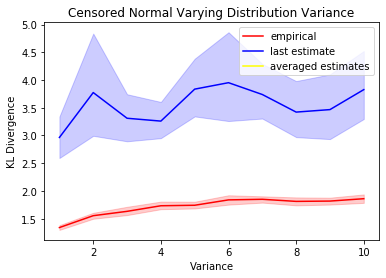

In [28]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='empirical')
sns.lineplot(data=logs, x='var', y='kl_div_censored', color='blue', label='last estimate')
ax = sns.lineplot(data=logs, x='var', y='kl_div_censored_avg', color='yellow', label='averaged estimates')
ax.set_title('Censored Normal Varying Distribution Variance')
ax.set_xlabel('Variance')
ax.set_ylabel('KL Divergence')
ax.legend()

In [38]:
ch.abs(ch.linalg.eigvals(Sigma_k) - s) < .1

tensor([True, True, True, True, True, True, True, True, True, True])

In [35]:
u, s, v = ch.linalg.svd(Sigma_k)

In [36]:
ch.linalg.eigvals(Sigma_k)[42], s[42]

IndexError: index 42 is out of bounds for dimension 0 with size 10

In [37]:
ch.abs(ch.linalg.eigvals(Sigma_k) - s)

tensor([7.6294e-06, 1.1921e-06, 1.9073e-06, 9.5367e-07, 2.1458e-06, 8.3447e-07,
        0.0000e+00, 2.3842e-07, 9.3963e-03, 9.3968e-03])

In [92]:
test = ch.ones(2, 2)

In [94]:
test1 = ch.ones(2, 1)
test2 = ch.ones(2, 1)


In [97]:
ch.cat([test1, test2], dim=1).stride()

(2, 1)